<a href="https://colab.research.google.com/github/williamtheodoruswijaya/Datathon-UI-2025/blob/main/notebook/William/William_Notebook_editted.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Business Objective

Prediksi kinerja saham IPO untuk jangka pendek (1d, 1w), jangka menengah (1m), jangka panjang (6m, 1y)

Potensi manfaat:
- Untuk perusahaan yang ingin IPO
- Untuk investor yang ingin mengikuti IPO

Dalam memprediksinya, kami menggunakan:
- Informasi umum perusahaan
- Informasi IPO perusahaan
- Data keuangan perusahaan

In [126]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold, cross_val_predict

import os
import warnings
warnings.filterwarnings('ignore')

## Load Data

In [127]:
df = pd.read_csv("./data/data.csv")

df.head()

Ticker                  Nama Perusahaan Tanggal Listing  \
0   UNIQ               PT Ulima Nitra Tbk        8-Mar-21   
1   GTRA  PT Grahaprima Suksesmandiri Tbk       30-Mar-23   
2   BSBK  PT Wulandari Bangun Laksana Tbk        8-Nov-22   
3   COAL   PT Black Diamond Resources Tbk        7-Sep-22   
4   CRAB    PT Toba Surimi Industries Tbk       10-Aug-22   

                      Sektor  \
0                     Energy   
1  Transportation & Logistic   
2   Properties & Real Estate   
3                     Energy   
4     Consumer Non-Cyclicals   

                                         Underwriter   Papan Pencatatan  \
0                           PT Surya Fajar Sekuritas              utama   
1                          PT UOB Kay Hian Sekuritas       pengembangan   
2  PT KGI Sekuritas Indonesia; PT Panca Global Se...       pengembangan   
3                           PT Surya Fajar Sekuritas  pemantauan khusus   
4                         PT KGI Sekuritas Indonesia       pengembangan   

  Ownership  Listed Share  Persen Saham Ditawarkan  \
0   lainnya  3.138983e+09                   0.0956   
1   lainnya  1.894375e+09                   0.2000   
2   lainnya  2.275000e+10                   0.1209   
3   lainnya  6.250000e+09                   0.2000   
4   lainnya  1.950000e+09                   0.2000   

  Rencana Penggunaan Dana IPO  ... Total Liabilitas    Pendapatan  \
0                 modal kerja  ...     2.670000e+11  2.710000e+11   
1               modal belanja  ...     4.570000e+11  1.950000e+11   
2                 modal kerja  ...     1.120000e+12  5.590600e+10   
3                 modal kerja  ...     2.500000e+14  9.553076e+10   
4                 modal kerja  ...     2.470000e+11  1.360000e+11   

     Laba Kotor  Laba Berjalan (Bukan Komperhensif)  Harga Final  1D %  1W %  \
0  2.454700e+10                       -5.617000e+09          118   999    35   
1  8.756900e+10                        1.130000e+11          150   999    85   
2  3.895000e+10                       -1.943000e+09          100   999   170   
3  4.902891e+10                        4.330173e+10          100   999   280   
4  1.738746e+10                        2.926422e+09          150   999    56   

    1M %  6M %  1Y %  
0    5.0 -25.0 -30.0  
1   77.0  39.0   9.0  
2  140.0 -50.0 -50.0  
3  354.0  36.0 -45.0  
4   59.0  41.0  59.0  

[5 rows x 22 columns]

In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223 entries, 0 to 222
Data columns (total 22 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Ticker                              223 non-null    object 
 1   Nama Perusahaan                     223 non-null    object 
 2   Tanggal Listing                     223 non-null    object 
 3   Sektor                              223 non-null    object 
 4   Underwriter                         223 non-null    object 
 5   Papan Pencatatan                    223 non-null    object 
 6   Ownership                           223 non-null    object 
 7   Listed Share                        223 non-null    float64
 8   Persen Saham Ditawarkan             223 non-null    float64
 9   Rencana Penggunaan Dana IPO         223 non-null    object 
 10  Valuation Currency                  223 non-null    object 
 11  Total Aset                          223 non-n

### Small Explanations:

This's a classification problem to classify this target columns:

- **Harga Final**: Harga final penawaran saham yang ditetapkan
- **1D %**: Persentase keuntungan / kerugian harga saham pada hari pertama perdagangan. (Ngukur initial pop sebuah IPO)
    - Multiclass Classification:
        'ARA': kinerja luar biasa, harga menyentuh batas kenaikan harian.
        'Naik': kinerja positif, tidak mencapai ARA
        'Turun': kinerja negatif
- **1W %**
- **1M %**
- **6M %**
- **1Y %**

Sisanya berdasarkan persentase kenaikan dan penurunan harga saham berdasarkan periode waktu.

## Exploratory Data Analysis & Preprocessing

### 1. Ubah beberapa kolom ke dalam float

In [129]:
cols_to_float = ['Listed Share', 'Total Aset', 'Total Liabilitas', 'Pendapatan', 'Harga Final']
df[cols_to_float] = df[cols_to_float].astype(float)

Pada dataset, kolom-kolom tersebut masih dalam bentuk object.

### 2. Menghilangkan persentase ("%")

In [130]:
cols_percent = ['1D %', '1W %', '1M %', '6M %', '1Y %']
df[cols_percent] = df[cols_percent].replace('%', '', regex=True).astype(float)

Untuk kolom-kolom tersebut, '%' dihilangkan agar dapat diconvert menjadi float.

### 3. Missing Value

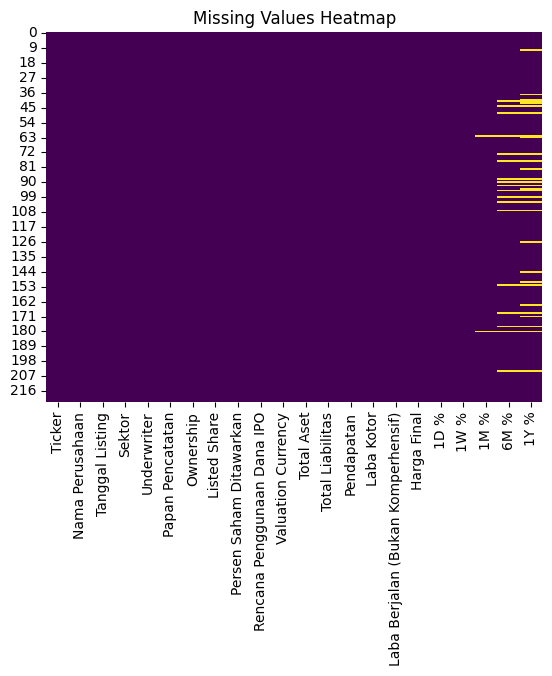

In [131]:
sns.heatmap(df.isna(), cmap='viridis', cbar=False)
plt.title('Missing Values Heatmap')
plt.show()

## Feature Engineering

### Creating a Classification Problem

1. Mengubah kolom 1D % dari numerik menjadi kategorikal berdasarkan ARA.

- Dalam dataset, 999 mengindikasikan saham tersebut ARA pada hari pertama
- Jika 1D % == 999 -> maka kita ubah jadi ARA, sedangkan kalau 1D % > 0 -> maka kita ubah jadi plus, dan kalau 1D % < 0, kita ubah jadi minus.

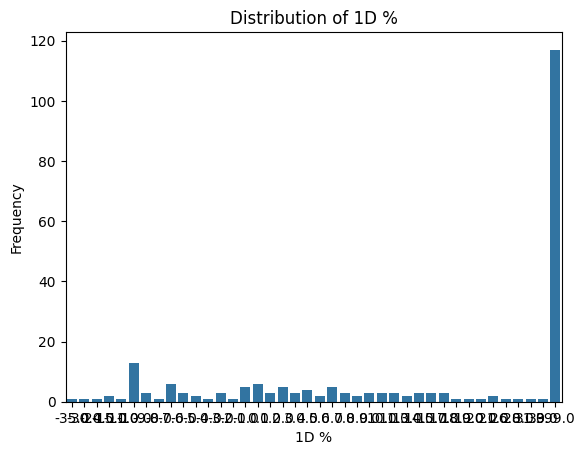

In [132]:
sns.countplot(x="1D %", data=df)
plt.title('Distribution of 1D %')
plt.xlabel('1D %')
plt.ylabel('Frequency')
plt.show()

Sekarang kalau kita ubah:

In [133]:
df['1D %'] = df['1D %'].apply(lambda x: 'ARA' if x == 999 else ('plus' if x >= 0 else 'minus'))

Karena kami mengubah ini menjadi klasifikasi, kolom target '1D %' diklasifikasikan menjadi 3 kategori, yaitu ARA, plus, dan minus. ARA dipisahkan karena setiap harga saham memiliki batas ARA nya masing-masing.

note ARA {harga}: {ara}
- < 200: +35%
- 200-4999: +25%
- .> 4999: +20%

Maka, akan menjadi kolom kategorikal dengan distribusi sebagai berikut:

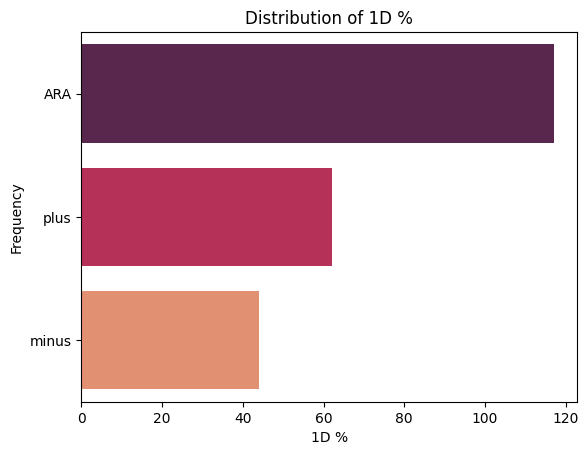

In [134]:
sns.countplot(df['1D %'], palette="rocket")
plt.title('Distribution of 1D %')
plt.xlabel('1D %')
plt.ylabel('Frequency')
plt.show()

Untuk kolom target seperti 1W %, 1M %, 6M %, dan 1Y% masih merupakan kolom numerik. Jadi, kita dapat cek distribusi-nya terlebih dahulu.

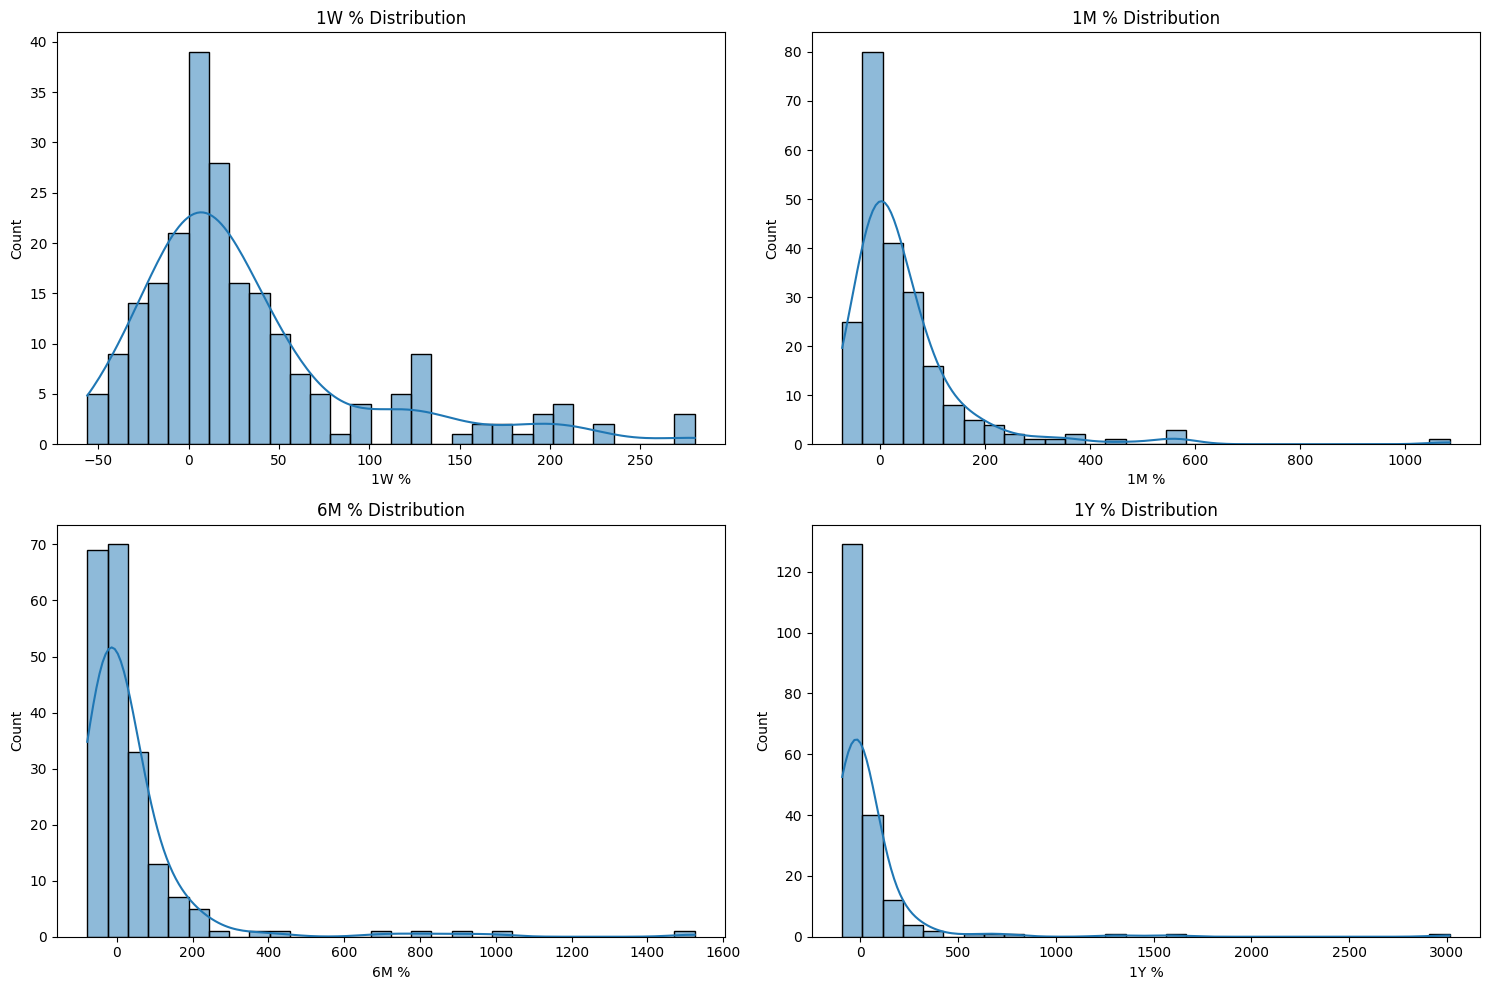

In [135]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.histplot(df['1W %'].dropna(), bins=30, ax=ax[0, 0], kde=True)
sns.histplot(df['1M %'].dropna(), bins=30, ax=ax[0, 1], kde=True)
sns.histplot(df['6M %'].dropna(), bins=30, ax=ax[1, 0], kde=True)
sns.histplot(df['1Y %'].dropna(), bins=30, ax=ax[1, 1], kde=True)
ax[0, 0].set_title('1W % Distribution')
ax[0, 1].set_title('1M % Distribution')
ax[1, 0].set_title('6M % Distribution')
ax[1, 1].set_title('1Y % Distribution')
plt.tight_layout()
plt.show()

Ubah kolom 1W % dan kolom 1M % menjadi 2 kategori yaitu good dan bad

In [136]:
def categorize_mid(val):
    if pd.isnull(val):
        return val
    return 'good' if val >= 5 else 'bad'

for col in ['1W %', '1M %']:
    df[col] = df[col].apply(categorize_mid)

Ubah kolom 6M % dan kolom 1Y % menjadi 2 kategori yaitu plus dan minus

In [137]:
def categorize_long(val):
    if pd.isnull(val):
        return val
    elif val >= 0:
        return 'plus'
    else:
        return 'minus'

for col in ['6M %', '1Y %']:
    df[col] = df[col].apply(categorize_long)

#### Conclusions

Jadi, kita punya sekarang punya target label berupa kategorikal columns.

In [138]:
custom_orders = {
    '1D %': ['ARA', 'plus', 'minus'],
    '1W %': ['good', 'bad'],
    '1M %': ['good', 'bad'],
    '6M %': ['plus', 'minus'],
    '1Y %': ['plus', 'minus']
}

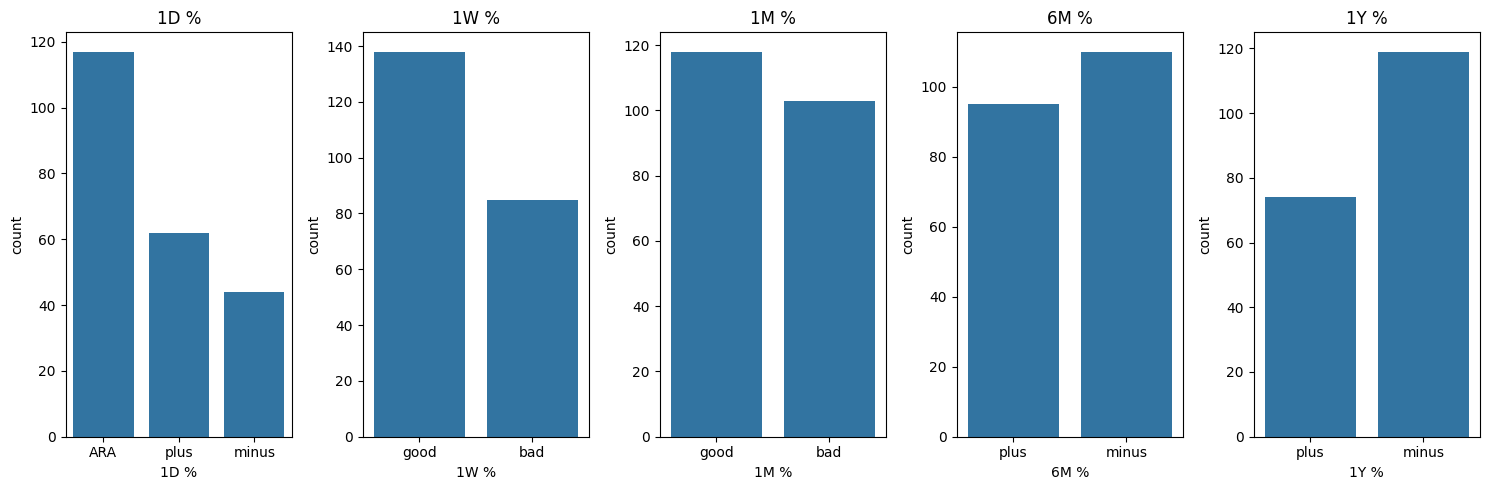

In [139]:
fig, ax = plt.subplots(1, 5, figsize=(15, 5))

cols = ['1D %', '1W %', '1M %', '6M %', '1Y %']

for i, col in enumerate(cols):
    sns.countplot(
        x=col,
        data=df,
        ax=ax[i],
        order=custom_orders.get(col)
    )
    ax[i].set_title(col)

plt.tight_layout()
plt.show()

### 1. Datetime

In [140]:
df['Tanggal Listing'] = pd.to_datetime(df['Tanggal Listing'], format='%d-%b-%y', errors='coerce')
df.sort_values('Tanggal Listing', inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

Ticker                Nama Perusahaan Tanggal Listing           Sektor  \
0   UNIQ             PT Ulima Nitra Tbk      2021-03-08           Energy   
1   ARCI         PT Archi Indonesia Tbk      2021-06-28  Basic Materials   
2   MASB  PT Bank Multiarta Sentosa Tbk      2021-06-30       Financials   
3   BMHS              PT Bundamedik Tbk      2021-07-06       Healthcare   
4   UVCR  PT Trimegah Karya Pratama Tbk      2021-07-27       Technology   

                                         Underwriter   Papan Pencatatan  \
0                           PT Surya Fajar Sekuritas              utama   
1  PT BNI Sekuritas; PT Mandiri Sekuritas; PT Cit...       pengembangan   
2                                   PT BCA Sekuritas  pemantauan khusus   
3                        PT Ciptadana Sekuritas Asia              utama   
4  PT Surya Fajar Sekuritas; PT Mirae Asset Sekur...       pengembangan   

     Ownership  Listed Share  Persen Saham Ditawarkan  \
0      lainnya  3.138983e+09                   0.0956   
1  konglomerat  2.483500e+10                   0.1500   
2      lainnya  1.226903e+09                   0.1500   
3  konglomerat  8.603416e+09                   0.0726   
4      lainnya  2.000000e+09                   0.2500   

  Rencana Penggunaan Dana IPO  ... Total Liabilitas    Pendapatan  \
0                 modal kerja  ...     2.670000e+11  2.710000e+11   
1                bayar hutang  ...     6.860000e+12  4.960000e+12   
2                 modal kerja  ...     1.960000e+13  1.210000e+12   
3                bayar hutang  ...     1.110000e+12  1.150000e+12   
4               modal belanja  ...     1.435880e+10  1.940000e+11   

     Laba Kotor  Laba Berjalan (Bukan Komperhensif)  Harga Final  1D %  1W %  \
0  2.454700e+10                       -5.617000e+09        118.0   ARA  good   
1  2.710000e+12                        1.490000e+12        750.0  plus   bad   
2  4.310000e+11                        1.080000e+11       3360.0   ARA   bad   
3  3.680000e+11                        1.180000e+11        340.0   ARA  good   
4  4.634337e+09                        5.434916e+08        100.0   ARA  good   

   1M %   6M %   1Y %  
0  good  minus  minus  
1   bad  minus  minus  
2   bad   plus   plus  
3  good   plus   plus  
4  good   plus   plus  

[5 rows x 22 columns]

Format tanggal diubah menjadi yang teratur, sehingga memudahkan penggunaannya.

### 2. Underwriter

Ini part/fitur paling penting yang jadi patokan orang-orang dalam menentukan apakah dia akan beli saham atau engga.

Insight yang didapat:
- Underwriter mampu membawa harga saham naik.
- Underwriter yang secara historikal dia ampir selalu ngebawa harga sahamnya naik (contohnya ciptadana, trimegah, henan) -> **Ini yang wajib kita catat**
- Underwriter berupa bank gede (biasanya saham yang di bawa dia cenderung sideways (ga naik, ga turun)) (contohnya bca, bri, bni)
- Semakin sering underwriter menjadi bagian yang mempengaruhi saham, semakin tinggi orang-orang pada mau beli tu saham.


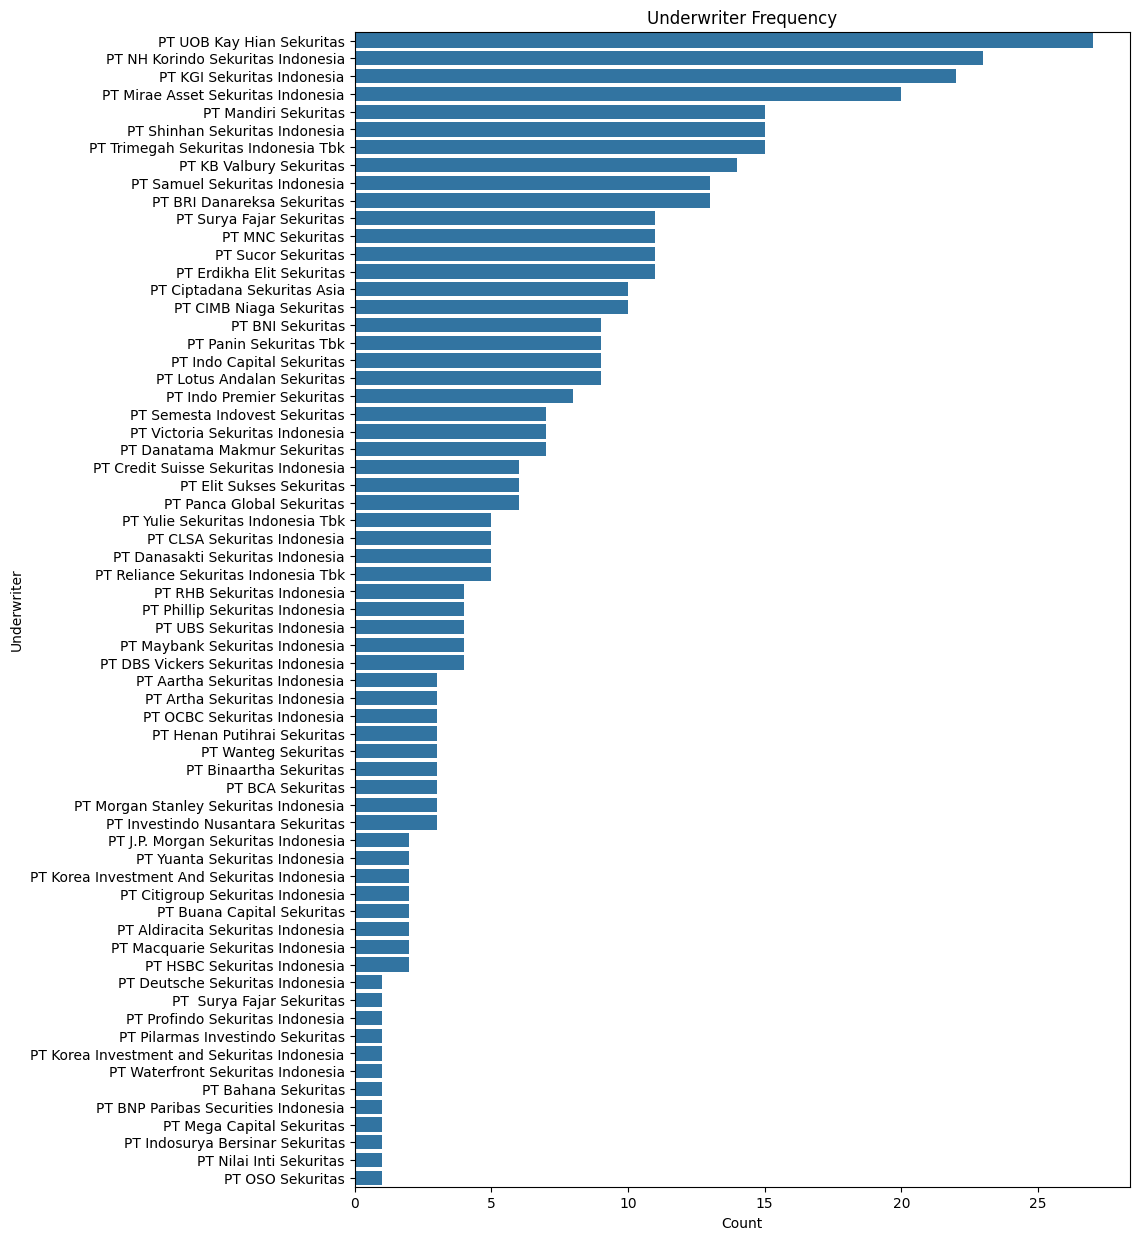

In [141]:
underwriters_exploded = df['Underwriter'].str.split(';').explode().str.strip()
plt.figure(figsize=(10, 15))
sns.countplot(y=underwriters_exploded, order=underwriters_exploded.value_counts().index)
plt.ylabel('Underwriter')
plt.xlabel('Count')
plt.title('Underwriter Frequency')
plt.show()

Sekarang, kita bisa melihat:
1. Underwriter mana yang:
    - paling aktif `freq`
    - cenderung menangani perusahaan besar `avg_aset`
    - mengelola penawaran saham bernilai tinggi `avg_jumlah`
2. Spesialisasi underwriter (apakah ada underwriter yang spesialis di sektor perusahaan dengan aset besar atau kecil?)

Ini juga bakal jadi pertimbangan buat perusahaan buat milih underwriter yang tepat buat perusahaan dia.

In [142]:
freq_dict = {}
aset_dict = {}
jumlah_dict = {}

for idx, row in df.iterrows():
    underwriters = [uw.strip() for uw in row['Underwriter'].split(';') if uw.strip()]
    persen = row['Persen Saham Ditawarkan']
    listed_share = row['Listed Share']
    harga_final = row['Harga Final']
    total_aset = row['Total Aset']

    jumlah = listed_share * harga_final * persen
    for uw in underwriters:
        freq_dict[uw] = freq_dict.get(uw, 0) + 1
        aset_dict[uw] = aset_dict.get(uw, 0.0) + total_aset
        jumlah_dict[uw] = jumlah_dict.get(uw, 0.0) + jumlah

uw_stats = []
for uw in freq_dict:
    freq = freq_dict[uw]
    avg_aset = aset_dict[uw] / freq if freq else 0
    avg_jumlah = jumlah_dict[uw] / freq if freq else 0
    uw_stats.append((uw, freq, avg_aset, avg_jumlah))

uw_df = pd.DataFrame(uw_stats, columns=['underwriter', 'freq', 'avg_aset', 'avg_jumlah']).reset_index(drop=True)
uw_df.head()

underwriter  freq      avg_aset    avg_jumlah
0              PT Surya Fajar Sekuritas    11  1.894937e+11  1.059479e+11
1                      PT BNI Sekuritas     9  3.898356e+13  4.461379e+12
2                  PT Mandiri Sekuritas    15  2.824633e+13  6.182559e+12
3      PT Citigroup Sekuritas Indonesia     2  2.134000e+13  6.393589e+12
4  PT Credit Suisse Sekuritas Indonesia     6  4.180333e+13  8.209206e+12

Ini dilakukan untuk menghitung rata-rata aset perusahaan yang dibawakan underwriter tertentu, beserta dengan rata-rata jumlah dana IPO nya.

In [143]:
high_aset = uw_df['avg_aset'].quantile(0.75)
low_aset = uw_df['avg_aset'].quantile(0.25)

def aset_category(val):
    if val >= high_aset:
        return 'high'
    elif val <= low_aset:
        return 'low'
    else:
        return 'mid'

uw_df['avg_aset_category'] = uw_df['avg_aset'].apply(aset_category)

high_freq = uw_df['freq'].quantile(0.75)
low_freq = uw_df['freq'].quantile(0.25)

def freq_category(val):
    if val >= high_freq:
        return 'high'
    elif val <= low_freq:
        return 'low'
    else:
        return 'mid'

uw_df['freq_category'] = uw_df['freq'].apply(freq_category)
uw_df.head()

underwriter  freq      avg_aset    avg_jumlah  \
0              PT Surya Fajar Sekuritas    11  1.894937e+11  1.059479e+11   
1                      PT BNI Sekuritas     9  3.898356e+13  4.461379e+12   
2                  PT Mandiri Sekuritas    15  2.824633e+13  6.182559e+12   
3      PT Citigroup Sekuritas Indonesia     2  2.134000e+13  6.393589e+12   
4  PT Credit Suisse Sekuritas Indonesia     6  4.180333e+13  8.209206e+12   

  avg_aset_category freq_category  
0               low          high  
1              high          high  
2              high          high  
3              high           low  
4              high           mid

Karena datasetnya kecil, kedua kolom tersebut dikategorikan untuk memudahkan model.

Pengelompokkan dilakukan menggunakan metode kuantil untuk membagi underwriter ke 3 grup yaitu `high`, `mid`, dan `low`

Final check:

In [144]:
uw_df.head()

underwriter  freq      avg_aset    avg_jumlah  \
0              PT Surya Fajar Sekuritas    11  1.894937e+11  1.059479e+11   
1                      PT BNI Sekuritas     9  3.898356e+13  4.461379e+12   
2                  PT Mandiri Sekuritas    15  2.824633e+13  6.182559e+12   
3      PT Citigroup Sekuritas Indonesia     2  2.134000e+13  6.393589e+12   
4  PT Credit Suisse Sekuritas Indonesia     6  4.180333e+13  8.209206e+12   

  avg_aset_category freq_category  
0               low          high  
1              high          high  
2              high          high  
3              high           low  
4              high           mid

Oke, sekarang kita tinggal implementasiin aja ke dataset asli kita.

In [145]:
df['lead_underwriter'] = df['Underwriter'].str.split(';').str[0].str.strip()

1. Buat dictionary berdasarkan `freq` dan `avg` tadi buat di mapping.

In [146]:
uw_map_freq_cat = uw_df.set_index('underwriter')['freq_category'].to_dict()
uw_map_aset_cat = uw_df.set_index('underwriter')['avg_aset_category'].to_dict()

2. Buat kategorikal kolom baru (2 buah) dengan mapping dictionary yang tadi.

- Disini, yang diambil adalah max value dari setiap underwriter suatu IPO

In [147]:
cat_order = {'low': 0, 'mid': 1, 'high': 2}
uw_map_freq_cat = uw_df.set_index('underwriter')['freq_category'].to_dict()
uw_map_aset_cat = uw_df.set_index('underwriter')['avg_aset_category'].to_dict()

def max_category(uw_str, uw_map):
    uws = [u.strip() for u in uw_str.split(';') if u.strip()]
    cats = [uw_map.get(u) for u in uws if uw_map.get(u) is not None]
    if not cats:
        return np.nan
    return max(cats, key=lambda x: cat_order[x])

df['underwriter_freq_category'] = df['Underwriter'].apply(lambda x: max_category(x, uw_map_freq_cat))
df['underwriter_avg_aset_category'] = df['Underwriter'].apply(lambda x: max_category(x, uw_map_aset_cat))

Sekarang, kita akan cek performa saham dengan kategori underwriter yang udah kita buat.

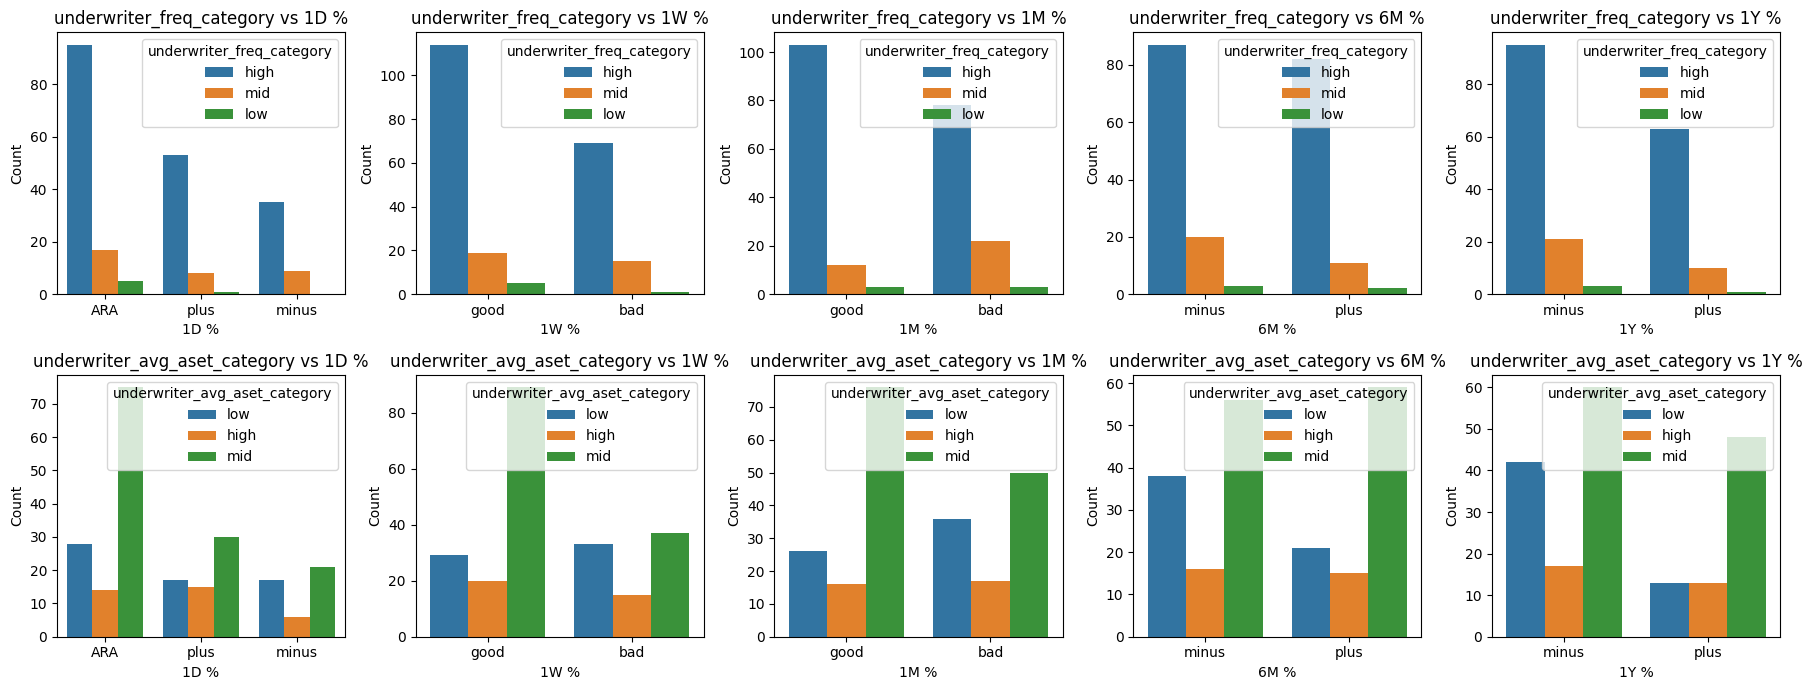

In [148]:
fig, axes = plt.subplots(2, 5, figsize=(18, 7))
target_cols = ['1D %', '1W %', '1M %', '6M %', '1Y %']
plot_cols = ['underwriter_freq_category', 'underwriter_avg_aset_category']

for i, col in enumerate(plot_cols):
    for j, target in enumerate(target_cols):
        ax = axes[i, j]
        sns.countplot(x=df[target], hue=df[col], ax=ax, order = custom_orders.get(col))
        ax.set_title(f"{col} vs {target}")
        ax.set_xlabel(target)
        ax.set_ylabel('Count')
        ax.legend(title=col, loc='best')

plt.tight_layout()
plt.show()

Dari graph di atas, terlihat bahwa underwriter_freq_category 'high' mendominasi. Tentunya ini dikarenakan 'high' paling banyak melakukan IPO. Karena itu, dilakukan plotting lain yaitu berdasarkan persentase.

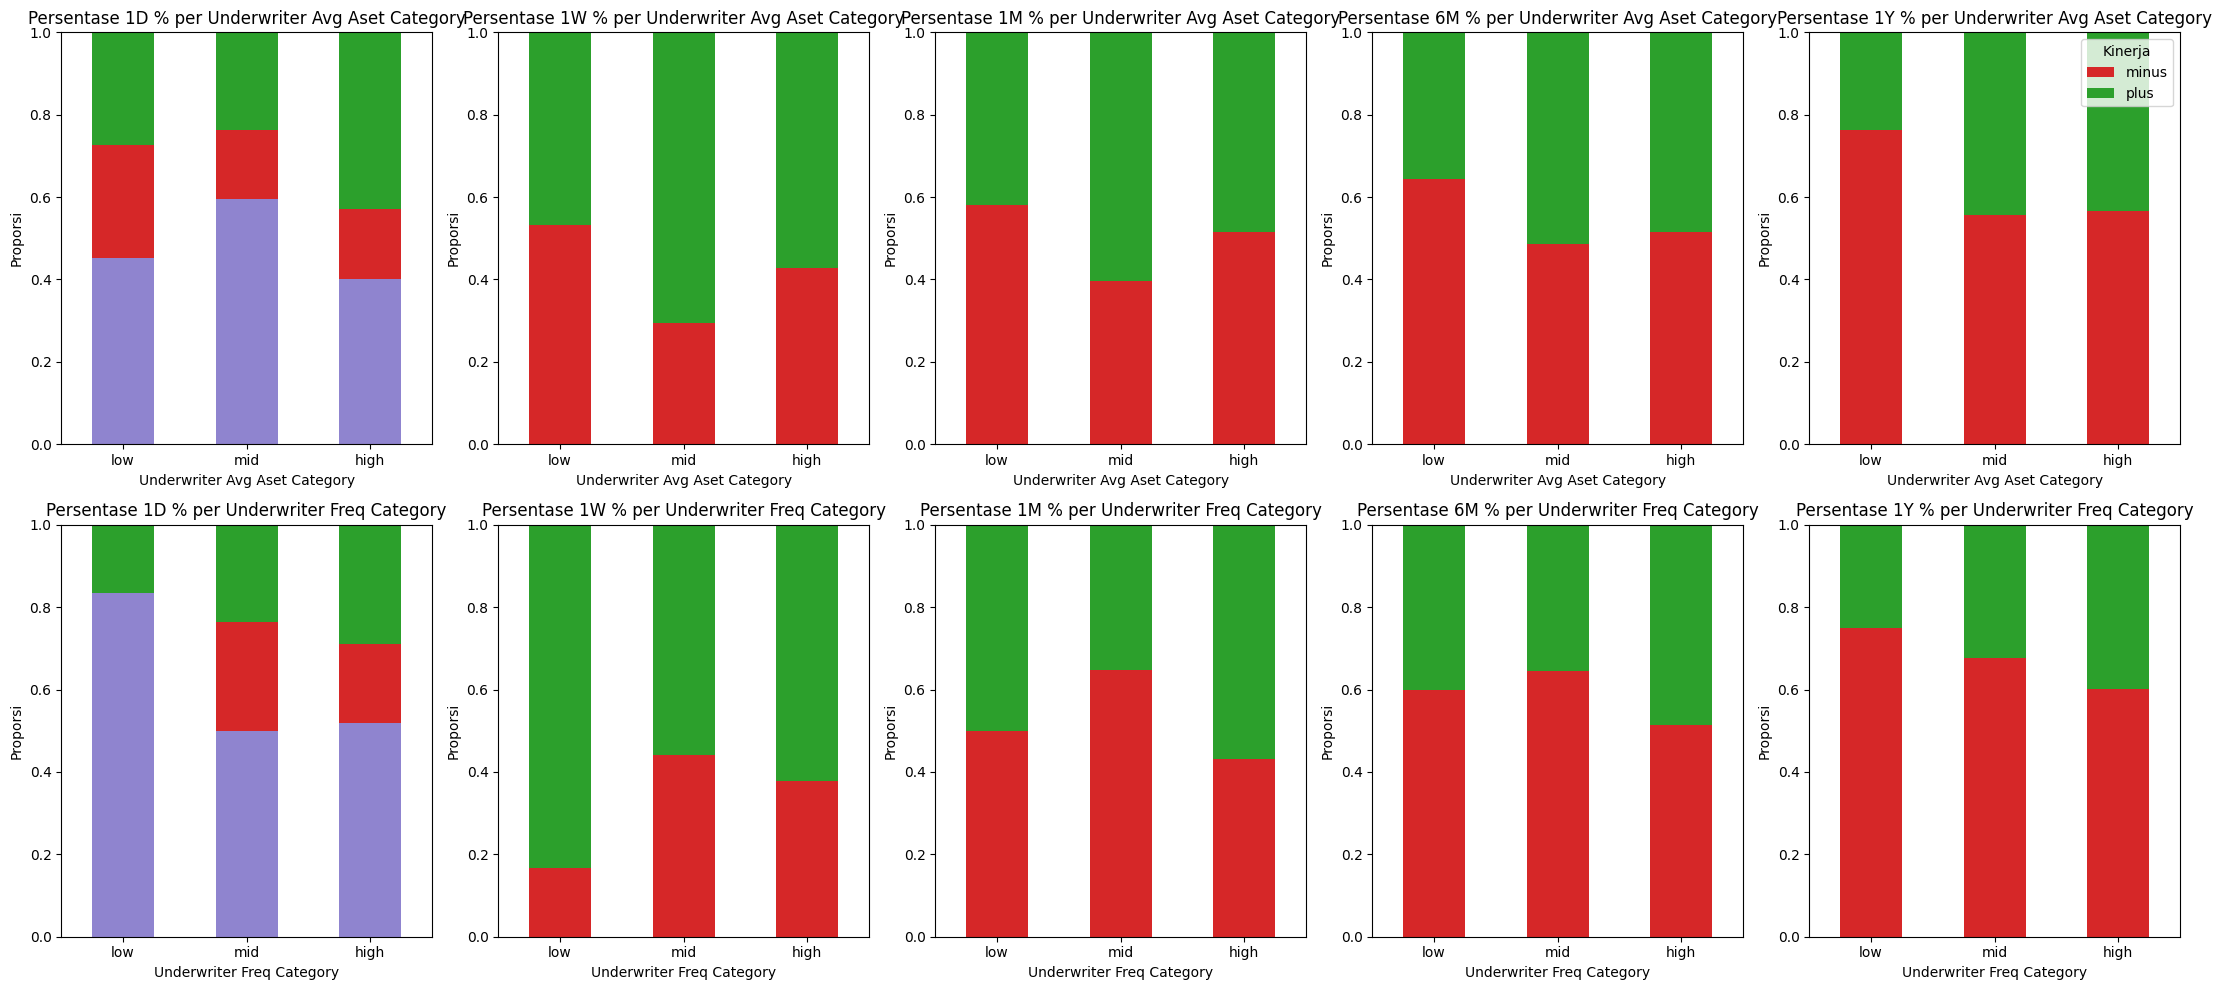

In [149]:
periods = ['1D %', '1W %', '1M %', '6M %', '1Y %']
custom_colors = {
    'minus': '#d62728',
    'plus': '#2ca02c',
    'ARA': "#17009c7b",
    'bad': '#d62728',
    'good': '#2ca02c',
}
cat_order_list = ['low', 'mid', 'high']

fig, axes = plt.subplots(2, len(periods), figsize=(22, 10))

for row_idx, cat_col in enumerate(['underwriter_avg_aset_category', 'underwriter_freq_category']):
    for i, period in enumerate(periods):
        ct_prop = (
            df.groupby(cat_col)[period]
            .value_counts(normalize=True)
            .unstack()
            .fillna(0)
        )
        ct_prop = ct_prop.reindex(cat_order_list)
        labels = ct_prop.columns.tolist()
        color_list = [custom_colors.get(label, '#333333') for label in labels]
        ct_prop[labels].plot(
            kind='bar',
            stacked=True,
            color=color_list,
            ax=axes[row_idx, i],
            legend=False
        )
        axes[row_idx, i].set_title(f'Persentase {period} per {cat_col.replace("_", " ").title()}')
        axes[row_idx, i].set_xlabel(cat_col.replace("_", " ").title())
        axes[row_idx, i].set_ylabel('Proporsi')
        axes[row_idx, i].set_ylim(0, 1)
        axes[row_idx, i].set_xticklabels(cat_order_list, rotation=0)

axes[0, -1].legend(labels, title='Kinerja', loc='upper right')
plt.tight_layout()
plt.show()

**Apakah ada hubungan antara tipe underwriter (berdasarkan frekuensi atau aset klien) dengan kinerja harga saham IPO dalam jangka pendek hingga panjang?**

Insight:
1. 1D % tidak terlalu terlihat polanya jika dari frekuensi underwriter membawakan IPO dan rata-rata besarnya perusahaan yang biasa dibawahakannya.
2. Underwriter yang biasanya membawakan perusahaan-perusahaan yang lebih besar cenderung memberikan kinerja yang lebih baik. Namun, ini dapat juga dikarenakan
   perusahaan yang lebih besar cenderung lebih baik kinerja IPO nya.
2. Frekuensi underwriter tidak terlalu terlihat polanya terhadap kinerja saham IPO yang dibawakannya.

Kemudian, underwriter dikategorikan menjadi 3 tingakat, alpha beta gamma. bikin kategorinya 3 biji, buat short term (1D), mid term (1M), long term (1Y)

In [150]:
label_cols = [
    '1D_ARA', '1D_plus', '1D_minus',
    #'1W_good', '1W_bad',
    '1M_good', '1M_bad',
    #'6M_plus', '6M_minus',
    '1Y_plus', '1Y_minus'
]

for col in label_cols:
    uw_df[col] = 0

uw_df.head()

underwriter  freq      avg_aset    avg_jumlah  \
0              PT Surya Fajar Sekuritas    11  1.894937e+11  1.059479e+11   
1                      PT BNI Sekuritas     9  3.898356e+13  4.461379e+12   
2                  PT Mandiri Sekuritas    15  2.824633e+13  6.182559e+12   
3      PT Citigroup Sekuritas Indonesia     2  2.134000e+13  6.393589e+12   
4  PT Credit Suisse Sekuritas Indonesia     6  4.180333e+13  8.209206e+12   

  avg_aset_category freq_category  1D_ARA  1D_plus  1D_minus  1M_good  1M_bad  \
0               low          high       0        0         0        0       0   
1              high          high       0        0         0        0       0   
2              high          high       0        0         0        0       0   
3              high           low       0        0         0        0       0   
4              high           mid       0        0         0        0       0   

   1Y_plus  1Y_minus  
0        0         0  
1        0         0  
2        0         0  
3        0         0  
4        0         0

Selain kedua kategori itu, dibuat kategori lain, yaitu reputasi underwriter dalam 3 jangka waktu (short, mid, long)

In [151]:
def reset_label_cols(uw_df, label_cols):
    uw_df[label_cols] = 0
    return uw_df

Block di atas untuk me-reset  jumlah setiap label dari setiap underwriter.

In [152]:
def update_uw_df_counts(df, uw_df):
    for idx, row in df.iterrows():
        val_1d = row['1D %']
        val_1m = row['1M %']
        val_1y = row['1Y %']
        underwriters = [uw.strip() for uw in row['Underwriter'].split(';') if uw.strip()]
        for uw in underwriters:
            uw_idx = uw_df[uw_df['underwriter'] == uw].index
            if not uw_idx.empty:
                uw_idx = uw_idx[0]

                if val_1d in ['ARA', 'plus', 'minus']:
                    col_1d = f"1D_{val_1d}"
                    if col_1d in uw_df.columns:
                        uw_df.at[uw_idx, col_1d] += 1

                if val_1m in ['good', 'bad']:
                    col_1m = f"1M_{val_1m}"
                    if col_1m in uw_df.columns:
                        uw_df.at[uw_idx, col_1m] += 1

                if val_1y in ['plus', 'minus']:
                    col_1y = f"1Y_{val_1y}"
                    if col_1y in uw_df.columns:
                        uw_df.at[uw_idx, col_1y] += 1
    return uw_df

Block di atas untuk menghitung jumlah setiap label dari setiap underwriter.

In [153]:
uw_df['short_rep'] = 'gamma'
df_copy = df.copy()

while True:
    uw_df = reset_label_cols(uw_df, label_cols)
    uw_df = update_uw_df_counts(df_copy, uw_df)
    uw_df['score'] = uw_df['1D_ARA'] * 1 + uw_df['1D_minus'] * -1 + uw_df['1D_plus'] * 0.25

    top_uw_idx = uw_df['score'].idxmax()
    top_uw = uw_df.at[top_uw_idx, 'underwriter']
    top_score = uw_df.at[top_uw_idx, 'score']

    denominator = (
        float(uw_df.at[top_uw_idx, '1D_ARA'])
        + float(uw_df.at[top_uw_idx, '1D_plus'])
        + float(uw_df.at[top_uw_idx, '1D_minus'])
    )
    if denominator == 0:
        percentage_score = 0
    else:
        percentage_score = (
            float(uw_df.at[top_uw_idx, '1D_ARA'])
            + 0.25 * float(uw_df.at[top_uw_idx, '1D_plus'])
        ) / denominator

    if percentage_score < 0.4:
        break
    if percentage_score > 0.66 and (uw_df.at[top_uw_idx, '1D_ARA'] >= (uw_df.at[top_uw_idx, '1D_minus'] + uw_df.at[top_uw_idx, '1D_plus'])):
        uw_df.at[top_uw_idx, 'short_rep'] = 'alpha'
    else:
        uw_df.at[top_uw_idx, 'short_rep'] = 'beta'

    df_copy = df_copy[~df_copy['Underwriter'].str.contains(rf'\b{top_uw}\b', regex=True)]

Block di atas untuk melakukan kategorisasi untuk reputasi jangka pendek. 

Algoritma:
1. Menghitung skor dari setiap underwriter berdasarkan label-label mereka terhadap kolom '1D %'
2. Skor terbesar di ambil sebagai top_uw.
3. Jika skor di bawah threshold, loop dihentikan.
4. Jika tidak, berdasarkan threshold, top_uw dikategoriin menjadi 'alpha' atau 'beta'.
5. Rows pada dataset 'df_copy' dengan underwriter top_uw dihapus.
6. Ulangi.

Dengan begitu, maka dapat dikurangi kasus-kasus di mana underwriter itu hanya 'numpang' pada underwriter lainnya yang lebih berpengaruh.


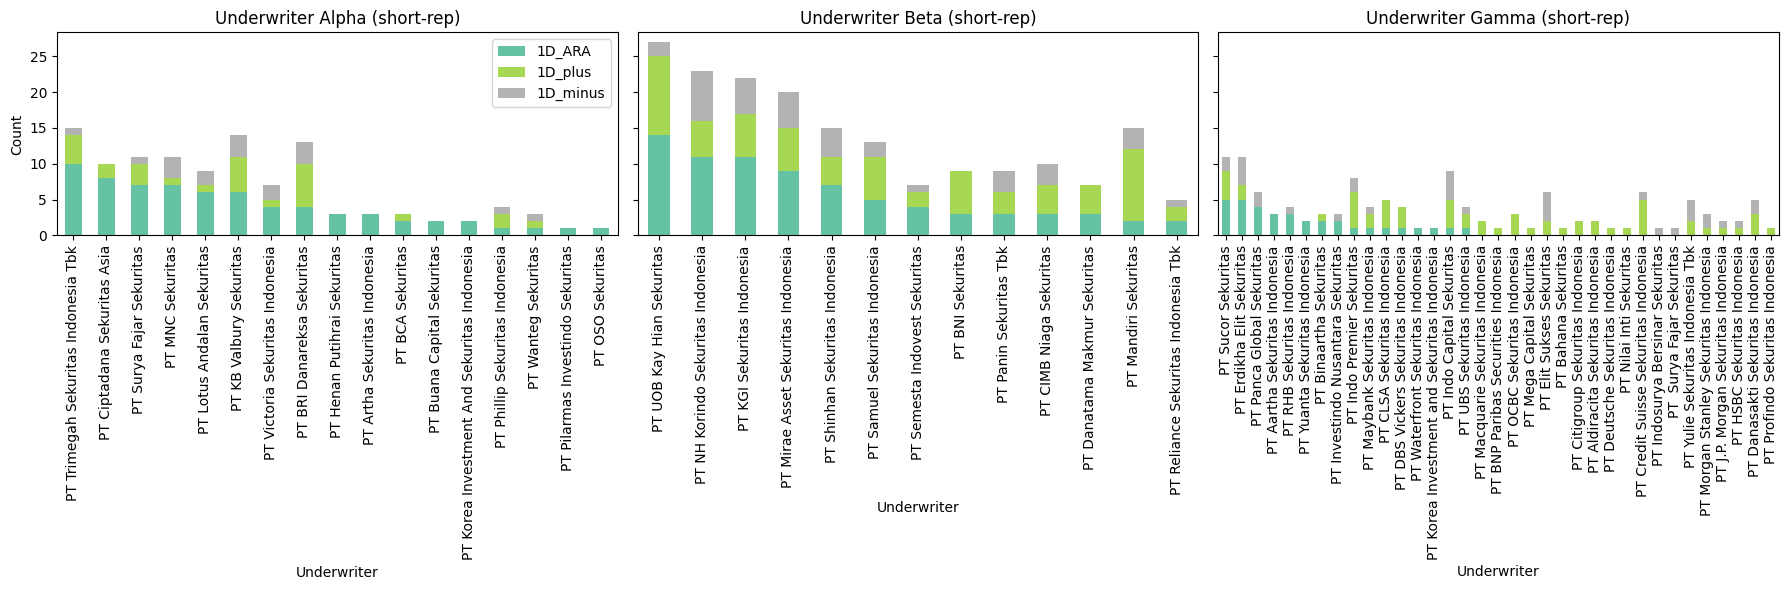

In [154]:
uw_df = reset_label_cols(uw_df, label_cols)
uw_df = update_uw_df_counts(df, uw_df)

groups = ['alpha', 'beta', 'gamma']
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, group in enumerate(groups):
    subset = uw_df[uw_df['short_rep'] == group][['underwriter', '1D_ARA', '1D_plus', '1D_minus']]
    subset = subset.sort_values('1D_ARA', ascending=False)
    subset.set_index('underwriter', inplace=True)
    subset[['1D_ARA', '1D_plus', '1D_minus']].plot(
        kind='bar', stacked=True, ax=axes[i], legend=(i==0), colormap='Set2'
    )
    axes[i].set_title(f'Underwriter {group.capitalize()} (short-rep)')
    axes[i].set_ylabel('Count')
    axes[i].set_xlabel('Underwriter')
    axes[i].tick_params(axis='x', labelrotation=90)

plt.tight_layout()
plt.show()

Graph di atas adalah plotting untuk setiap kategori underwriter_short_rep.

Hal tersebut dilakukan kembali untuk jangka waktu mid dan long.

In [155]:
uw_df['mid_rep'] = 'gamma'
df_copy = df.copy()

while True:
    uw_df = reset_label_cols(uw_df, label_cols)
    uw_df = update_uw_df_counts(df_copy, uw_df)
    uw_df['score'] = uw_df['1M_good'] * 1 + uw_df['1M_bad'] * -1

    top_uw_idx = uw_df['score'].idxmax()
    top_uw = uw_df.at[top_uw_idx, 'underwriter']
    top_score = uw_df.at[top_uw_idx, 'score']

    denominator = (
        float(uw_df.at[top_uw_idx, '1M_good'])
        + float(uw_df.at[top_uw_idx, '1M_bad'])
    )
    if denominator == 0:
        percentage_score = 0
    else:
        percentage_score = float(uw_df.at[top_uw_idx, '1M_good']) / denominator

    if percentage_score < 0.5:
        break
    if percentage_score > 0.66:
        uw_df.at[top_uw_idx, 'mid_rep'] = 'alpha'
    else:
        uw_df.at[top_uw_idx, 'mid_rep'] = 'beta'

    df_copy = df_copy[~df_copy['Underwriter'].str.contains(rf'\b{top_uw}\b', regex=True)]

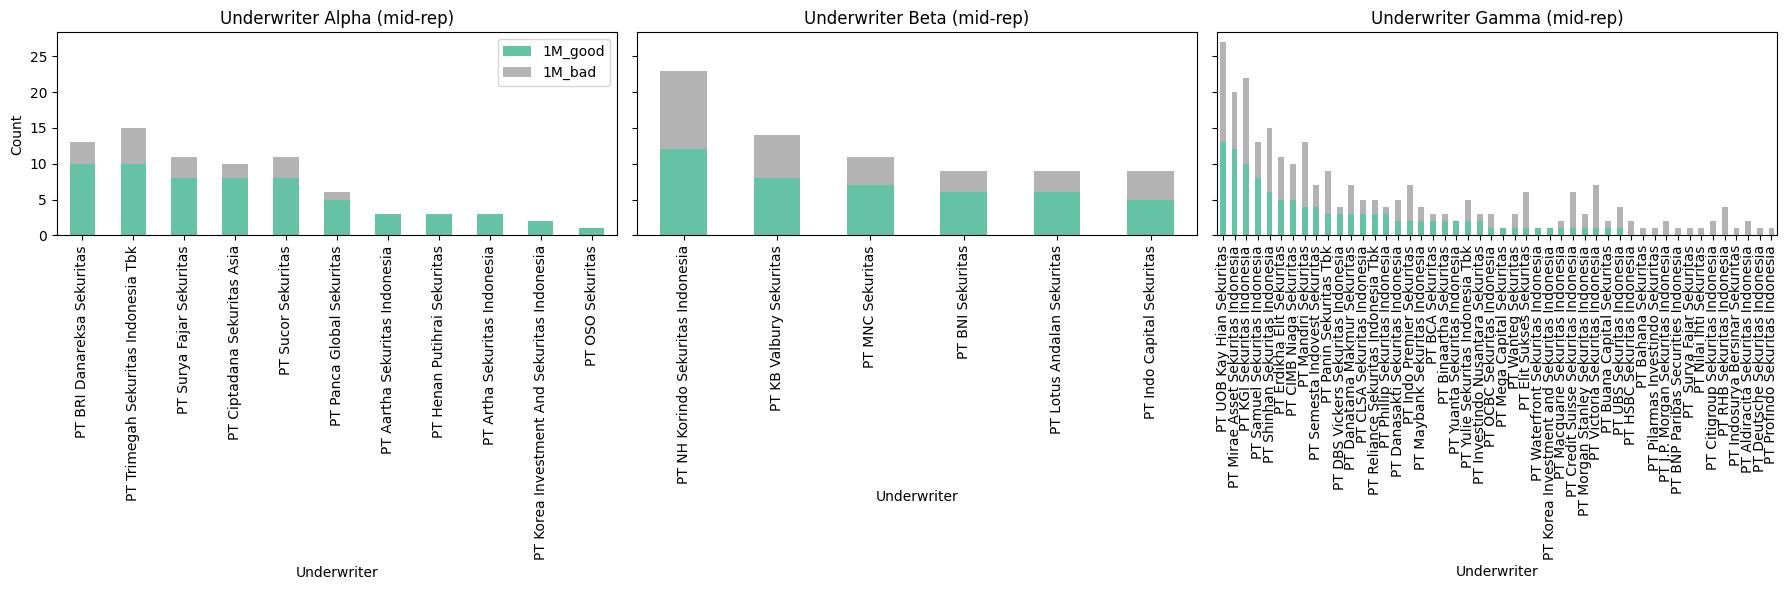

In [156]:
uw_df = reset_label_cols(uw_df, label_cols)
uw_df = update_uw_df_counts(df, uw_df)

groups = ['alpha', 'beta', 'gamma']
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, group in enumerate(groups):
    subset = uw_df[uw_df['mid_rep'] == group][['underwriter', '1M_good', '1M_bad']]
    subset = subset.sort_values('1M_good', ascending=False)
    subset.set_index('underwriter', inplace=True)
    subset[['1M_good', '1M_bad']].plot(
        kind='bar', stacked=True, ax=axes[i], legend=(i==0), colormap='Set2'
    )
    axes[i].set_title(f'Underwriter {group.capitalize()} (mid-rep)')
    axes[i].set_ylabel('Count')
    axes[i].set_xlabel('Underwriter')
    axes[i].tick_params(axis='x', labelrotation=90)

plt.tight_layout()
plt.show()


In [157]:
uw_df['long_rep'] = 'gamma'
df_copy = df.copy()

while True:
    uw_df = reset_label_cols(uw_df, label_cols)
    uw_df = update_uw_df_counts(df_copy, uw_df)
    uw_df['score'] = uw_df['1Y_plus'] * 2 + uw_df['1Y_minus'] * -1

    top_uw_idx = uw_df['score'].idxmax()
    top_uw = uw_df.at[top_uw_idx, 'underwriter']
    top_score = uw_df.at[top_uw_idx, 'score']

    denominator = (
        float(uw_df.at[top_uw_idx, '1Y_plus'])
        + float(uw_df.at[top_uw_idx, '1Y_minus'])
    )
    if denominator == 0:
        percentage_score = 0
    else:
        percentage_score = float(uw_df.at[top_uw_idx, '1Y_plus']) / denominator

    if percentage_score < 0.4:
        break
    if percentage_score > 0.55:
        uw_df.at[top_uw_idx, 'long_rep'] = 'alpha'
    else:
        uw_df.at[top_uw_idx, 'long_rep'] = 'beta'

    df_copy = df_copy[~df_copy['Underwriter'].str.contains(rf'\b{top_uw}\b', regex=True)]

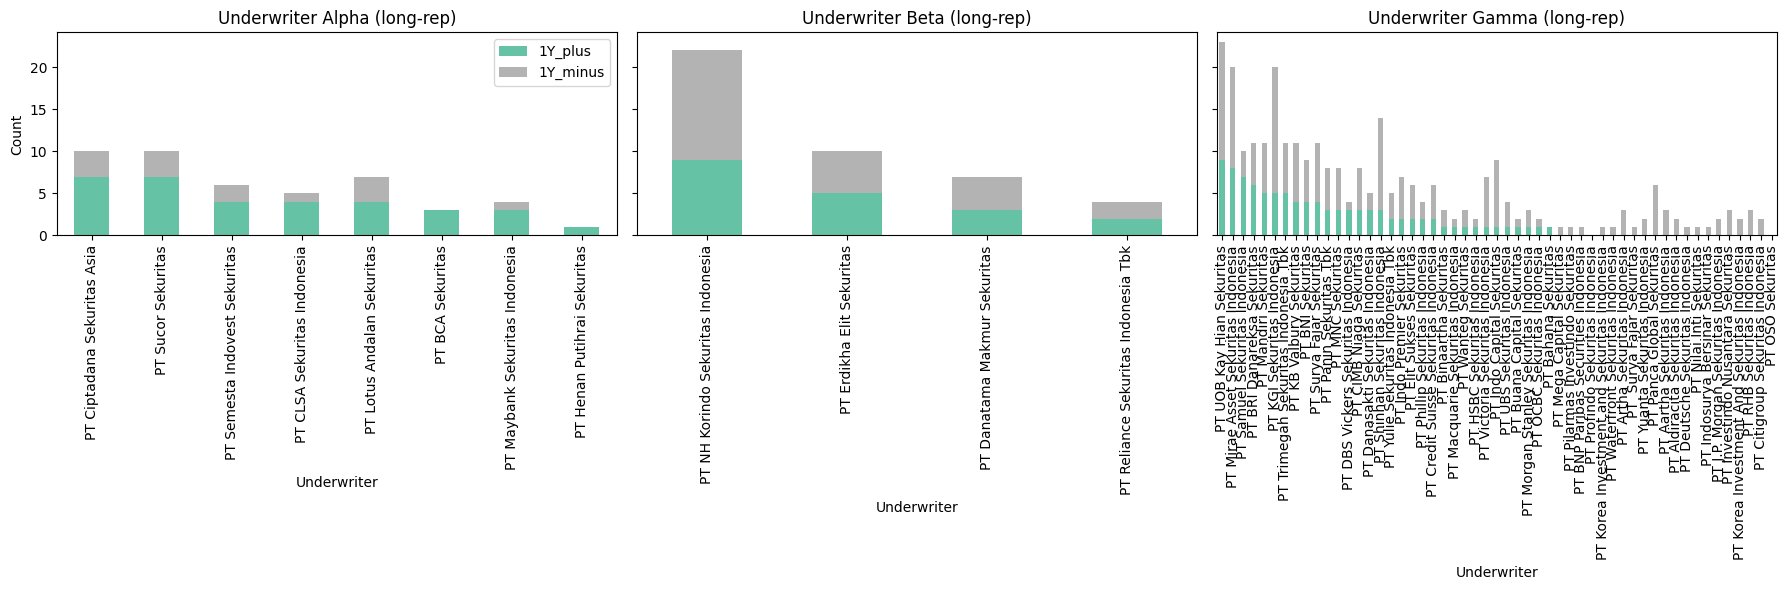

In [158]:
uw_df = reset_label_cols(uw_df, label_cols)
uw_df = update_uw_df_counts(df, uw_df)

groups = ['alpha', 'beta', 'gamma']
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, group in enumerate(groups):
    subset = uw_df[uw_df['long_rep'] == group][['underwriter', '1Y_plus', '1Y_minus']]
    subset = subset.sort_values('1Y_plus', ascending=False)
    subset.set_index('underwriter', inplace=True)
    subset[['1Y_plus', '1Y_minus']].plot(
        kind='bar', stacked=True, ax=axes[i], legend=(i==0), colormap='Set2'
    )
    axes[i].set_title(f'Underwriter {group.capitalize()} (long-rep)')
    axes[i].set_ylabel('Count')
    axes[i].set_xlabel('Underwriter')
    axes[i].tick_params(axis='x', labelrotation=90)

plt.tight_layout()
plt.show()

In [159]:
uw_df = reset_label_cols(uw_df, label_cols)
uw_df = update_uw_df_counts(df, uw_df)
uw_df = uw_df.drop(columns=['score'], errors='ignore')

Dibuat lagi 1 kolom `underwriter_has_bigbank` yang menandakan apakah pada IPO saham itu terdapat bigbank yang terlibat sebagai underwriternya

In [160]:
big_banks_sekuritas = [
    'PT BNI Sekuritas',
    'PT Mandiri Sekuritas',
    'PT Citigroup Sekuritas Indonesia',
    'PT Credit Suisse Sekuritas Indonesia',
    'PT UOB Kay Hian Sekuritas',
    'PT BCA Sekuritas',
    'PT Mirae Asset Sekuritas Indonesia',
    'PT BRI Danareksa Sekuritas',
    'PT UBS Sekuritas Indonesia',
    'PT HSBC Sekuritas Indonesia',
    'PT J.P. Morgan Sekuritas Indonesia',
    'PT Morgan Stanley Sekuritas Indonesia',
    'PT CIMB Niaga Sekuritas',
    'PT CLSA Sekuritas Indonesia',
    'PT Maybank Sekuritas Indonesia',
    'PT DBS Vickers Sekuritas Indonesia',
    'PT Deutsche Sekuritas Indonesia',
    'PT Mega Capital Sekuritas',
    'PT Macquarie Sekuritas Indonesia',
    'PT BNP Paribas Securities Indonesia',
    'PT OCBC Sekuritas Indonesia'
]

Di atas adalah list underwriter yang merupakan perbankan besar.

In [161]:
uw_df['bigbank'] = 'no'

for idx, row in uw_df.iterrows():
    uw = row['underwriter']

    if uw in big_banks_sekuritas:
        uw_df.at[idx, 'bigbank'] = 'yes'

uw_df['bigbank'] = uw_df['bigbank'].astype('object')

Block di atas mengupdate setiap underwriter dari uw_df untuk kolom 'underwriter_has_bigbank' berdasarkan list sebelumnya

In [162]:
df['underwriter_has_bigbank'] = 'no'

for idx, row in df.iterrows():
    underwriters = [uw.strip() for uw in row['Underwriter'].split(';') if uw.strip()]

    if any(uw in big_banks_sekuritas for uw in underwriters):
        df.at[idx, 'underwriter_has_bigbank'] = 'yes'

df['underwriter_has_bigbank'] = df['underwriter_has_bigbank'].astype('object')

Untuk pada dataset IPO, 'underwriter_highest_tier' melambangkan rank tertinggi underwriter yang ada pada IPO tersebut, sedangkan 'underwriter_has_bigbank' menandakan ada big bank atau tidak pada underwriternya.

In [163]:
tier_rank = {'alpha': 1, 'beta': 2, 'gamma': 3}
rank_to_tier = {v: k for k, v in tier_rank.items()}

def process_row(row, uw_df, big_banks_sekuritas):
    underwriter_str = row.get('Underwriter', '')
    underwriters = [uw.strip() for uw in str(underwriter_str).split(';') if uw.strip()]

    uw_subset = uw_df[uw_df['underwriter'].isin(underwriters)]

    result = {}

    for rep_type in ['short', 'mid', 'long']:
        col = f'{rep_type}_rep'
        if not uw_subset.empty:
            tier_values = uw_subset[col].map(tier_rank).dropna()
            best_rank = tier_values.min()
            result[f'underwriter_highest_{rep_type}_rep'] = rank_to_tier[best_rank]
        else:
            result[f'underwriter_highest_{rep_type}_rep'] = None

    return pd.Series(result)

new_cols = df.apply(lambda row: process_row(row, uw_df, big_banks_sekuritas), axis=1)
df = df.join(new_cols)

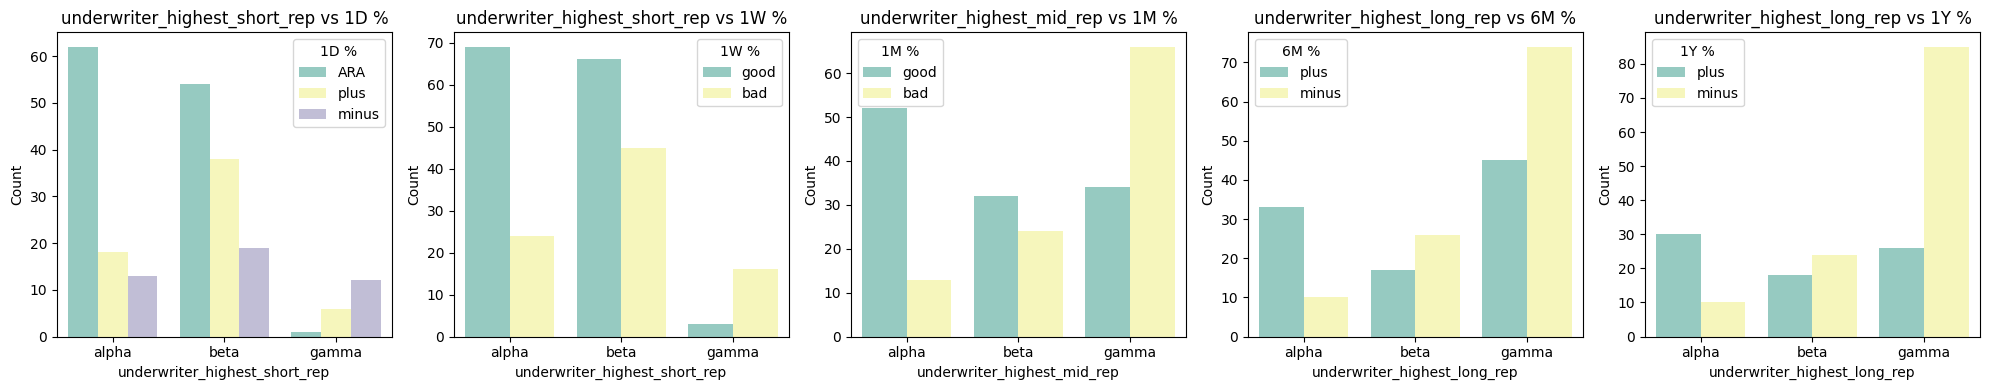

In [164]:
time_to_tier = {
    '1D %': 'underwriter_highest_short_rep',
    '1W %': 'underwriter_highest_short_rep',
    '1M %': 'underwriter_highest_mid_rep',
    '6M %': 'underwriter_highest_long_rep',
    '1Y %': 'underwriter_highest_long_rep',
}

custom_orders = {
    '1D %': ['ARA', 'plus', 'minus'],
    '1W %': ['good', 'bad'],
    '1M %': ['good', 'bad'],
    '6M %': ['plus', 'minus'],
    '1Y %': ['plus', 'minus']
}

fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, col in enumerate(['1D %', '1W %', '1M %', '6M %', '1Y %']):
    x_col = time_to_tier[col]
    sns.countplot(x=df[x_col], hue=df[col], hue_order=custom_orders.get(col), ax=axes[i],
                    order=['alpha', 'beta', 'gamma'],
                    palette='Set3'
                    )
    axes[i].set_title(f'{x_col} vs {col}')
    axes[i].set_xlabel(x_col)
    axes[i].set_ylabel('Count')
    axes[i].legend(title=col, loc='best')
plt.tight_layout()
plt.show()

Dari situ, dapat terlihat IPO yang ada underwriter dengan reputasi lebih tinggi perform lebih baik, meski mungkin terdapat underwriter lainnya yang kurang bagus pada IPO tersebut

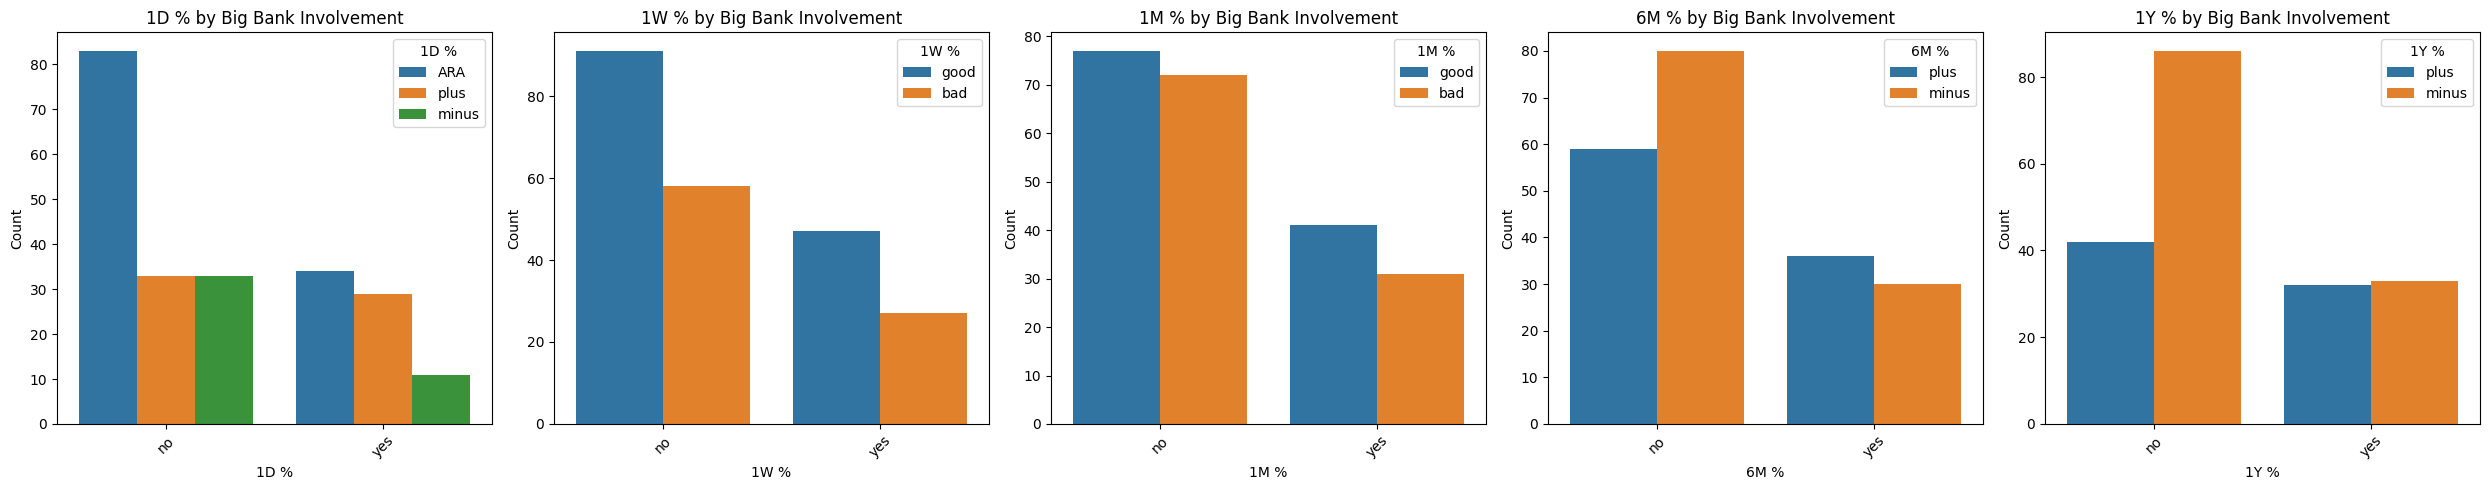

In [165]:
fig, axes = plt.subplots(1, 5, figsize=(25, 5))
cols = ['1D %', '1W %', '1M %', '6M %', '1Y %']

for i, col in enumerate(cols):
    sns.countplot(data=df, x='underwriter_has_bigbank', hue=col, hue_order=custom_orders.get(col), ax=axes[i])
    axes[i].set_title(f"{col} by Big Bank Involvement")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

- Untuk day 1, big bank terlihat lebih cenderung stabil saham IPO nya, sedangkan yang lainnya lebih volatil
- Terutama pada jangka panjang (6M, 1Y), bank besar terlihat mampu menjaga harganya dengan lebih baik

### 3. Seasonality

kolom yang mencatat kuartal saat saham listing

In [166]:
def month_to_quartal(month):
    if month in [1, 2, 3]:
        return 'I'
    elif month in [4, 5, 6]:
        return 'II'
    elif month in [7, 8, 9]:
        return 'III'
    elif month in [10, 11, 12]:
        return 'IV'
    else:
        return 'Unknown'

df['Listing Quartal'] = df['Tanggal Listing'].dt.month
df['Listing Quartal'] = df['Listing Quartal'].apply(month_to_quartal)
df = df.drop(columns=['Tanggal Listing'])
df['Listing Quartal'].value_counts()

Listing Quartal
I      71
III    66
IV     51
II     35
Name: count, dtype: int64

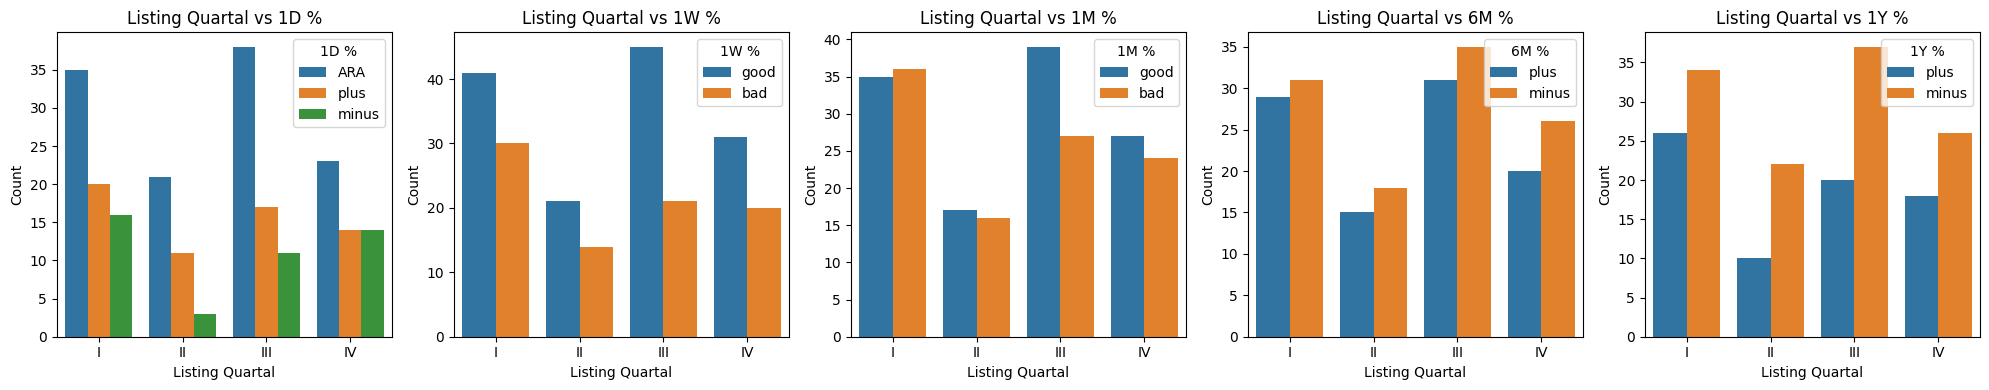

In [167]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, col in enumerate(['1D %', '1W %', '1M %', '6M %', '1Y %']):
    sns.countplot(x=df['Listing Quartal'], hue=df[col], hue_order=custom_orders.get(col), ax=axes[i])
    axes[i].set_title(f'Listing Quartal vs {col}')
    axes[i].set_xlabel('Listing Quartal')
    axes[i].set_ylabel('Count')
    axes[i].legend(title=col, loc='best')
plt.tight_layout()
plt.show()

- Dari countplot tersebut, tidak terlihat adanya pengaruh kuaral listing terhadap kinerja saham IPO.

### 4. Financials

In [168]:
df['ipo_raised_fund'] = df['Listed Share'] * df['Harga Final'] * df['Persen Saham Ditawarkan']

df['equity'] = df['Total Aset'] - df['Total Liabilitas']
df['leverage'] = df['Total Liabilitas'] / df['equity']
df['turnover'] = df['Pendapatan'] / df['Total Aset']


df['PER'] = df['Harga Final'] / (df['Laba Berjalan (Bukan Komperhensif)'] / df['Listed Share'])
df['PBV'] = df['Harga Final'] / (df['equity'] / df['Listed Share'])
df['PER'] = df['PER'].clip(upper=100)
df['PBV'] = df['PBV'].clip(upper=10)

df['ROA'] = df['Laba Berjalan (Bukan Komperhensif)'] / df['Total Aset']
df['ROE'] = df['Laba Berjalan (Bukan Komperhensif)'] / df['equity']
df['NPM'] = df['Laba Berjalan (Bukan Komperhensif)'] / df['Pendapatan']

Di atas adalah metrik-metrik finansial yang sering digunakan untuk mengevaluasi suatu perusahaan.

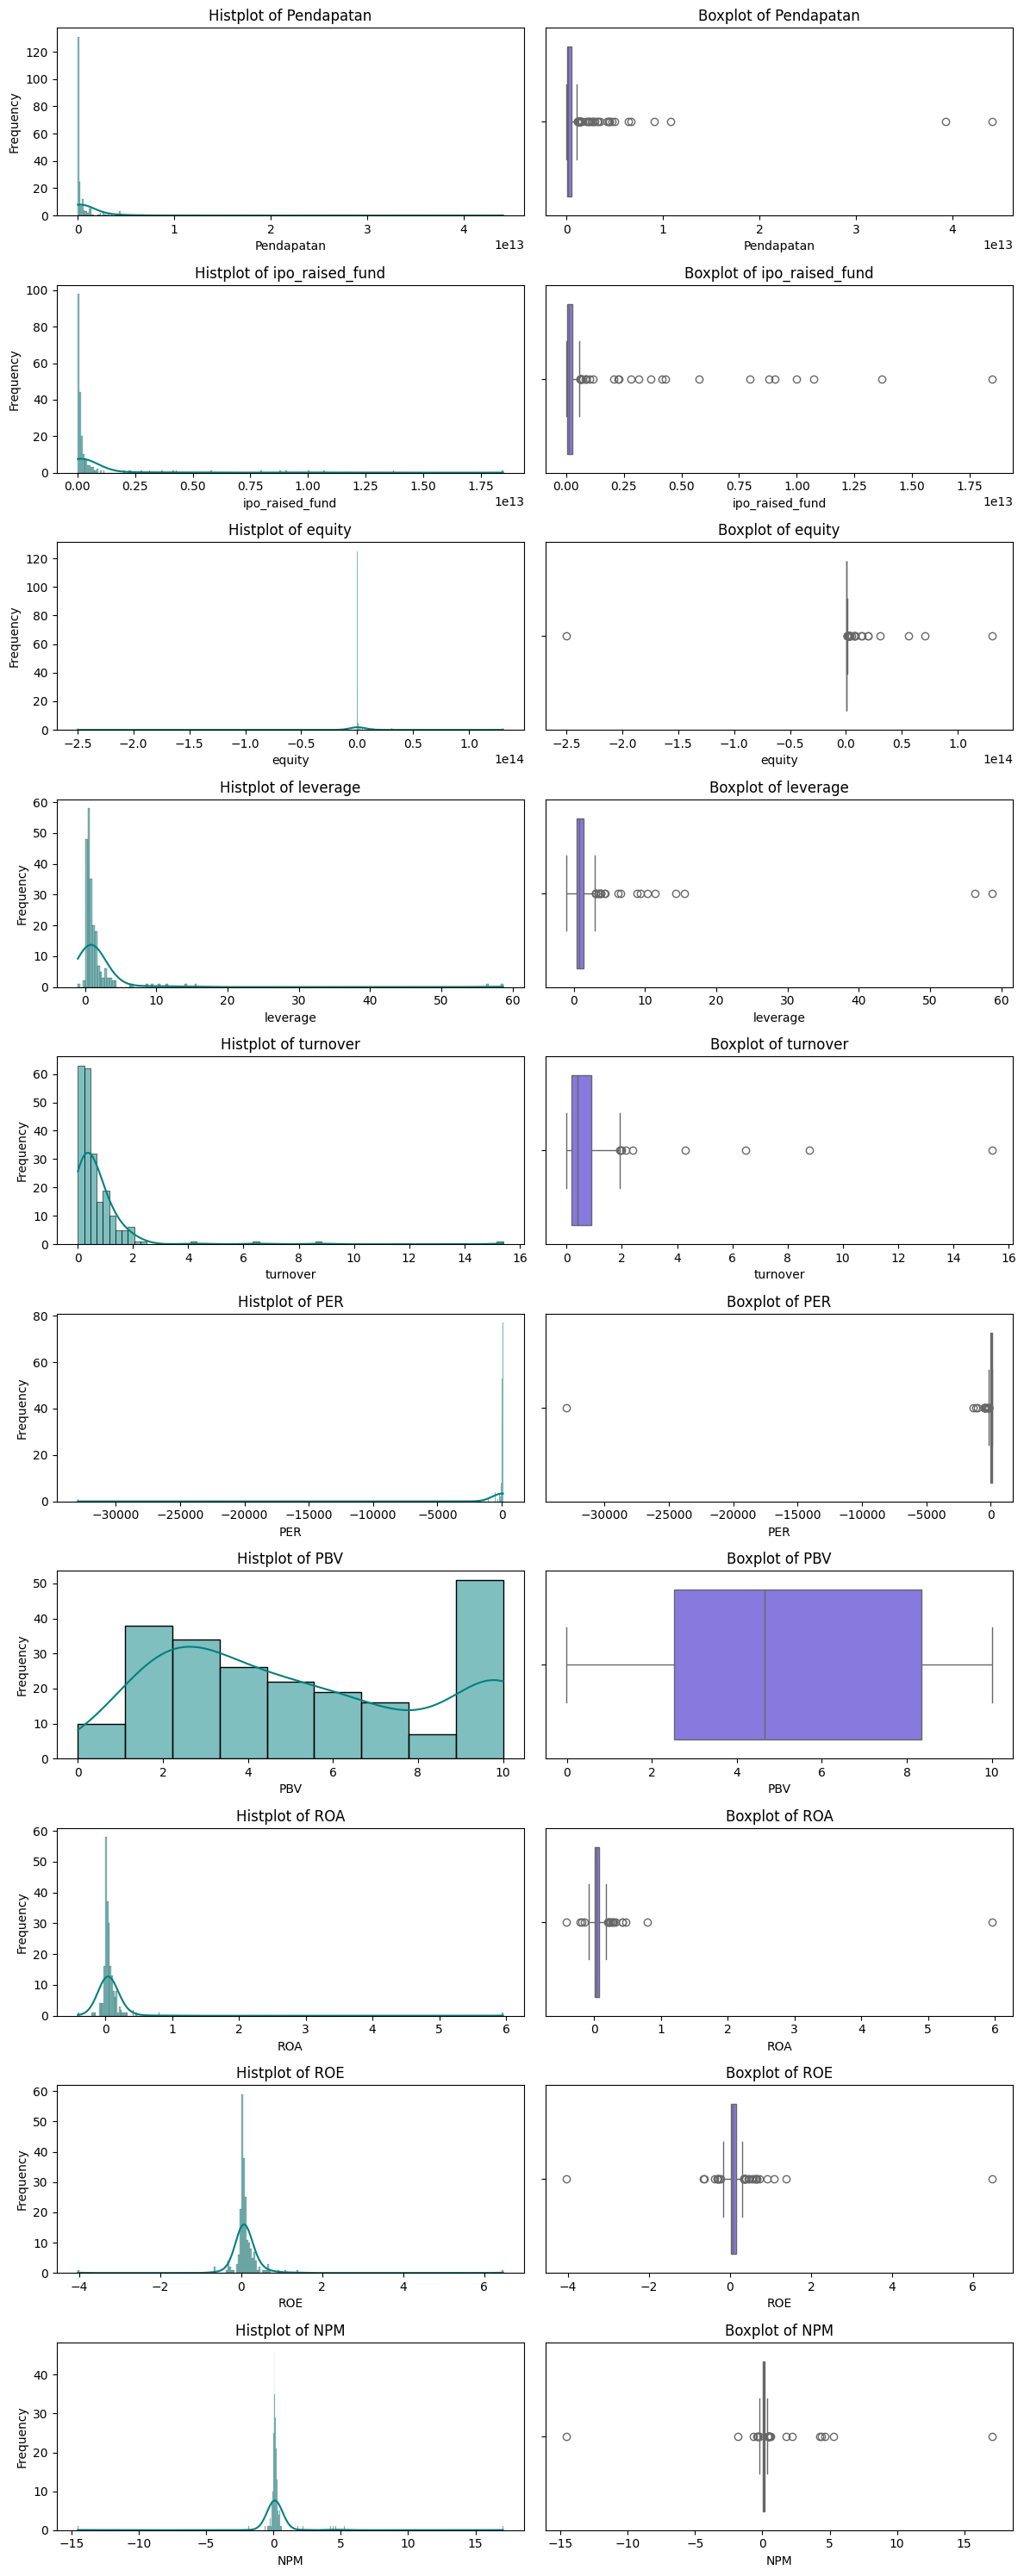

In [169]:
financial_cols = [
    'Pendapatan', 'ipo_raised_fund', 'equity', 'leverage', 'turnover',
    'PER', 'PBV', 'ROA', 'ROE', 'NPM'
]

fig, axes = plt.subplots(len(financial_cols), 2, figsize=(12, 3 * len(financial_cols)))

for idx, col in enumerate(financial_cols):
    data = df[col]

    sns.histplot(data, ax=axes[idx, 0], kde=True, color='teal')
    axes[idx, 0].set_title(f'Histplot of {col}')
    axes[idx, 0].set_xlabel(col)
    axes[idx, 0].set_ylabel('Frequency')

    sns.boxplot(x=data, ax=axes[idx, 1], orient='h', color='mediumslateblue')
    axes[idx, 1].set_title(f'Boxplot of {col}')
    axes[idx, 1].set_xlabel(col)

plt.tight_layout()
plt.show()

Signed log transform diterapkan karena data terlalu skewed. Karena log tidak dapat dilakukan pada nilai negatif, maka perlu di absolut kan terlebih dahulu, dan setelah di transform sign (+/-) nya dipakaikan kembali.

In [170]:
def signed_log1p(x):
    return np.sign(x) * np.log1p(np.abs(x))

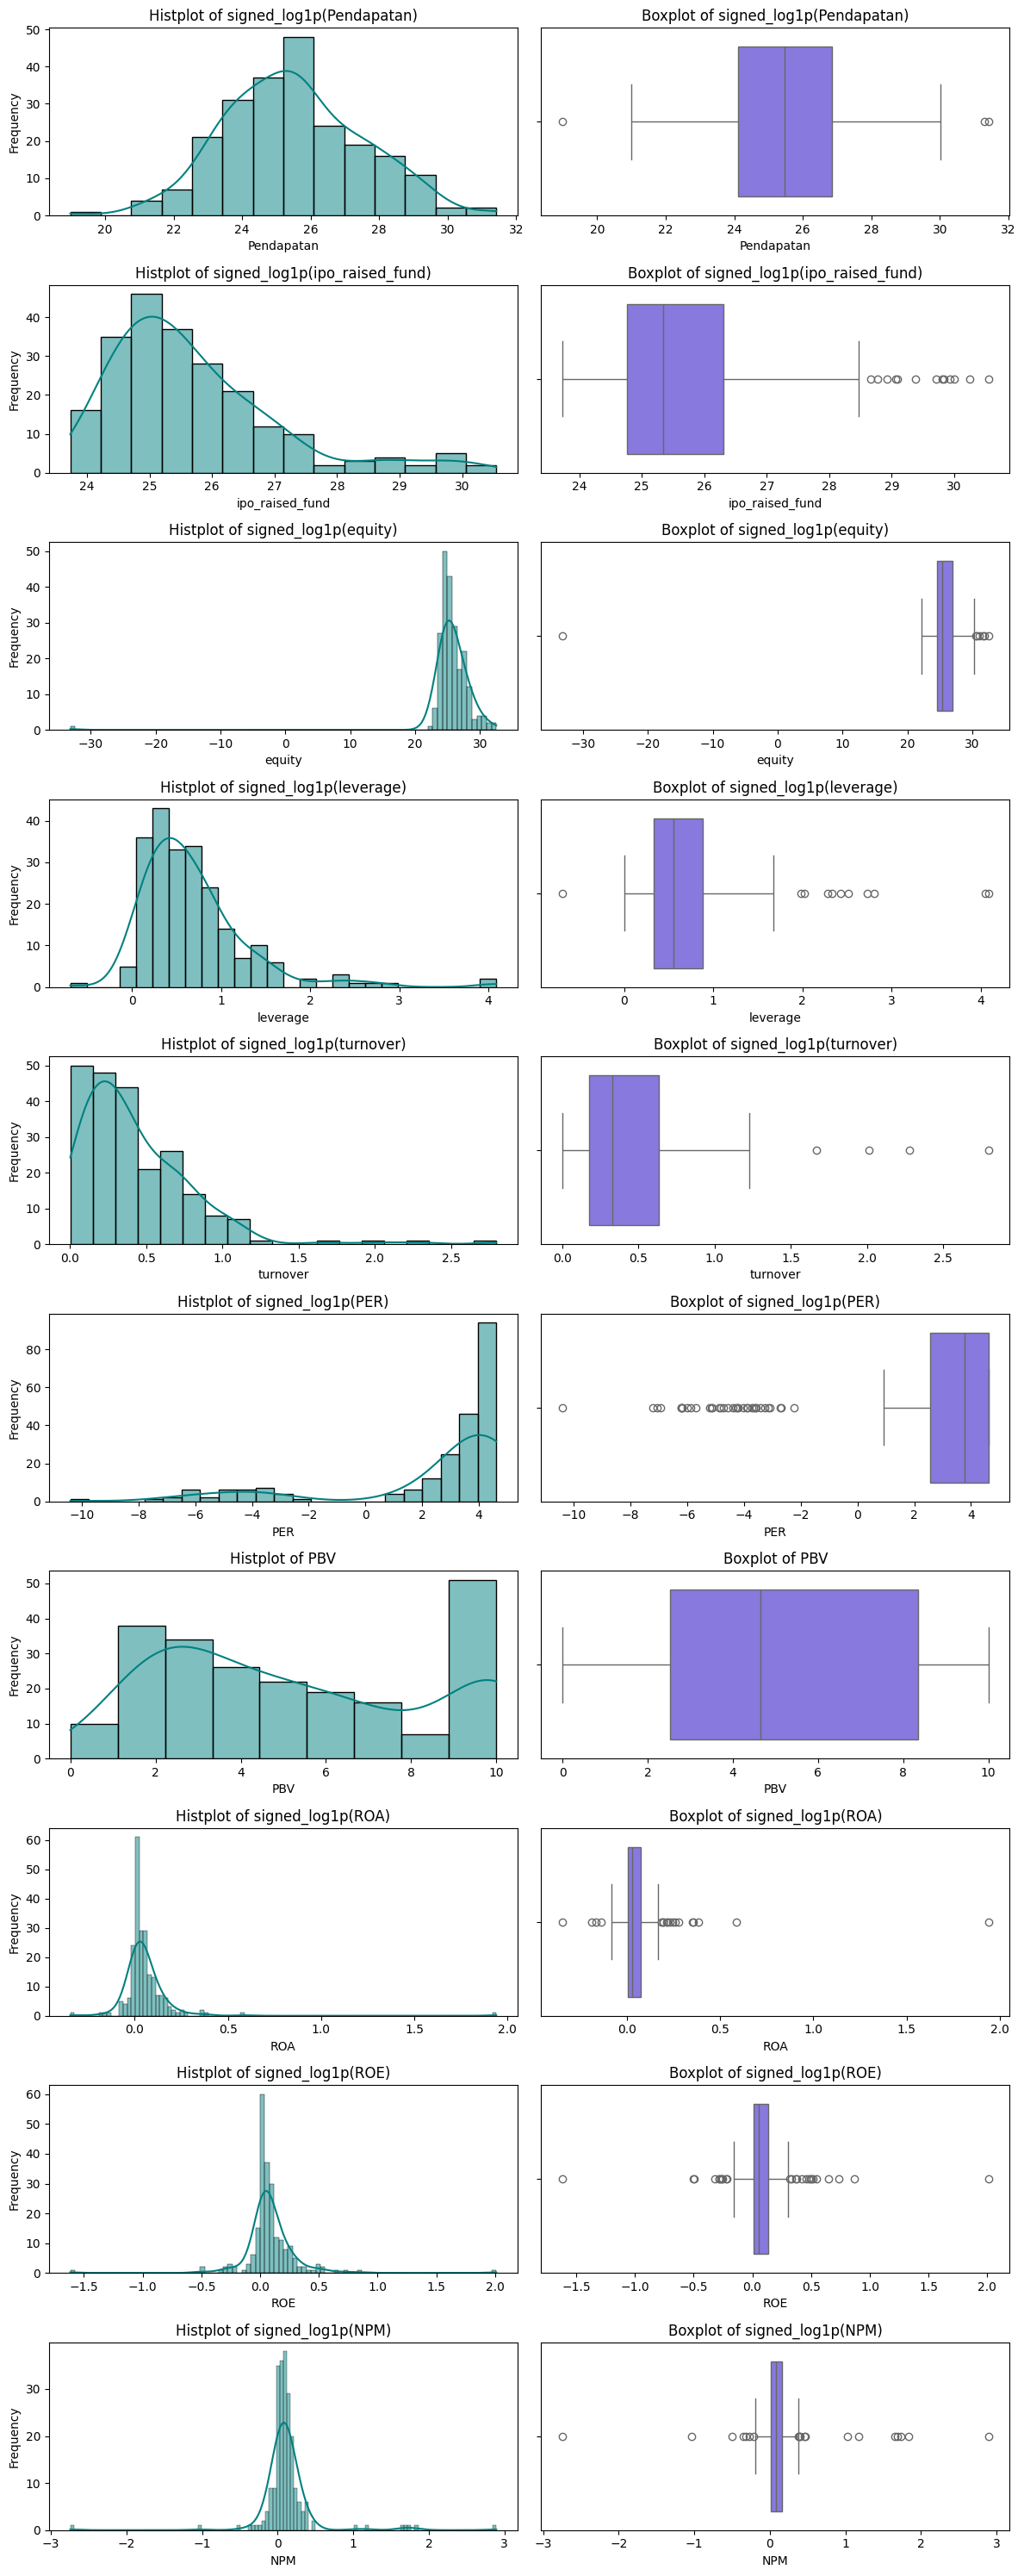

In [171]:
fig, axes = plt.subplots(len(financial_cols), 2, figsize=(12, 3 * len(financial_cols)))

for idx, col in enumerate(financial_cols):
    data = df[col]

    if col != 'PBV':
        data = signed_log1p(data)

    sns.histplot(data, ax=axes[idx, 0], kde=True, color='teal')
    axes[idx, 0].set_title(f'Histplot of {"signed_log1p(" + col + ")" if col != "PBV" else col}')
    axes[idx, 0].set_xlabel(col)
    axes[idx, 0].set_ylabel('Frequency')

    sns.boxplot(x=data, ax=axes[idx, 1], orient='h', color='mediumslateblue')
    axes[idx, 1].set_title(f'Boxplot of {"signed_log1p(" + col + ")" if col != "PBV" else col}')
    axes[idx, 1].set_xlabel(col)

    df[col] = data

plt.tight_layout()
plt.show()

Setelah di lakukan signed log transform, distribusi data terlihat lebih baik.

### 5. Rencana Penggunaan Dana

In [172]:
df['Rencana Penggunaan Dana IPO'].value_counts()

Rencana Penggunaan Dana IPO
modal kerja      100
modal belanja     71
ekspansi          26
bayar hutang      23
belanja modal      3
Name: count, dtype: int64

In [173]:
df['Rencana Penggunaan Dana IPO'] = np.where(
    df['Rencana Penggunaan Dana IPO'] == 'bayar hutang',
    'bayar hutang',
    'modal perusahaan'
)

Di luar 'bayar hutang', fokus utamanya cukup mirip, yaitu untuk keperluan menjalankan bisnisnya atau untuk ekspansi. Karena itu, rencana penggunaan selain 'bayar hutang' dianggap sama yaitu 'modal perusahaan'

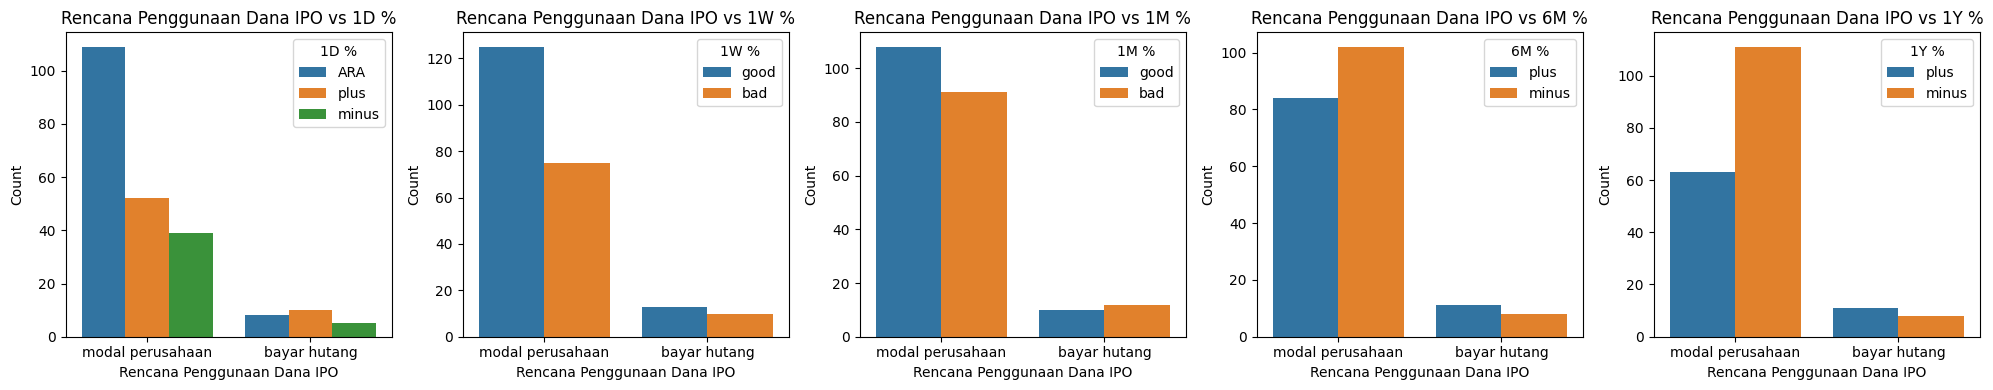

In [174]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, col in enumerate(cols):
    sns.countplot(x='Rencana Penggunaan Dana IPO', hue=col, data=df, hue_order=custom_orders.get(col), ax=axes[i])
    axes[i].set_title(f'Rencana Penggunaan Dana IPO vs {col}')
    axes[i].set_xlabel('Rencana Penggunaan Dana IPO')
    axes[i].set_ylabel('Count')
    axes[i].legend(title=col, loc='best')

plt.tight_layout()
plt.show()

- Karena data sedikit dan terlalu imbalance, maka kolom ini tidak digunakan untuk menghindari overfitting
- Penelitian menunjukan perusahaan IPO dengan tujuan membayar hutang lebih tidak disukai

### 6. Drop yang ga dipake

In [175]:
df = df.drop(['Listed Share', 'Rencana Penggunaan Dana IPO', 'Valuation Currency', 'Total Liabilitas', 'Laba Kotor', 'Laba Berjalan (Bukan Komperhensif)'], axis=1)

Kolom-kolom yang di buang merupakan data utama; Akan susah bagi model untuk mengetahui hubungannya karena untuk mengertinya perlu dihubungkan dengan data lainnya. Di sisi lain, kolom-kolom lainnya yang dibuat di atas adalah data turunan, yang merupakan rasio; Model akan lebih mudah mengerti hubungannya.

### 7. Total Aset (Numeric -> Category)

Total aset dikateogikan untuk memudahkan model. Dilakukan log transform terlebih dahulu kemudian digunakan metode kuantil untuk membaginya.

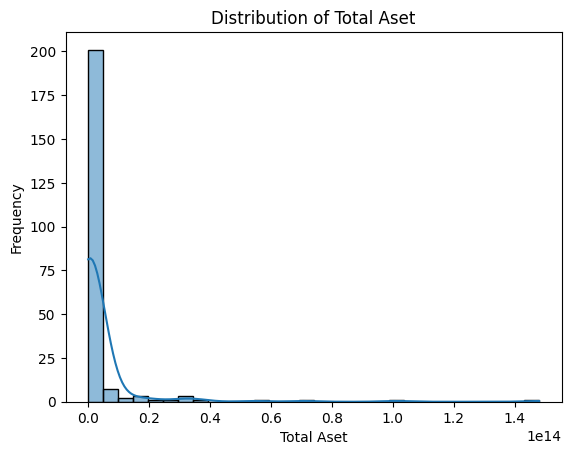

In [176]:
sns.histplot(data=df, x='Total Aset', kde=True, bins=30)
plt.title('Distribution of Total Aset')
plt.xlabel('Total Aset')
plt.ylabel('Frequency')
plt.show()

In [177]:
df['Total Aset'] = np.log1p(df['Total Aset'].clip(lower=1e-9))

In [178]:
df['total_aset_category'] = pd.cut(
    df['Total Aset'],
    bins=[-float('inf'), df['Total Aset'].quantile(0.25), df['Total Aset'].quantile(0.75), float('inf')],
    labels=['low', 'mid', 'high']
)

In [179]:
df['total_aset_category'] = df['total_aset_category'].astype('object')

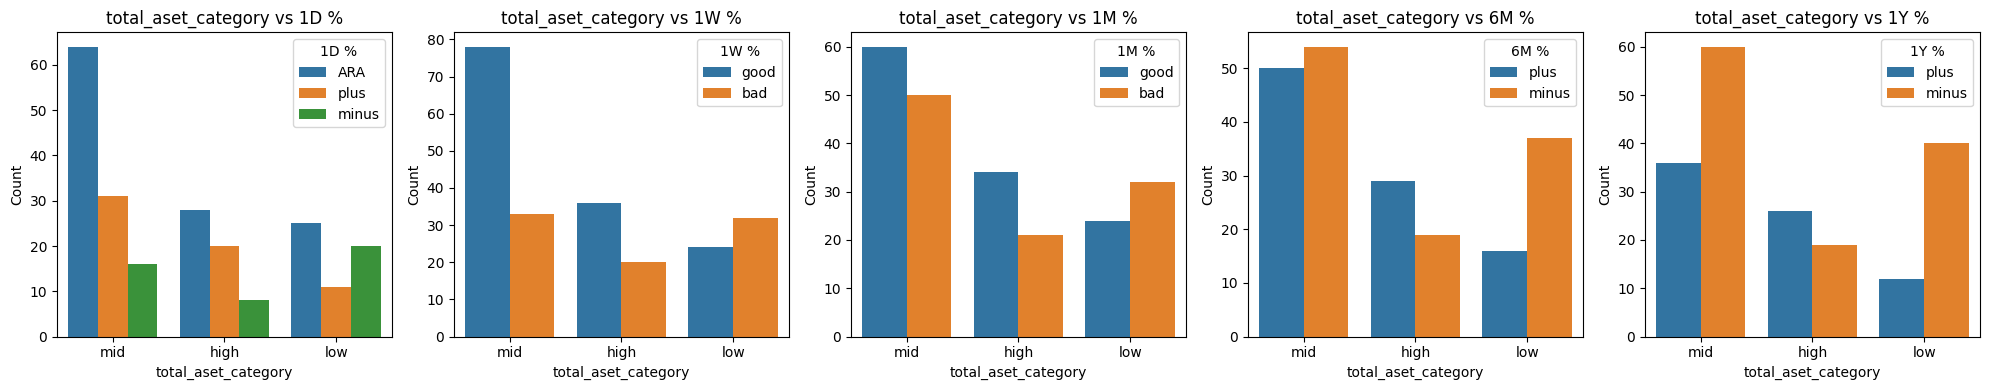

In [180]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, col in enumerate(['1D %', '1W %', '1M %', '6M %', '1Y %']):
    sns.countplot(x=df['total_aset_category'], hue=df[col], hue_order=custom_orders.get(col), ax=axes[i])
    axes[i].set_title(f'total_aset_category vs {col}')
    axes[i].set_xlabel('total_aset_category')
    axes[i].set_ylabel('Count')
    axes[i].legend(title=col, loc='best')
plt.tight_layout()
plt.show()

- Perusahaan aset tinggi cenderung perform lebih baik

### 8. Harga Final (Numeric -> Category)

In [181]:
df['price_category'] = pd.cut(
    df['Harga Final'],
    bins=[-float('inf'), 200, 500, 2000, 5000, float('inf')],
    labels=['penny', 'low', 'medium', 'high', 'premium']
)

Kategori di atas adalah sesuai dengan ketentuan BEI untuk setiap rentang harga. Setiap rentang harga memiliki spread, batas atas, dan batas bawahnya masing-masing.

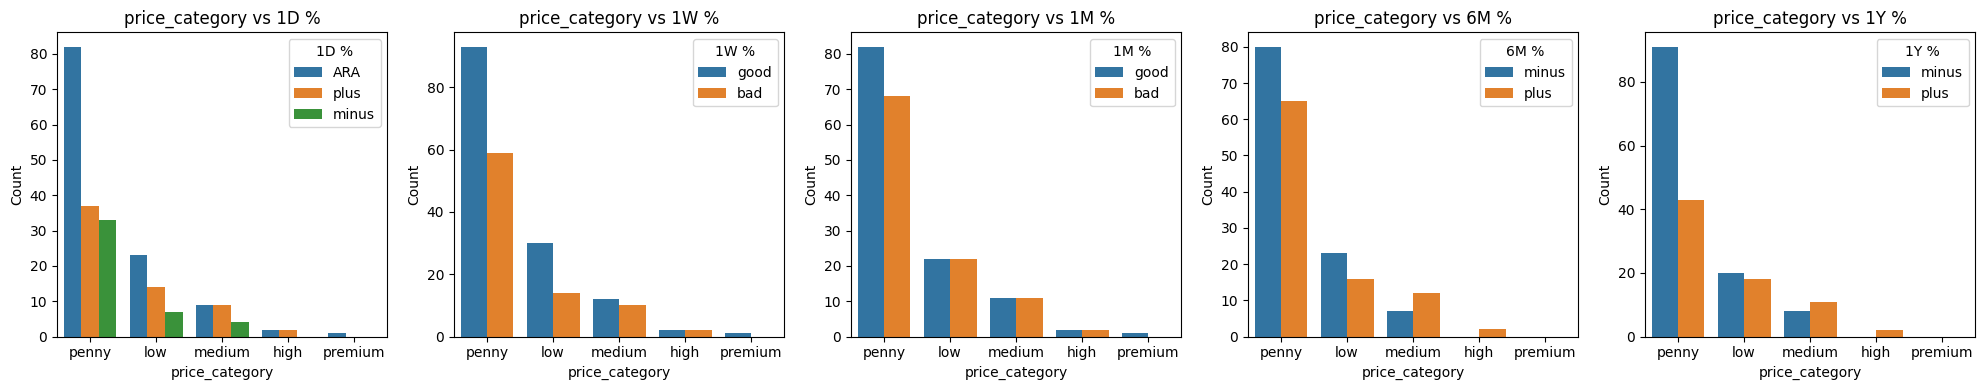

In [182]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, col in enumerate(['1D %', '1W %', '1M %', '6M %', '1Y %']):
    sns.countplot(x=df['price_category'], hue=df[col], ax=axes[i])
    axes[i].set_title(f'price_category vs {col}')
    axes[i].set_xlabel('price_category')
    axes[i].set_ylabel('Count')
    axes[i].legend(title=col, loc='best')
plt.tight_layout()
plt.show()

In [183]:
df['price_category'] = df['price_category'].astype('object')

### 9. Further Analysis

Dari atas terlihat bahwa perusahaan dengan aset besar cenderung lebih bagus performanya. Untuk penelitian lebih lanjut, dicari lagi pola antara perusahaan beraset kecil yang dapat tetap berkinerja baik.

In [184]:
df['total_aset_category'].value_counts()

total_aset_category
mid     111
high     56
low      56
Name: count, dtype: int64

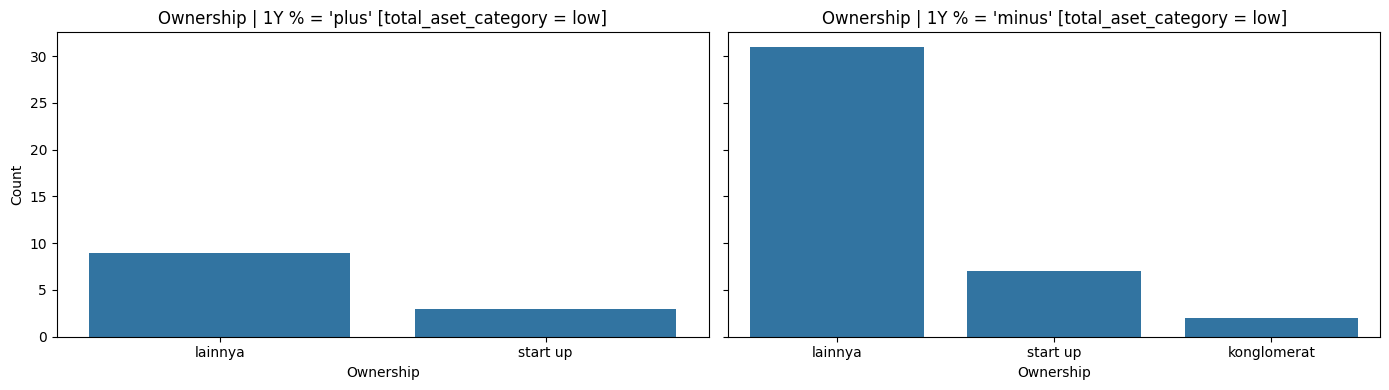

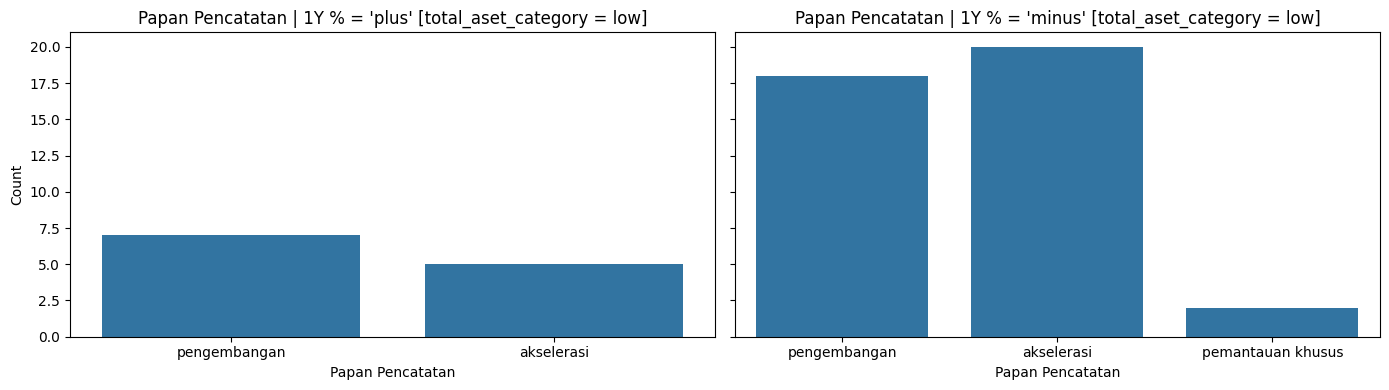

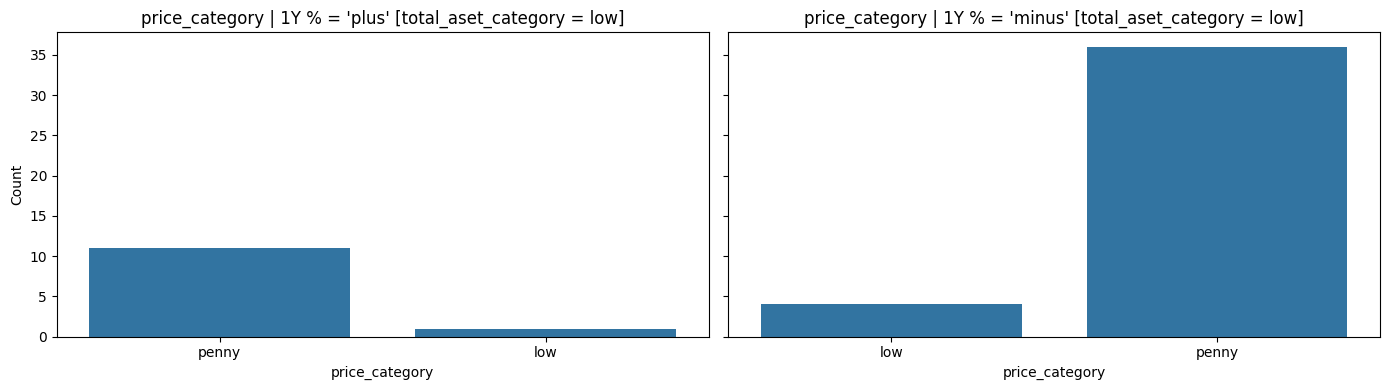

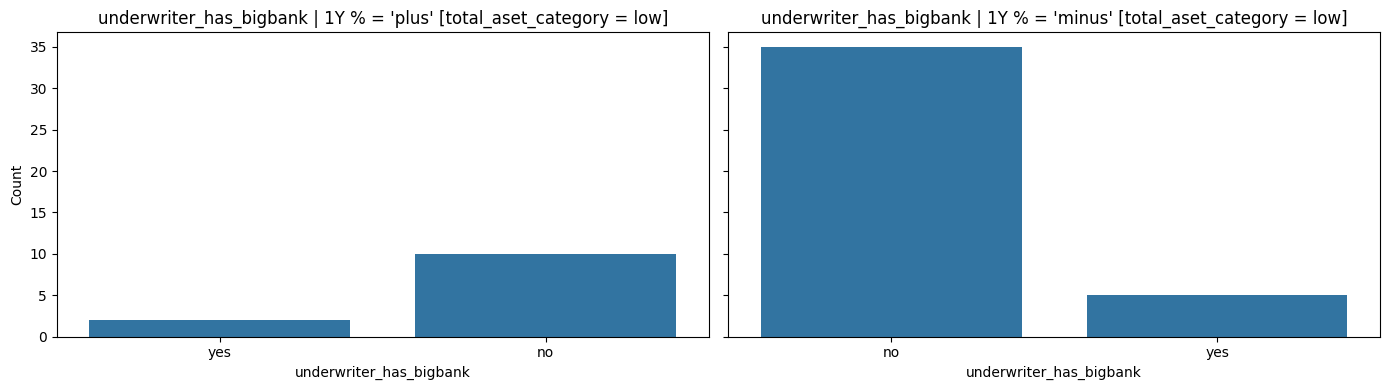

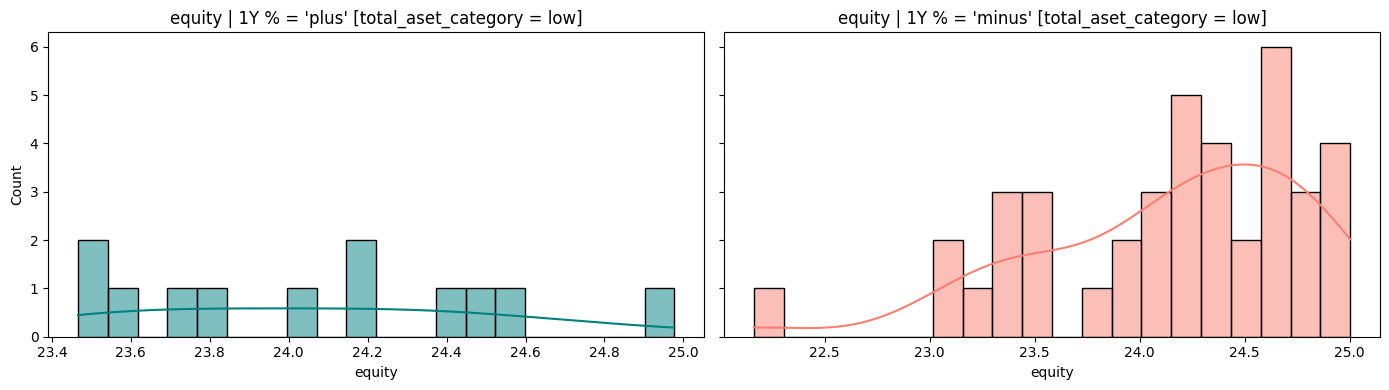

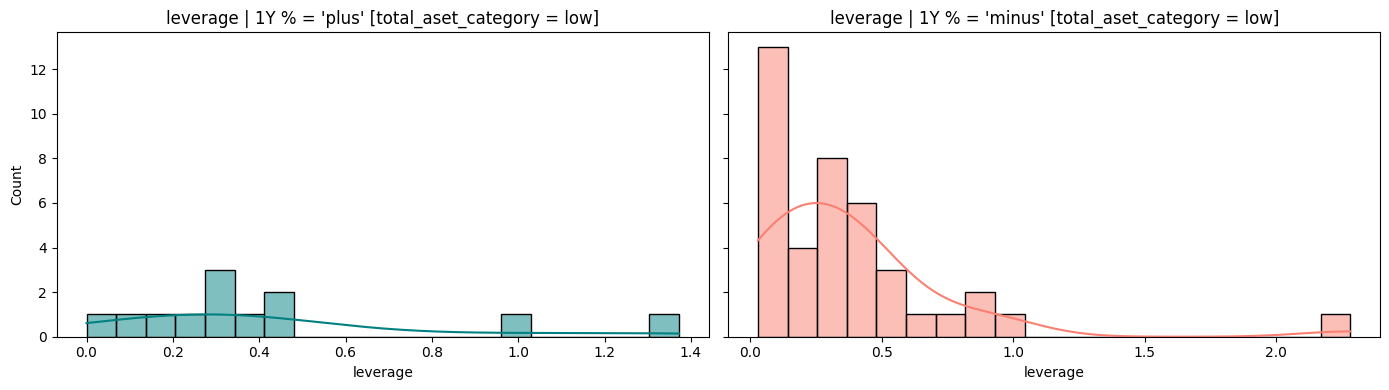

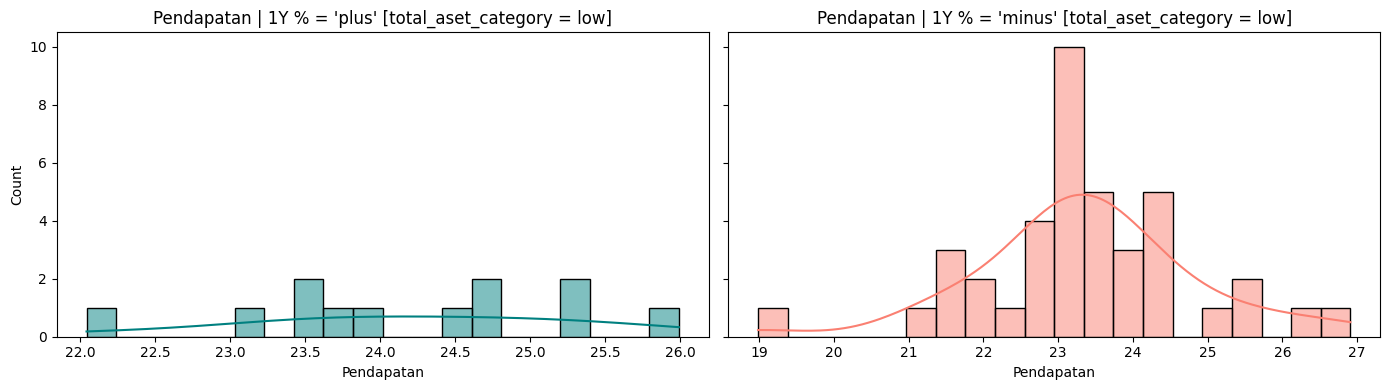

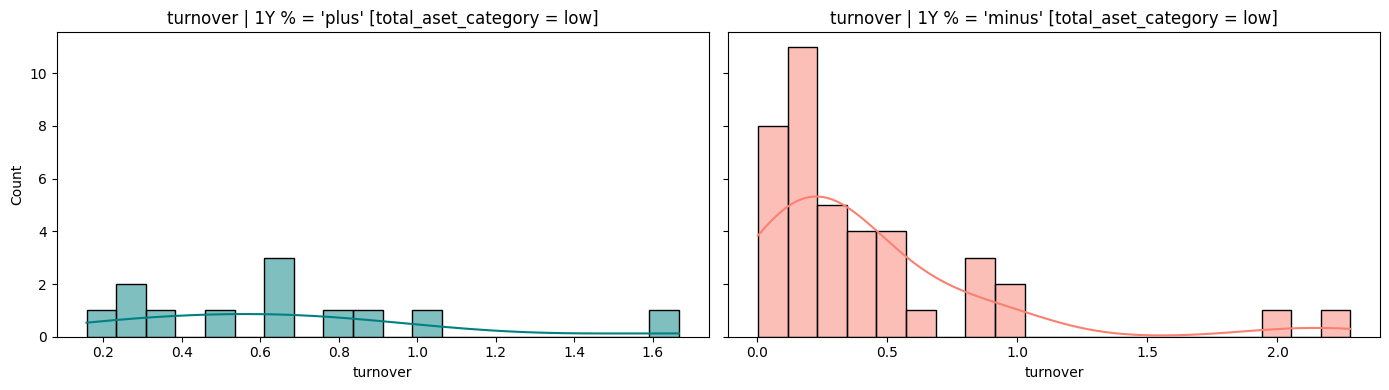

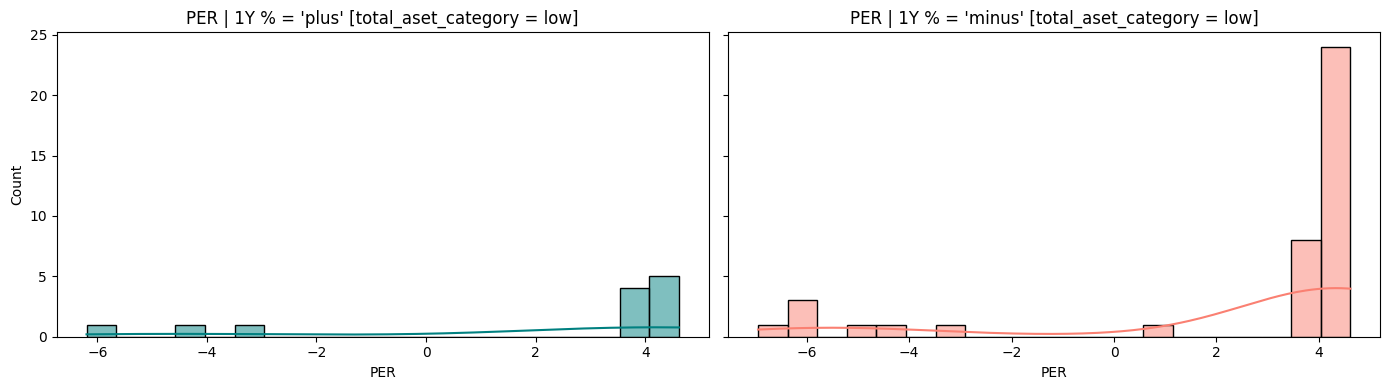

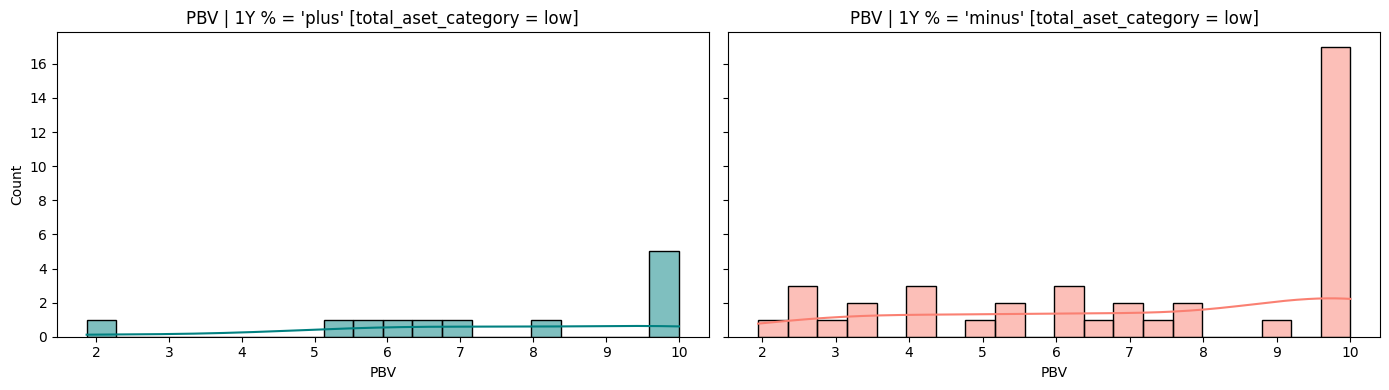

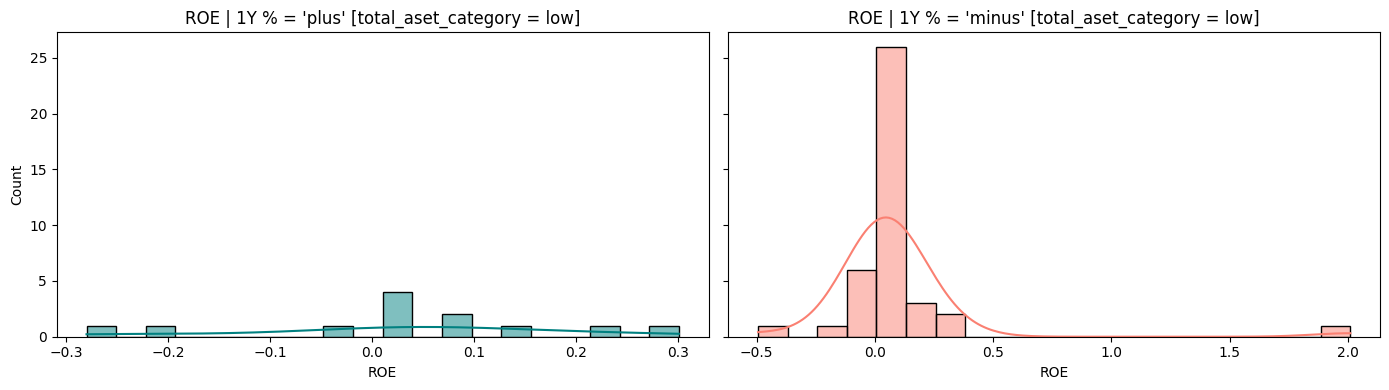

In [185]:
features = [
    ('Ownership', 'ownership'),
    ('Papan Pencatatan', 'papan_pencatatan'),
    ('price_category', 'price_cat'),
    ('underwriter_has_bigbank', 'underwriter_has_bigbank'),
    ('equity', 'equity'),
    ('leverage', 'leverage_ratio'),
    ('Pendapatan', 'revenue'),
    ('turnover', 'turnover_ratio'),
    ('PER', 'per'),
    ('PBV', 'pbv'),
    ('ROE', 'roe'),
]

target = '1Y %'
success_val = 'plus'

numerical_feats = ['equity', 'leverage', 'Pendapatan', 'turnover', 'PER', 'PBV', 'ROE']

for feat, _ in features:
    if feat in numerical_feats:
        fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)
        for i, label in enumerate(['plus', 'minus']):
            mask = (df['total_aset_category'] == 'low') & (df[target].isin(['plus', 'minus']))
            sns.histplot(
                df.loc[mask & (df[target] == label), feat],
                ax=axes[i],
                kde=True,
                bins=20,
                color='teal' if label == 'plus' else 'salmon'
            )
            axes[i].set_title(f"{feat} | {target} = '{label}' [total_aset_category = low]")
            axes[i].set_xlabel(feat)
            axes[i].set_ylabel('Count')
        plt.tight_layout()
        plt.show()
    else:
        fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)
        for i, label in enumerate(['plus', 'minus']):
            mask = (df['total_aset_category'] == 'low') & (df[target].isin(['plus', 'minus']))
            sns.countplot(
                x=df.loc[mask & (df[target] == label), feat],
                ax=axes[i],
            )
            axes[i].set_title(f"{feat} | {target} = '{label}' [total_aset_category = low]")
            axes[i].set_xlabel(feat)
            axes[i].set_ylabel('Count')
        plt.tight_layout()
        plt.show()


## Encoding

In [186]:
df = df.drop('Ticker', axis = 1)
df = df.drop('Nama Perusahaan', axis = 1)

In [187]:
categorical_cols = df.select_dtypes(include='object').drop(columns=['Underwriter'])
for col in categorical_cols:
    if col != 'Underwriter' and col != 'lead_underwriter':
        print(f"{col}:")
        print(df[col].unique())
        print('-' * 40)

Sektor:
['Energy' 'Basic Materials' 'Financials' 'Healthcare' 'Technology'
 'Transportation & Logistic' 'Consumer Non-Cyclicals' 'Industrials'
 'Consumer Cyclicals' 'Infrastructures' 'Properties & Real Estate']
----------------------------------------
Papan Pencatatan:
['utama' 'pengembangan' 'pemantauan khusus' 'akselerasi' 'ekonomi baru']
----------------------------------------
Ownership:
['lainnya' 'konglomerat' 'start up' 'bumn']
----------------------------------------
1D %:
['ARA' 'plus' 'minus']
----------------------------------------
1W %:
['good' 'bad']
----------------------------------------
1M %:
['good' 'bad' nan]
----------------------------------------
6M %:
['minus' 'plus' nan]
----------------------------------------
1Y %:
['minus' 'plus' nan]
----------------------------------------
underwriter_freq_category:
['high' 'mid' 'low']
----------------------------------------
underwriter_avg_aset_category:
['low' 'high' 'mid']
----------------------------------------
unde

In [188]:
df['price_category'].value_counts()

price_category
penny      152
low         44
medium      22
high         4
premium      1
Name: count, dtype: int64

In [189]:
manual_orders = {
    'Papan Pencatatan': ['utama', 'pengembangan', 'akselerasi', 'ekonomi baru', 'pemantauan khusus'],
    'Ownership': ['bumn', 'konglomerat', 'start up', 'lainnya'],
    'underwriter_freq_category': ['low', 'mid', 'high'],
    'underwriter_avg_aset_category': ['low', 'mid', 'high'],
    'Listing Quartal': ['I', 'II', 'III', 'IV'],
    'total_aset_category': ['low', 'mid', 'high'],
    'price_category': ['penny', 'low', 'medium', 'high', 'premium'],
    'underwriter_highest_short_rep' : ['gamma', 'beta', 'alpha'],
    'underwriter_highest_mid_rep' : ['gamma', 'beta', 'alpha'],
    'underwriter_highest_long_rep' : ['gamma', 'beta', 'alpha'],
    'underwriter_has_bigbank' : ['no', 'yes']
}

label_encoders = {}
encoded_mappings = {}

for col in categorical_cols:
    if col in manual_orders:
        mapping = {v: i for i, v in enumerate(manual_orders[col])}
        df[col] = df[col].map(lambda x: mapping[x] if pd.notna(x) else np.nan)
        encoded_mappings[col] = mapping
        label_encoders[col] = 'manual'
    else:
        le = LabelEncoder()
        df[col] = df[col].astype("str")
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le
        encoded_mappings[col] = dict(zip(le.classes_, le.transform(le.classes_)))

    df[col] = pd.to_numeric(df[col], errors='coerce')

Encoding dilakukan secara manual berdasarkan urutan ordinal yang sudah ditentukan.

In [190]:
for col, mapping in encoded_mappings.items():
    print(f"{col}: {mapping}")

Sektor: {'Basic Materials': 0, 'Consumer Cyclicals': 1, 'Consumer Non-Cyclicals': 2, 'Energy': 3, 'Financials': 4, 'Healthcare': 5, 'Industrials': 6, 'Infrastructures': 7, 'Properties & Real Estate': 8, 'Technology': 9, 'Transportation & Logistic': 10}
Papan Pencatatan: {'utama': 0, 'pengembangan': 1, 'akselerasi': 2, 'ekonomi baru': 3, 'pemantauan khusus': 4}
Ownership: {'bumn': 0, 'konglomerat': 1, 'start up': 2, 'lainnya': 3}
1D %: {'ARA': 0, 'minus': 1, 'plus': 2}
1W %: {'bad': 0, 'good': 1}
1M %: {'bad': 0, 'good': 1, 'nan': 2}
6M %: {'minus': 0, 'nan': 1, 'plus': 2}
1Y %: {'minus': 0, 'nan': 1, 'plus': 2}
lead_underwriter: {'PT Aartha Sekuritas Indonesia': 0, 'PT Artha Sekuritas Indonesia': 1, 'PT BCA Sekuritas': 2, 'PT BNI Sekuritas': 3, 'PT BNP Paribas Securities Indonesia': 4, 'PT BRI Danareksa Sekuritas': 5, 'PT Binaartha Sekuritas': 6, 'PT Buana Capital Sekuritas': 7, 'PT CIMB Niaga Sekuritas': 8, 'PT CLSA Sekuritas Indonesia': 9, 'PT Ciptadana Sekuritas Asia': 10, 'PT Danat

## Correlation

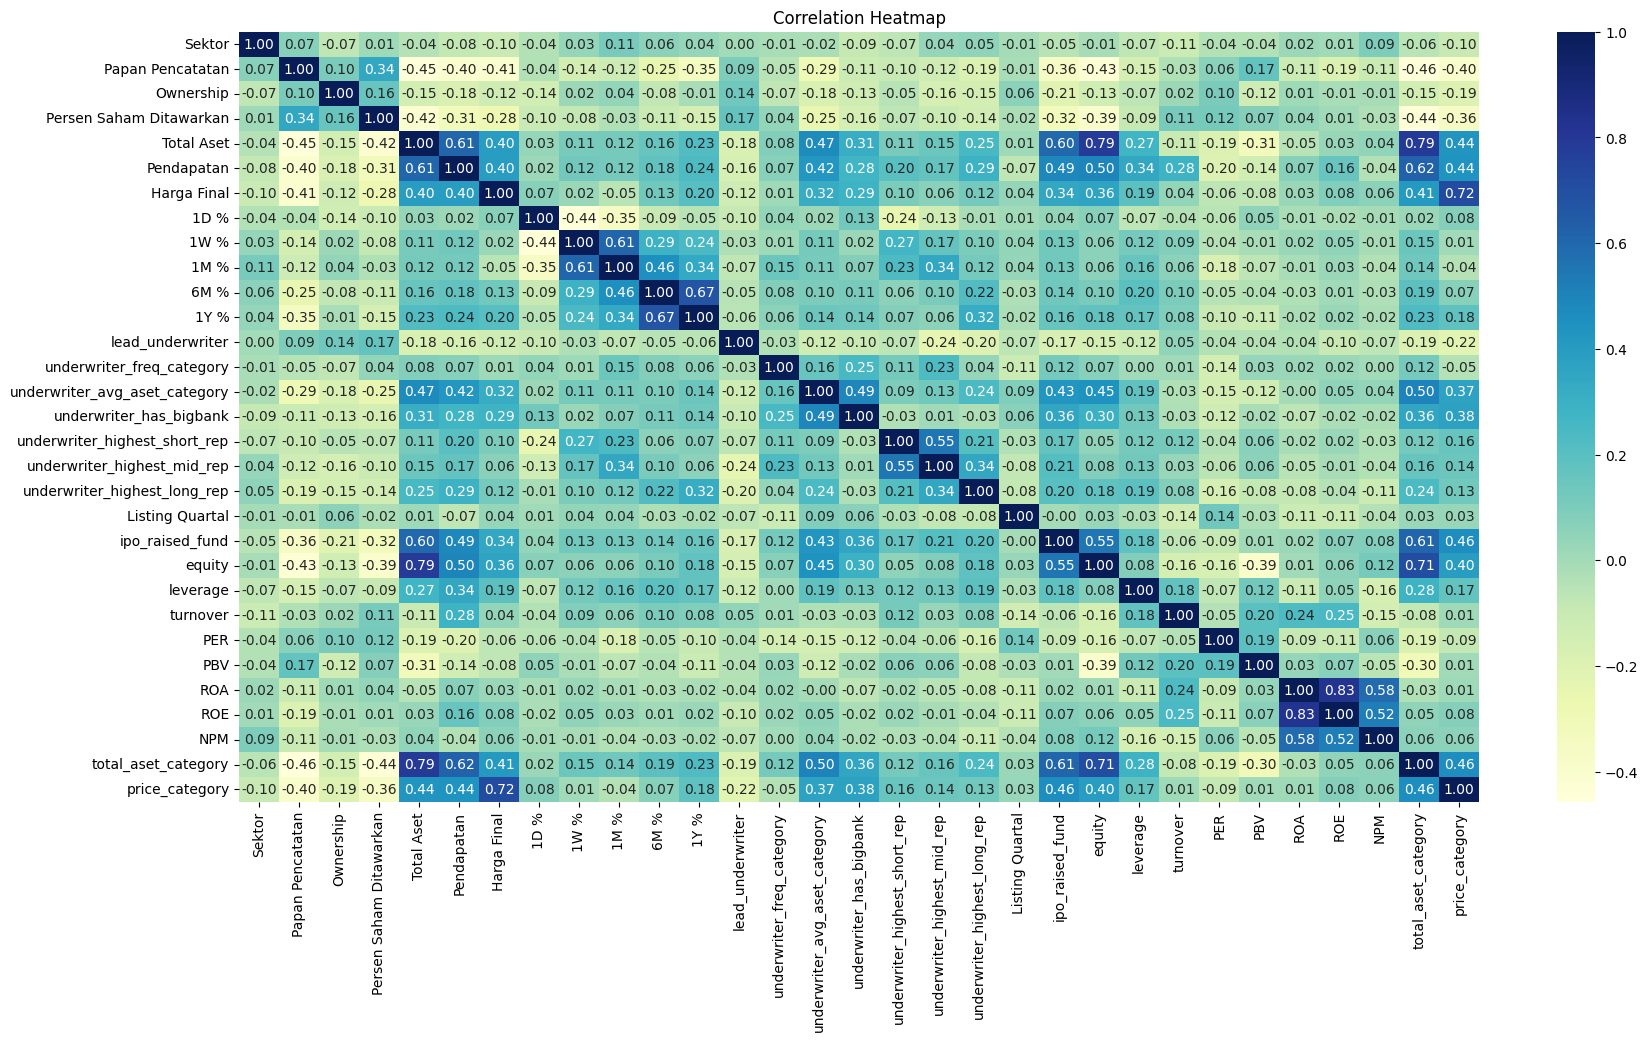

In [191]:
corr_df = df.drop(columns=['Underwriter'])
corr_matrix = corr_df.corr(method='kendall')

plt.figure(figsize=(20, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='YlGnBu', cbar=True)
plt.title('Correlation Heatmap')
plt.show()

## Final Columns

In [192]:
df.columns

Index(['Sektor', 'Underwriter', 'Papan Pencatatan', 'Ownership',
       'Persen Saham Ditawarkan', 'Total Aset', 'Pendapatan', 'Harga Final',
       '1D %', '1W %', '1M %', '6M %', '1Y %', 'lead_underwriter',
       'underwriter_freq_category', 'underwriter_avg_aset_category',
       'underwriter_has_bigbank', 'underwriter_highest_short_rep',
       'underwriter_highest_mid_rep', 'underwriter_highest_long_rep',
       'Listing Quartal', 'ipo_raised_fund', 'equity', 'leverage', 'turnover',
       'PER', 'PBV', 'ROA', 'ROE', 'NPM', 'total_aset_category',
       'price_category'],
      dtype='object')

In [193]:
custom_columns = [
    ('Ownership', 'ownership'),
    ('Papan Pencatatan', 'papan_pencatatan'),
    ('ipo_raised_fund', 'ipo_raised_fund'),
    ('Persen Saham Ditawarkan', 'float'),
    ('price_category', 'price_cat'),

    ('lead_underwriter', 'lead_underwriter'),
    ('underwriter_freq_category', 'underwriter_freq_cat'),
    ('underwriter_avg_aset_category', 'underwriter_avg_aset_cat'),
    ('underwriter_highest_short_rep', 'underwriter_highest_short_rep'),
    ('underwriter_highest_mid_rep', 'underwriter_highest_mid_rep'),
    ('underwriter_highest_long_rep', 'underwriter_highest_long_rep'),
    ('underwriter_has_bigbank', 'underwriter_has_bigbank'),

    ('total_aset_category', 'total_aset_cat'),
    ('equity', 'equity'),
    ('leverage', 'leverage_ratio'),
    ('Pendapatan', 'revenue'),
    ('turnover', 'turnover_ratio'),
    ('PER', 'per'),
    ('PBV', 'pbv'),
    ('ROE', 'roe'),

    ('1D %', '1d'),
    ('1W %', '1w'),
    ('1M %', '1m'),
    ('6M %', '6m'),
    ('1Y %', '1y'),
]

orig_cols, new_names = zip(*custom_columns)

df_custom = df[list(orig_cols)].copy()
df_custom.columns = new_names

df_custom.head()

ownership  papan_pencatatan  ipo_raised_fund   float  price_cat  \
0          3                 0        24.290267  0.0956          0   
1          1                 1        28.658473  0.1500          2   
2          3                 4        27.150335  0.1500          3   
3          1                 0        26.081580  0.0726          1   
4          3                 1        24.635289  0.2500          0   

   lead_underwriter  underwriter_freq_cat  underwriter_avg_aset_cat  \
0                38                     2                         0   
1                 3                     2                         2   
2                 2                     1                         1   
3                10                     2                         1   
4                38                     2                         1   

   underwriter_highest_short_rep  underwriter_highest_mid_rep  ...    revenue  \
0                              2                            2  ...  26.325385   
1                              1                            1  ...  29.232427   
2                              2                            0  ...  27.821641   
3                              2                            2  ...  27.770783   
4                              2                            2  ...  25.991124   

   turnover_ratio       per       pbv       roe  1d  1w  1m  6m  1y  
0        0.406699 -4.203837  1.356777 -0.020366   0   1   1   0   0  
1        0.435836  2.602752  8.390203  0.513525   2   0   0   0   0  
2        0.054752  3.667919  2.169681  0.055285   0   0   0   2   2  
3        0.426840  3.249968  2.785868  0.106503   0   1   1   2   2  
4        1.666251  4.615121  6.485393  0.017470   0   1   1   2   2  

[5 rows x 25 columns]

In [194]:
df_custom.to_csv('processed-ipo-data.csv', index=False)

## Installations

In [67]:
%%capture

!pip install tabpfn

In [68]:
%%capture

!pip install lime

In [69]:
%%capture

!pip install pytorch-tabnet

## Feature Selections

In [70]:
df_custom.head()

ownership  papan_pencatatan  ipo_raised_fund   float  price_cat  \
0          3                 0        24.290267  0.0956          0   
1          1                 1        28.658473  0.1500          2   
2          3                 4        27.150335  0.1500          3   
3          1                 0        26.081580  0.0726          1   
4          3                 1        24.635289  0.2500          0   

   lead_underwriter  underwriter_freq_cat  underwriter_avg_aset_cat  \
0                38                     2                         0   
1                 3                     2                         2   
2                 2                     1                         1   
3                10                     2                         1   
4                38                     2                         1   

   underwriter_highest_short_rep  underwriter_highest_mid_rep  ...    revenue  \
0                              2                            2  ...  26.325385   
1                              1                            1  ...  29.232427   
2                              2                            0  ...  27.821641   
3                              2                            2  ...  27.770783   
4                              2                            2  ...  25.991124   

   turnover_ratio       per       pbv       roe  1d  1w  1m  6m  1y  
0        0.406699 -4.203837  1.356777 -0.020366   0   1   1   0   0  
1        0.435836  2.602752  8.390203  0.513525   2   0   0   0   0  
2        0.054752  3.667919  2.169681  0.055285   0   0   0   2   2  
3        0.426840  3.249968  2.785868  0.106503   0   1   1   2   2  
4        1.666251  4.615121  6.485393  0.017470   0   1   1   2   2  

[5 rows x 25 columns]

In [71]:
from typing import List, Dict

def select_features_by_kendall(
    df: pd.DataFrame,
    target_cols: List[str],
    threshold: float = 0.075,
    max_features: int = 8,
    corr_cutoff: float = 0.7
) -> Dict[str, List[str]]:
    """
    Memilih fitur terbaik untuk setiap kolom target berdasarkan korelasi Kendall,
    sambil mengontrol multikolinearitas.

    Args:
        df (pd.DataFrame): DataFrame input yang berisi fitur dan target.
        target_cols (List[str]): Daftar nama kolom target.
        threshold (float): Nilai absolut korelasi Kendall minimum antara fitur dan target.
        max_features (int): Jumlah maksimum fitur yang akan dipilih untuk setiap target.
        corr_cutoff (float): Batas korelasi absolut maksimum yang diizinkan antar fitur terpilih.

    Returns:
        Dict[str, List[str]]: Dictionary dengan key nama kolom target dan value list nama fitur terpilih.
    """

    try:
        corr_matrix = df.corr(method="kendall")
    except TypeError:
        print("Error: Pastikan semua kolom dalam DataFrame numerik untuk menghitung korelasi.")
        df_numeric = df.apply(pd.to_numeric, errors='coerce').dropna(axis=1)
        corr_matrix = df_numeric.corr(method="kendall")
        print("Melanjutkan dengan kolom numerik yang valid...")


    all_potential_features = [col for col in corr_matrix.columns if col not in target_cols]
    selected_features_per_target = {}

    for target in target_cols:
        if target not in corr_matrix.columns:
            print(f"Peringatan: Kolom target '{target}' tidak ada di DataFrame. Dilewati.")
            continue

        target_corr = corr_matrix.loc[all_potential_features, target]

        top_features = target_corr[abs(target_corr) >= threshold].abs().sort_values(ascending=False)

        selected = []
        for feature in top_features.index:
            if len(selected) >= max_features:
                break
            if selected:
                correlations_with_selected = corr_matrix.loc[feature, selected].abs()
                if correlations_with_selected.max() > corr_cutoff:
                    continue
            selected.append(feature)
        selected_features_per_target[target] = selected
    return selected_features_per_target

In [72]:
targets = ["1d", "1w", "1m", "6m", "1y"]

selected_features = select_features_by_kendall(df_custom, targets)

features_to_use = {}

for target, features in selected_features.items():
    print(f"Target: {target} -> Features: {features}")
    features_to_use[target] = features

Target: 1d -> Features: ['underwriter_highest_short_rep', 'ownership', 'underwriter_has_bigbank', 'underwriter_highest_mid_rep', 'float', 'lead_underwriter', 'price_cat']
Target: 1w -> Features: ['underwriter_highest_short_rep', 'underwriter_highest_mid_rep', 'total_aset_cat', 'papan_pencatatan', 'ipo_raised_fund', 'revenue', 'leverage_ratio', 'underwriter_avg_aset_cat']
Target: 1m -> Features: ['underwriter_highest_mid_rep', 'underwriter_highest_short_rep', 'per', 'leverage_ratio', 'underwriter_freq_cat', 'total_aset_cat', 'ipo_raised_fund', 'revenue']
Target: 6m -> Features: ['papan_pencatatan', 'underwriter_highest_long_rep', 'leverage_ratio', 'total_aset_cat', 'revenue', 'ipo_raised_fund', 'float', 'underwriter_has_bigbank']
Target: 1y -> Features: ['papan_pencatatan', 'underwriter_highest_long_rep', 'revenue', 'total_aset_cat', 'price_cat', 'leverage_ratio', 'ipo_raised_fund', 'float']


## XAI (Explanations Function with LIME)

In [73]:
from lime.lime_tabular import LimeTabularExplainer

def explain_with_lime(model, X_train, X_test, feature_names, class_names):
    explainer = LimeTabularExplainer(
        training_data=X_train.values,
        feature_names=feature_names,
        class_names=class_names,
        mode='classification',
        discretize_continuous=True
    )

    sample = X_test.iloc[0].values
    explanation = explainer.explain_instance(sample, model.predict_proba, num_features=len(feature_names))

    explanation.show_in_notebook(show_table=True)
    explanation.as_pyplot_figure()
    plt.tight_layout()
    plt.show()

In [74]:
def explain_multiclass_with_lime(model, X_train, X_test, feature_names, class_names):
    explainer = LimeTabularExplainer(
        training_data=X_train.values,
        feature_names=feature_names,
        class_names=class_names,
        mode='classification',
        discretize_continuous=True
    )

    sample = X_test.iloc[0].values

    num_classes = len(class_names)

    explanation = explainer.explain_instance(
        sample,
        model.predict_proba,
        num_features=len(feature_names),
        labels=range(num_classes)
    )

    explanation.show_in_notebook(show_table=True)
    for i in range(num_classes):
        print(f"\nPenjelasan untuk Kelas: {class_names[i]}")
        fig = explanation.as_pyplot_figure(label=i)
        plt.tight_layout()
        plt.show()

In [75]:
def explain_and_save_lime_pngs(
    model,
    X_train,
    X_test,
    feature_names,
    class_names,
    sample_index=0,
    filename_prefix="lime_explanation"
):
    print(f"Membuat penjelasan LIME untuk sampel ke-{sample_index}...")

    explainer = LimeTabularExplainer(
        training_data=X_train,
        feature_names=feature_names,
        class_names=class_names,
        mode='classification',
        discretize_continuous=True
    )

    sample = X_test[sample_index]
    num_classes = len(class_names)

    explanation = explainer.explain_instance(
        sample,
        model.predict_proba,
        num_features=len(feature_names),
        labels=range(num_classes)
    )

    for i in range(num_classes):
        class_name = class_names[i]

        fig = explanation.as_pyplot_figure(label=i)
        fig.suptitle(f"LIME Plot untuk Kelas: '{class_name}'", fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])

        plot_filename = f"{filename_prefix}_sampel_{sample_index}_kelas_{class_name}_plot.png"
        fig.savefig(plot_filename, bbox_inches='tight')
        plt.close(fig)
        print(f"-> Plot untuk kelas '{class_name}' berhasil disimpan ke: {plot_filename}")

        exp_list = explanation.as_list(label=i)
        df_exp = pd.DataFrame(exp_list, columns=['Fitur & Aturan', 'Kontribusi'])

        fig, ax = plt.subplots(figsize=(8, 4))
        ax.axis('tight')
        ax.axis('off')
        table = ax.table(
            cellText=df_exp.values,
            colLabels=df_exp.columns,
            loc='center',
            cellLoc='left'
        )
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1.2, 1.2)

        fig.suptitle(f"Tabel Penjelasan untuk Kelas: '{class_name}'", fontsize=16)

        table_filename = f"{filename_prefix}_sampel_{sample_index}_kelas_{class_name}_tabel.png"
        fig.savefig(table_filename, bbox_inches='tight', pad_inches=0.5)
        plt.close(fig)
        print(f"-> Tabel untuk kelas '{class_name}' berhasil disimpan ke: {table_filename}")

    print(f"\n✅ Semua file PNG berhasil dibuat.")

In [76]:
def generate_lime_report(
    model,
    X_train_df,
    X_test_df,
    sample_index,
    categorical_cols,
    encoder,
    class_names,
    save_to_png=False,
    filename_prefix="lime_report",
    output_dir="None"
):
    """
    Membuat penjelasan LIME, dengan opsi untuk menyimpan hasilnya ke direktori tertentu.
    """
    feature_names = X_train_df.columns.tolist()
    categorical_idx = [feature_names.index(col) for col in categorical_cols]
    categorical_names = {i: encoder.categories_[cat_idx] for cat_idx, i in enumerate(categorical_idx)}
    explainer = LimeTabularExplainer(
        training_data=X_train_df.values, feature_names=feature_names,
        class_names=class_names, mode='classification',
        categorical_features=categorical_idx, categorical_names=categorical_names
    )
    sample = X_test_df.iloc[sample_index].values
    num_classes = len(class_names)
    explanation = explainer.explain_instance(
        sample, model.predict_proba,
        num_features=len(feature_names), labels=range(num_classes)
    )

    if not save_to_png:
        explanation.show_in_notebook(show_table=True)
        for i in range(num_classes):
            print(f"\nPenjelasan untuk Kelas: {class_names[i]}")
            fig = explanation.as_pyplot_figure(label=i)
            plt.tight_layout()
            plt.show()
    else:
        if output_dir:
            os.makedirs(output_dir, exist_ok=True)
            print(f"\nMenyimpan file ke direktori: '{output_dir}'")
        else:
            print("\nMenyimpan file ke direktori saat ini.")

        for i in range(num_classes):
            class_name = class_names[i]
            base_filename = f"{filename_prefix}_sampel_{sample_index}_kelas_{class_name}"

            # 2. Buat path file yang lengkap
            plot_filename = f"{base_filename}_plot.png"
            table_filename = f"{base_filename}_tabel.png"
            
            if output_dir:
                plot_filename = os.path.join(output_dir, plot_filename)
                table_filename = os.path.join(output_dir, table_filename)

            fig_plot = explanation.as_pyplot_figure(label=i)
            fig_plot.suptitle(f"LIME Plot untuk Kelas: '{class_name}'", fontsize=16)
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            fig_plot.savefig(plot_filename, bbox_inches='tight')
            plt.close(fig_plot)

            exp_list = explanation.as_list(label=i)
            df_exp = pd.DataFrame(exp_list, columns=['Fitur & Aturan', 'Kontribusi'])
            fig_table, ax = plt.subplots(figsize=(8, max(4, len(df_exp) * 0.4)))
            ax.axis('tight'); ax.axis('off')
            table = ax.table(cellText=df_exp.values, colLabels=df_exp.columns, loc='center', cellLoc='left')
            table.auto_set_font_size(False); table.set_fontsize(10); table.scale(1.2, 1.2)
            fig_table.suptitle(f"Tabel Penjelasan untuk Kelas: '{class_name}'", fontsize=16)
            fig_table.savefig(table_filename, bbox_inches='tight', pad_inches=0.5)
            plt.close(fig_table)

## Training

### 1Y %

In [77]:
df_custom['1y'].value_counts()

1y
0    119
2     74
1     30
Name: count, dtype: int64

- Penghapusan label 1 yang dianggap sebagai NaN.

In [78]:
X = df_custom[features_to_use['1y']].copy()
y = df_custom['1y'].copy()

X = X[y != 1]
y = y[y != 1]

y = y.replace({2: 1})

- Data Splitting (80:20)

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=5)

- Feature Importances Analysis

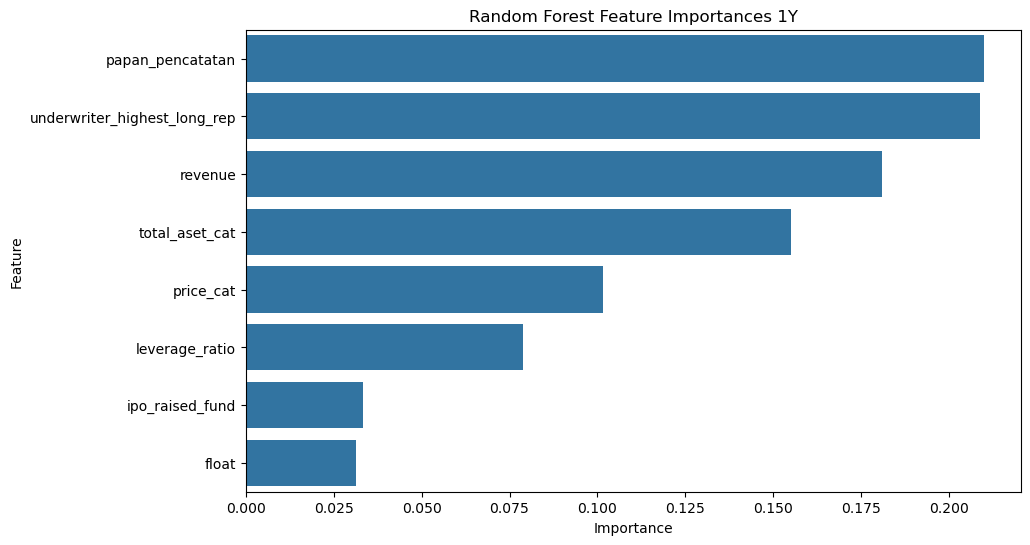

In [80]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)

rf.fit(X_train, y_train)

importances = rf.feature_importances_
importances = pd.Series(importances, index=X_train.columns)
importances.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=features_to_use['1y'])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Random Forest Feature Importances 1Y")
plt.show()

#### TabPFN

In [81]:
import torch
from tabpfn import TabPFNClassifier

clf = TabPFNClassifier(device="cuda" if torch.cuda.is_available() else "cpu")

clf.fit(X_train, y_train)

TabPFNClassifier(device='cpu')

In [82]:
y_pred = clf.predict(X_test)

- Penentuan threshold untuk hasil yang lebih balance.

In [83]:
thresholds = np.arange(0.3, 0.61, 0.01)
f1_scores = []

probs = cross_val_predict(
    clf,
    X, y,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    method='predict_proba'
)[:, 1]

for t in thresholds:
    preds = (probs >= t).astype(int)
    score = f1_score(y, preds, average='macro')
    f1_scores.append(score)

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Best Threshold: {best_threshold:.2f}")
print(f"Best F1 Macro Score: {best_f1:.4f}")

Best Threshold: 0.41
Best F1 Macro Score: 0.7028


- Classification Report & Confusion Matrix

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83        24
           1       0.73      0.73      0.73        15

    accuracy                           0.79        39
   macro avg       0.78      0.78      0.78        39
weighted avg       0.79      0.79      0.79        39



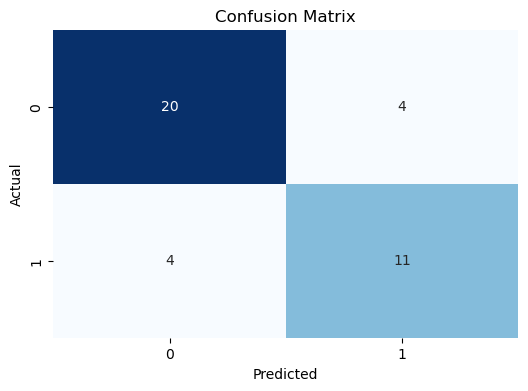

In [84]:
probs = clf.predict_proba(X_test)[:, 1]
y_pred = (probs > best_threshold).astype(int)

print("Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

- K-Fold Cross Validation

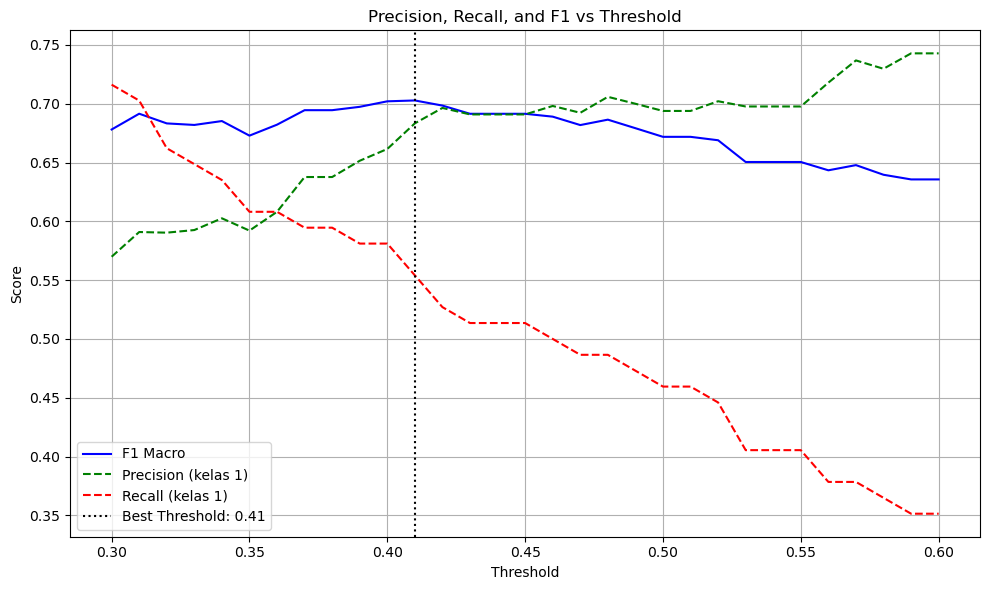

In [85]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
probs = cross_val_predict(
    clf,
    X, y,
    cv=cv,
    method='predict_proba'
)[:, 1]

f1_scores = []
precisions = []
recalls = []

for t in thresholds:
    preds = (probs >= t).astype(int)
    f1_scores.append(f1_score(y, preds, average='macro'))
    precisions.append(precision_score(y, preds))
    recalls.append(recall_score(y, preds))

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1 Macro', color='blue')
plt.plot(thresholds, precisions, label='Precision (kelas 1)', linestyle='--', color='green')
plt.plot(thresholds, recalls, label='Recall (kelas 1)', linestyle='--', color='red')
plt.axvline(best_threshold, linestyle=':', color='black', label=f'Best Threshold: {best_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 vs Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- Final Results (TabPFN)

F1 Score (threshold=0.4100000000000001): 0.7028
Accuracy: 0.7305699481865285
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.84      0.79       119
           1       0.68      0.55      0.61        74

    accuracy                           0.73       193
   macro avg       0.72      0.70      0.70       193
weighted avg       0.73      0.73      0.72       193



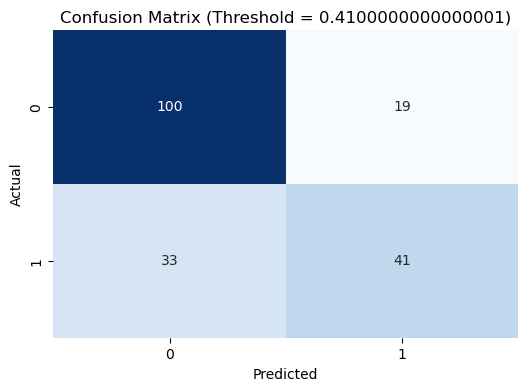

In [86]:
threshold = best_threshold
preds = (probs >= threshold).astype(int)

cm = confusion_matrix(y, preds)
print(f"F1 Score (threshold={threshold}): {f1_score(y, preds, average='macro'):.4f}")
print(f"Accuracy: {accuracy_score(y, preds)}")
print(f"Classification Report:\n{classification_report(y, preds)}")

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (Threshold = {threshold})')
plt.show()

- Save to Pickle

In [87]:
import joblib

with open('./model/1Y/tabPFN_1Y.pkl', 'wb') as f:
    joblib.dump(clf, f)

#### Tabnet

- Features to use for 1Y label

In [88]:
features_to_use['1y']

['papan_pencatatan',
 'underwriter_highest_long_rep',
 'revenue',
 'total_aset_cat',
 'price_cat',
 'leverage_ratio',
 'ipo_raised_fund',
 'float']

- Separating Categorical and Numerical Columns

In [89]:
def is_categorical(df: pd.DataFrame, column: str) -> bool:
    if df[column].dtype == 'object':
      return True

    if pd.api.types.is_numeric_dtype(df[column]):
      unique_count = df[column].nunique()
      total_count = len(df[column])
      if total_count > 0 and (unique_count / total_count) < 0.2:
        return True

    return False

In [90]:
categorical_cols = []
numerical_cols = []

cols_to_ignore = ['1d', '1w', '1m', '6m', '1y']

for col in features_to_use['1y']:
    if col in cols_to_ignore:
        continue

    if is_categorical(df_custom, col):
        categorical_cols.append(col)
    else:
        numerical_cols.append(col)

In [91]:
categorical_cols

['papan_pencatatan',
 'underwriter_highest_long_rep',
 'total_aset_cat',
 'price_cat']

In [92]:
numerical_cols

['revenue', 'leverage_ratio', 'ipo_raised_fund', 'float']

- Data Splitting (80:20)

In [93]:
df_tabnet = df_custom[df_custom['1y'] != 1].copy()

X = df_tabnet[features_to_use['1y']].copy()
y = df_tabnet['1y'].astype(int).values

y[y == 2] = 1

encoder = OrdinalEncoder()
X[categorical_cols] = encoder.fit_transform(X[categorical_cols])
X = X.values.astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

- Training

In [94]:
from pytorch_tabnet.tab_model import TabNetClassifier

tabnet_clf = TabNetClassifier(
    n_d=16,
    n_a=16,
    n_steps=5,
    gamma=1.5,
    lambda_sparse=0.0001,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"mode": "min", "patience": 5, "factor": 0.5},
    scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
    seed=42,
    verbose=10,
)

tabnet_clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_test, y_test)],
    eval_name=["val"],
    eval_metric=["balanced_accuracy"],
    max_epochs=200,
    patience=20,
    batch_size=16
)

epoch 0  | loss: 1.09742 | val_balanced_accuracy: 0.5     |  0:00:00s
epoch 10 | loss: 0.71334 | val_balanced_accuracy: 0.62083 |  0:00:02s
epoch 20 | loss: 0.5666  | val_balanced_accuracy: 0.70833 |  0:00:05s
epoch 30 | loss: 0.4852  | val_balanced_accuracy: 0.72917 |  0:00:07s

Early stopping occurred at epoch 38 with best_epoch = 18 and best_val_balanced_accuracy = 0.79583


- Final Results

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.79      0.83        24
           1       0.71      0.80      0.75        15

    accuracy                           0.79        39
   macro avg       0.78      0.80      0.79        39
weighted avg       0.80      0.79      0.80        39



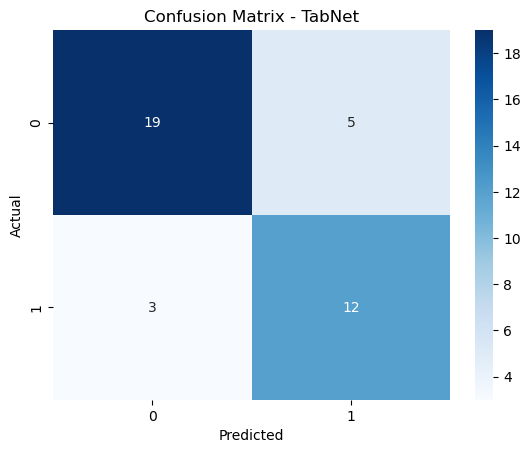

In [95]:
y_pred = tabnet_clf.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - TabNet')
plt.show()

- Feature Importances

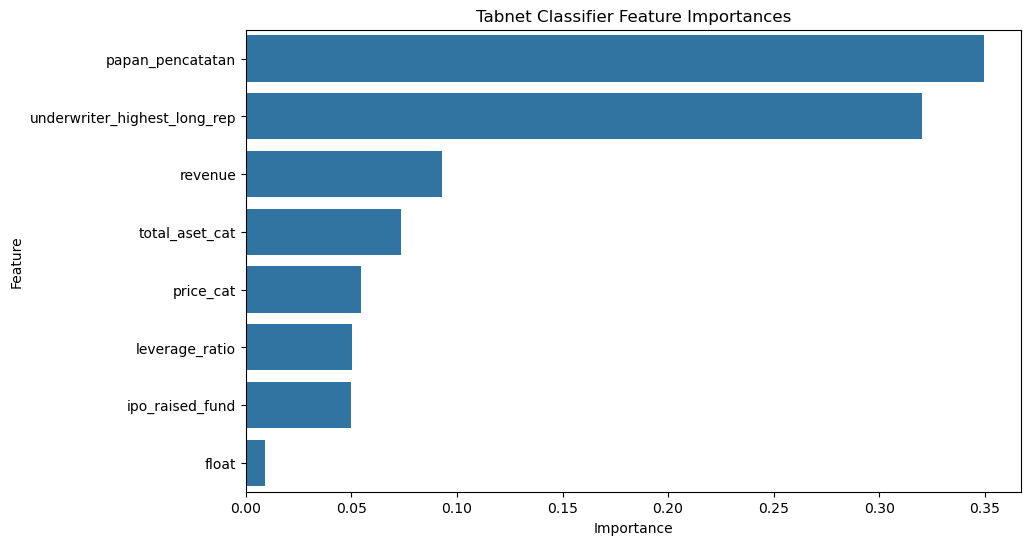

In [96]:
importances = tabnet_clf.feature_importances_
importances = pd.Series(importances)
importances.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=features_to_use['1y'])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Tabnet Classifier Feature Importances")
plt.show()

- K-Fold Cross Validations

In [97]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler

X[:, -len(numerical_cols):] = StandardScaler().fit_transform(X[:, -len(numerical_cols):])

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_preds = []
y_true = []

for train_idx, test_idx in cv.split(X_resampled, y_resampled):
    X_tr, X_te = X_resampled[train_idx], X_resampled[test_idx]
    y_tr, y_te = y_resampled[train_idx], y_resampled[test_idx]

    model = TabNetClassifier(
        n_d=16,
        n_a=16,
        n_steps=5,
        gamma=1.5,
        lambda_sparse=0.0001,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=2e-2),
        scheduler_params={"mode": "min", "patience": 5, "factor": 0.5},
        scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
        seed=42,
        verbose=10,
    )

    model.fit(
        X_train=X_tr, y_train=y_tr,
        eval_set=[(X_te, y_te)],
        eval_name=["val"],
        eval_metric=["balanced_accuracy"],
        batch_size=16,
    )

    y_preds.extend(model.predict(X_te))
    y_true.extend(y_te)

print(classification_report(y_true, y_preds))

epoch 0  | loss: 1.23823 | val_balanced_accuracy: 0.45833 |  0:00:00s
epoch 10 | loss: 0.64854 | val_balanced_accuracy: 0.6875  |  0:00:03s
epoch 20 | loss: 0.59065 | val_balanced_accuracy: 0.625   |  0:00:05s

Early stopping occurred at epoch 20 with best_epoch = 10 and best_val_balanced_accuracy = 0.6875
epoch 0  | loss: 1.06854 | val_balanced_accuracy: 0.47917 |  0:00:00s
epoch 10 | loss: 0.62268 | val_balanced_accuracy: 0.75    |  0:00:02s

Early stopping occurred at epoch 17 with best_epoch = 7 and best_val_balanced_accuracy = 0.75
epoch 0  | loss: 1.38082 | val_balanced_accuracy: 0.58333 |  0:00:00s
epoch 10 | loss: 0.62475 | val_balanced_accuracy: 0.60417 |  0:00:02s

Early stopping occurred at epoch 19 with best_epoch = 9 and best_val_balanced_accuracy = 0.6875
epoch 0  | loss: 1.25622 | val_balanced_accuracy: 0.57156 |  0:00:00s
epoch 10 | loss: 0.69605 | val_balanced_accuracy: 0.72101 |  0:00:02s
epoch 20 | loss: 0.55624 | val_balanced_accuracy: 0.70199 |  0:00:04s

Early sto

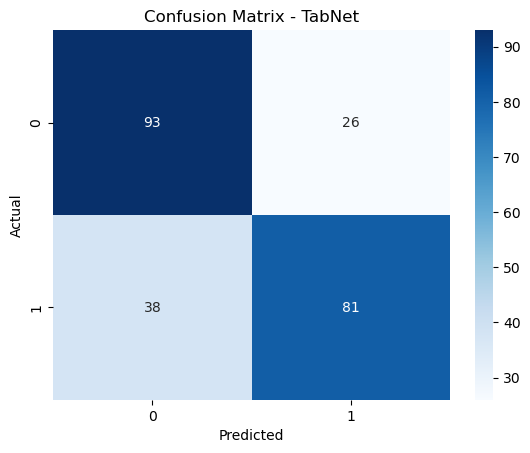

In [98]:
cm = confusion_matrix(y_true, y_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - TabNet')
plt.show()

- Save to pickle

In [99]:
import joblib

with open('./model/1Y/tabnet_1Y.pkl', 'wb') as f:
    joblib.dump(tabnet_clf, f)

#### LIME Explanation for TabPFN 1Y

In [100]:
generate_lime_report(
    model=clf,
    X_train_df=pd.DataFrame(X_train, columns=features_to_use['1y']),
    X_test_df=pd.DataFrame(X_test, columns=features_to_use['1y']),
    sample_index=0,
    categorical_cols=categorical_cols,
    encoder=encoder,
    class_names=['minus', 'plus'],
    save_to_png=True,
    filename_prefix="analisis_final",
    output_dir="./LIME/1Y/tabPFN_1Y_explanations"
)


Menyimpan file ke direktori: './LIME/1Y/tabPFN_1Y_explanations'


#### LIME Explanation for Tabnet 1Y

In [101]:
generate_lime_report(
    model=tabnet_clf,
    X_train_df=pd.DataFrame(X_train, columns=features_to_use['1y']),
    X_test_df=pd.DataFrame(X_test, columns=features_to_use['1y']),
    sample_index=0,
    categorical_cols=categorical_cols,
    encoder=encoder,
    class_names=['minus', 'plus'],
    save_to_png=True,
    filename_prefix="analisis_final",
    output_dir="./LIME/1Y/tabnet_1Y_explanations"
)


Menyimpan file ke direktori: './LIME/1Y/tabnet_1Y_explanations'


### 1D %

- Data Splitting (80:20)

In [102]:
X = df_custom[features_to_use['1d']]
y = df_custom['1d']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=5)

- Feature Importances (Random Forest)

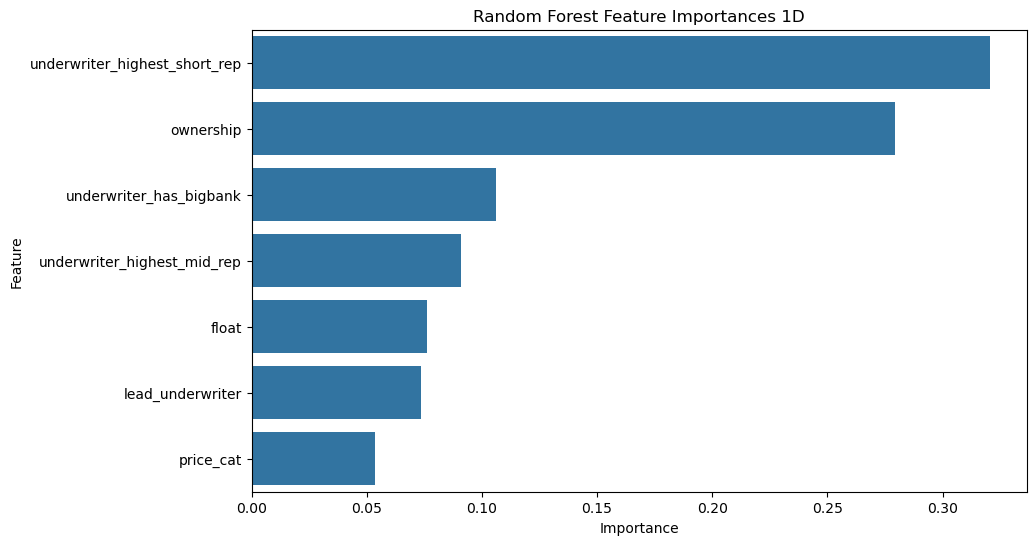

In [103]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)

rf.fit(X_train, y_train)

importances = rf.feature_importances_
importances = pd.Series(importances, index=X_train.columns)
importances.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=features_to_use['1d'])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Random Forest Feature Importances 1D")
plt.show()

#### TabPFN

- Training

In [104]:
clf = TabPFNClassifier(device="cuda" if torch.cuda.is_available() else "cpu")

clf.fit(X_train, y_train)

TabPFNClassifier(device='cpu')

In [105]:
y_pred = clf.predict(X_test)

- Finding the correct threshold

In [106]:
thresholds = np.arange(0.3, 0.61, 0.01)
f1_scores = []

probs = cross_val_predict(
    clf,
    X, y,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    method='predict_proba'
)[:, 1]

for t in thresholds:
    preds = (probs >= t).astype(int)
    score = f1_score(y, preds, average='macro')
    f1_scores.append(score)

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Best Threshold: {best_threshold:.2f}")
print(f"Best F1 Macro Score: {best_f1:.4f}")

Best Threshold: 0.30
Best F1 Macro Score: 0.3679


- Evaluation based on train test split

Classification Report:
              precision    recall  f1-score   support

           0       0.60      1.00      0.75        24
           1       0.80      0.44      0.57         9
           2       0.00      0.00      0.00        12

    accuracy                           0.62        45
   macro avg       0.47      0.48      0.44        45
weighted avg       0.48      0.62      0.51        45



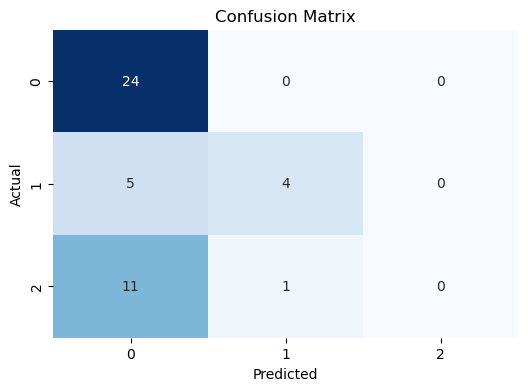

In [107]:
probs = clf.predict_proba(X_test)[:, 1]
y_pred = (probs > best_threshold).astype(int)

print("Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

- K-fold Cross Validation

Classification Report:
              precision    recall  f1-score   support

           0       0.54      1.00      0.70       117
           1       0.57      0.09      0.16        44
           2       0.00      0.00      0.00        62

    accuracy                           0.54       223
   macro avg       0.37      0.36      0.29       223
weighted avg       0.40      0.54      0.40       223



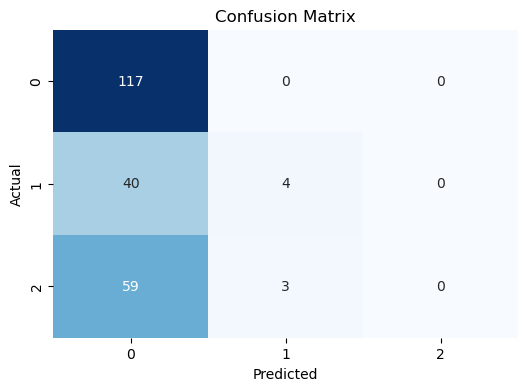

In [108]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
probs = cross_val_predict(
    clf,
    X, y,
    cv=cv,
    method='predict_proba'
)[:, 1]

y_pred = (probs > 0.5).astype(int)

print("Classification Report:")
print(classification_report(y, y_pred))

cm = confusion_matrix(y, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

- Save to Pickle

In [109]:
import joblib

with open('./model/1D/tabPFN_1D.pkl', 'wb') as f:
    joblib.dump(clf, f)

#### Tabnet

- Separating Categorical and Numerical features

In [110]:
categorical_cols_1d = []
numerical_cols_1d = []

for col in features_to_use['1d']:
    if is_categorical(df_custom, col):
        categorical_cols_1d.append(col)
    else:
        numerical_cols_1d.append(col)

print(f"Categorical Columns for 1D: {categorical_cols_1d}")
print(f"Numerical Columns for 1D: {numerical_cols_1d}")

Categorical Columns for 1D: ['underwriter_highest_short_rep', 'ownership', 'underwriter_has_bigbank', 'underwriter_highest_mid_rep', 'lead_underwriter', 'price_cat']
Numerical Columns for 1D: ['float']


- Ordinal Encoding + Data Splitting (80:20)

In [111]:
df_tabnet = df_custom.copy()

X = df_tabnet[features_to_use['1d']].copy()
y = df_tabnet['1d'].astype(int).values

encoder = OrdinalEncoder()
X[categorical_cols_1d] = encoder.fit_transform(X[categorical_cols_1d])
X = X.values.astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

- Calculating Class Weight for Loss Function

In [112]:
from torch.utils.data.sampler import WeightedRandomSampler
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)

class_weights_tensor = torch.FloatTensor(weights)

loss_function = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)

- Training

In [113]:
tabnet_clf = TabNetClassifier(
    n_d=16,
    n_a=16,
    n_steps=5,
    gamma=1.5,
    lambda_sparse=0.0001,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"mode": "min", "patience": 5, "factor": 0.5},
    scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
    seed=42,
    verbose=1
)

tabnet_clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_test, y_test)],
    eval_name=["val"],
    eval_metric=["balanced_accuracy"],
    max_epochs=200,
    patience=20,
    batch_size=32,
)

epoch 0  | loss: 1.52637 | val_balanced_accuracy: 0.38426 |  0:00:00s
epoch 1  | loss: 1.2817  | val_balanced_accuracy: 0.41667 |  0:00:00s
epoch 2  | loss: 1.41617 | val_balanced_accuracy: 0.30556 |  0:00:00s
epoch 3  | loss: 1.06658 | val_balanced_accuracy: 0.34722 |  0:00:00s
epoch 4  | loss: 1.06433 | val_balanced_accuracy: 0.29167 |  0:00:00s
epoch 5  | loss: 1.01365 | val_balanced_accuracy: 0.33333 |  0:00:00s
epoch 6  | loss: 0.95806 | val_balanced_accuracy: 0.38889 |  0:00:01s
epoch 7  | loss: 0.93242 | val_balanced_accuracy: 0.45833 |  0:00:01s
epoch 8  | loss: 1.03625 | val_balanced_accuracy: 0.37037 |  0:00:01s
epoch 9  | loss: 0.92481 | val_balanced_accuracy: 0.37037 |  0:00:01s
epoch 10 | loss: 0.94925 | val_balanced_accuracy: 0.375   |  0:00:01s
epoch 11 | loss: 0.86918 | val_balanced_accuracy: 0.41667 |  0:00:01s
epoch 12 | loss: 0.81322 | val_balanced_accuracy: 0.34722 |  0:00:01s
epoch 13 | loss: 0.85876 | val_balanced_accuracy: 0.38889 |  0:00:02s
epoch 14 | loss: 0.8

- Evaluation

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.96      0.75        24
           1       0.00      0.00      0.00         9
           2       0.71      0.42      0.53        12

    accuracy                           0.62        45
   macro avg       0.45      0.46      0.43        45
weighted avg       0.52      0.62      0.54        45



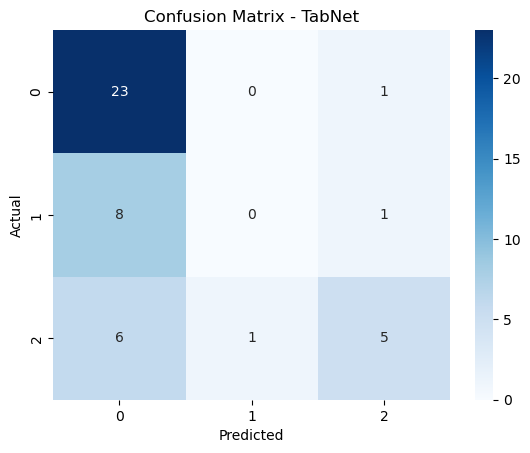

In [114]:
y_pred = tabnet_clf.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - TabNet')
plt.show()

- Feature Importances based on Built-In Attention Network

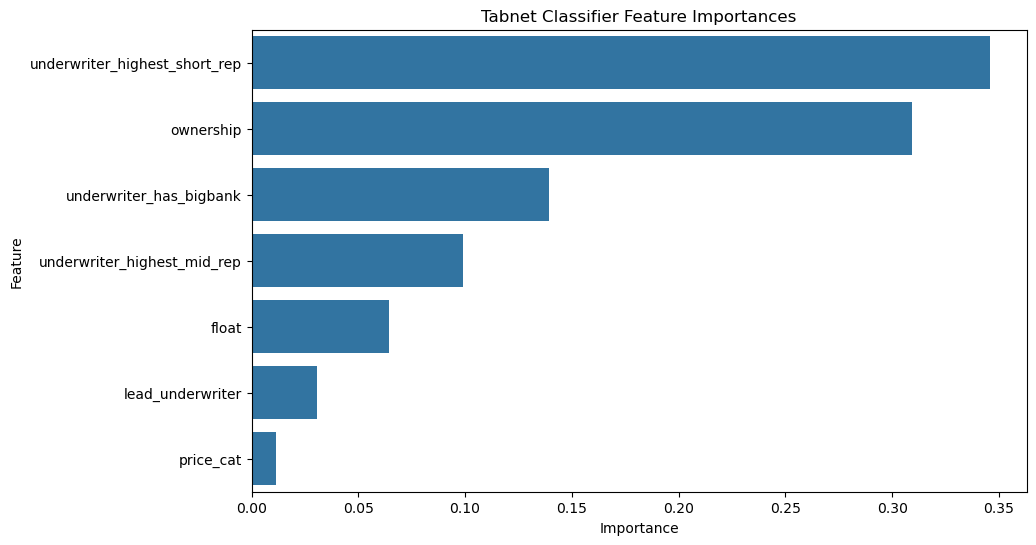

In [115]:
importances = tabnet_clf.feature_importances_
importances = pd.Series(importances)
importances.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=features_to_use['1d'])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Tabnet Classifier Feature Importances")
plt.show()

- K-fold Cross Validations

In [116]:
X[:, -len(numerical_cols):] = StandardScaler().fit_transform(X[:, -len(numerical_cols):])

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_preds = []
y_true = []

for train_idx, test_idx in cv.split(X_resampled, y_resampled):
    X_tr, X_te = X_resampled[train_idx], X_resampled[test_idx]
    y_tr, y_te = y_resampled[train_idx], y_resampled[test_idx]

    model = TabNetClassifier(
        seed=42,
        verbose=10,
    )

    model.fit(
        X_train=X_tr, y_train=y_tr,
        eval_set=[(X_te, y_te)],
        eval_name=["val"],
        eval_metric=["balanced_accuracy"],
        batch_size=16,
    )

    y_preds.extend(model.predict(X_te))
    y_true.extend(y_te)

print(classification_report(y_true, y_preds))

epoch 0  | loss: 1.33368 | val_balanced_accuracy: 0.37862 |  0:00:00s
epoch 10 | loss: 0.9845  | val_balanced_accuracy: 0.54952 |  0:00:03s
epoch 20 | loss: 0.89364 | val_balanced_accuracy: 0.54831 |  0:00:06s

Early stopping occurred at epoch 24 with best_epoch = 14 and best_val_balanced_accuracy = 0.60568
epoch 0  | loss: 1.26217 | val_balanced_accuracy: 0.3756  |  0:00:00s
epoch 10 | loss: 1.00668 | val_balanced_accuracy: 0.45713 |  0:00:02s
epoch 20 | loss: 0.95305 | val_balanced_accuracy: 0.55616 |  0:00:05s

Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_balanced_accuracy = 0.61292
epoch 0  | loss: 1.29236 | val_balanced_accuracy: 0.38829 |  0:00:00s
epoch 10 | loss: 1.02031 | val_balanced_accuracy: 0.47162 |  0:00:02s
epoch 20 | loss: 0.9491  | val_balanced_accuracy: 0.52838 |  0:00:05s

Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_balanced_accuracy = 0.54348
epoch 0  | loss: 1.46835 | val_balanced_accuracy: 0.28865 |  0:00:00s
epo

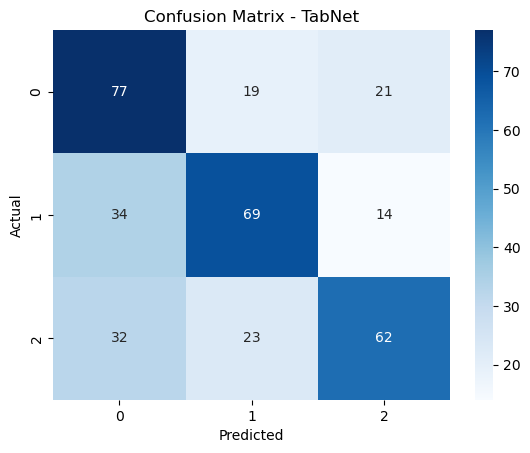

In [117]:
cm = confusion_matrix(y_true, y_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - TabNet')
plt.show()

- Save to Pickle

In [118]:
import joblib

with open('./model/1D/tabnet_1D.pkl', 'wb') as f:
    joblib.dump(tabnet_clf, f)

#### LIME Explanation for TabPFN 1D

In [119]:
generate_lime_report(
    model=clf,
    X_train_df=pd.DataFrame(X_train, columns=features_to_use['1d']),
    X_test_df=pd.DataFrame(X_test, columns=features_to_use['1d']),
    sample_index=0,
    categorical_cols=categorical_cols_1d,
    encoder=encoder,
    class_names=['ARA', 'plus', 'minus'],
    save_to_png=True,
    filename_prefix="analisis_final",
    output_dir="./LIME/1D/tabPFN_1Y_explanations"
)


Menyimpan file ke direktori: './LIME/1D/tabPFN_1Y_explanations'


#### LIME Explanation for Tabnet 1D

In [120]:
generate_lime_report(
    model=clf,
    X_train_df=pd.DataFrame(X_train, columns=features_to_use['1d']),
    X_test_df=pd.DataFrame(X_test, columns=features_to_use['1d']),
    sample_index=0,
    categorical_cols=categorical_cols_1d,
    encoder=encoder,
    class_names=['ARA', 'plus', 'minus'],
    save_to_png=True,
    filename_prefix="analisis_final",
    output_dir="./LIME/1D/tabnet_1Y_explanations"
)


Menyimpan file ke direktori: './LIME/1D/tabnet_1Y_explanations'


After this, target labels such as 1W, 1M, and 6M will follow the same steps like 1Y since all of them are a binary classification target.

### 1W %

In [121]:
df_custom['1w'].value_counts()

1w
1    138
0     85
Name: count, dtype: int64

In [122]:
X = df_custom[features_to_use['1w']].copy()
y = df_custom['1w'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=5)

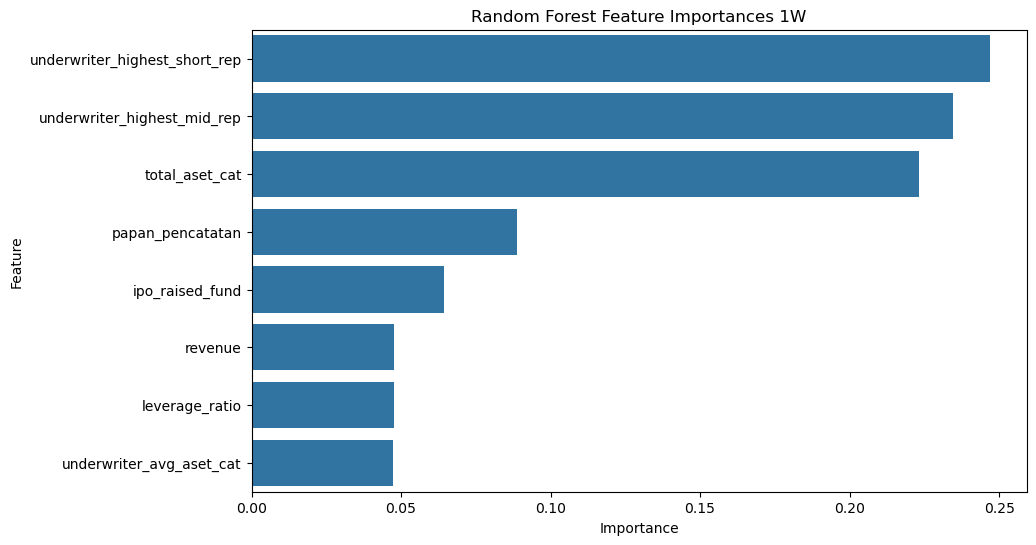

In [123]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)

rf.fit(X_train, y_train)

importances = rf.feature_importances_
importances = pd.Series(importances, index=X_train.columns)
importances.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=features_to_use['1w'])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Random Forest Feature Importances 1W")
plt.show()

#### TabPFN

In [124]:
clf = TabPFNClassifier(device="cuda" if torch.cuda.is_available() else "cpu")

clf.fit(X_train, y_train)

TabPFNClassifier(device='cpu')

In [125]:
y_pred = clf.predict(X_test)

In [126]:
thresholds = np.arange(0.3, 0.61, 0.01)
f1_scores = []

probs = cross_val_predict(
    clf,
    X, y,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    method='predict_proba'
)[:, 1]

for t in thresholds:
    preds = (probs >= t).astype(int)
    score = f1_score(y, preds, average='macro')
    f1_scores.append(score)

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Best Threshold: {best_threshold:.2f}")
print(f"Best F1 Macro Score: {best_f1:.4f}")

Best Threshold: 0.59
Best F1 Macro Score: 0.5995


F1 Score (threshold=0.5900000000000003): 0.5995
Accuracy: 0.6367713004484304


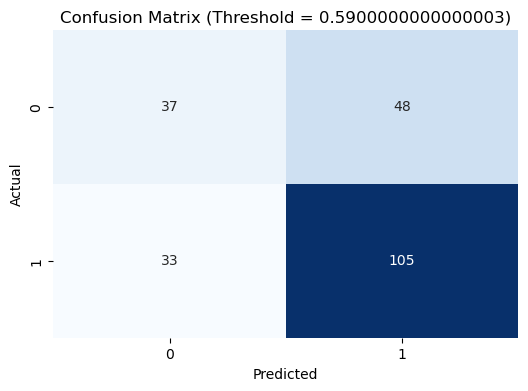

In [127]:
threshold = best_threshold
preds = (probs >= threshold).astype(int)

cm = confusion_matrix(y, preds)
print(f"F1 Score (threshold={threshold}): {f1_score(y, preds, average='macro'):.4f}")
print(f"Accuracy: {accuracy_score(y, preds)}")

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (Threshold = {threshold})')
plt.show()

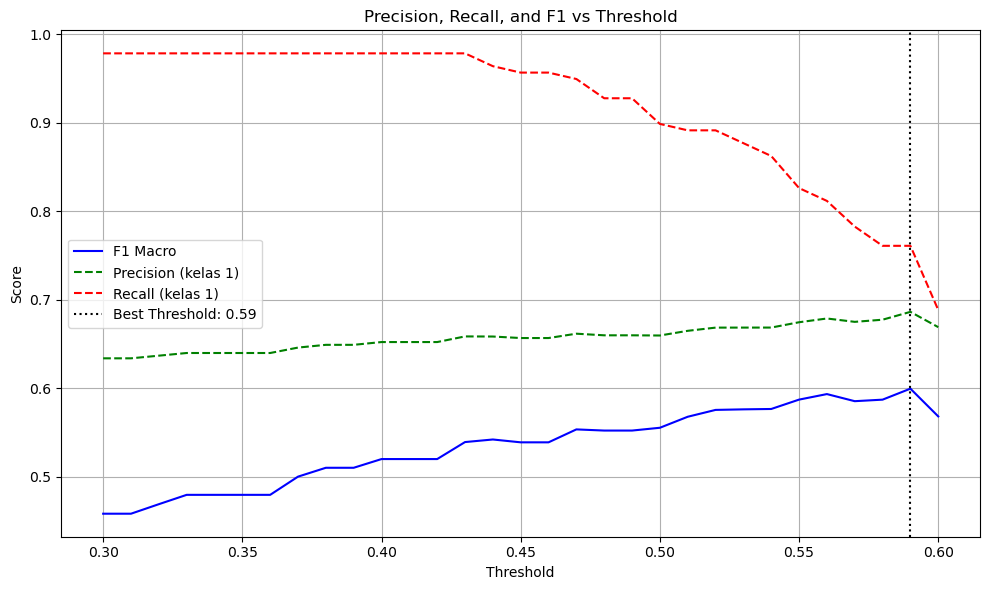

In [128]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
probs = cross_val_predict(
    clf,
    X, y,
    cv=cv,
    method='predict_proba'
)[:, 1]

f1_scores = []
precisions = []
recalls = []

for t in thresholds:
    preds = (probs >= t).astype(int)
    f1_scores.append(f1_score(y, preds, average='macro'))
    precisions.append(precision_score(y, preds))
    recalls.append(recall_score(y, preds))

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1 Macro', color='blue')
plt.plot(thresholds, precisions, label='Precision (kelas 1)', linestyle='--', color='green')
plt.plot(thresholds, recalls, label='Recall (kelas 1)', linestyle='--', color='red')
plt.axvline(best_threshold, linestyle=':', color='black', label=f'Best Threshold: {best_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 vs Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

F1 Score (threshold=0.5900000000000003): 0.5995
Accuracy: 0.6367713004484304
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.44      0.48        85
           1       0.69      0.76      0.72       138

    accuracy                           0.64       223
   macro avg       0.61      0.60      0.60       223
weighted avg       0.63      0.64      0.63       223



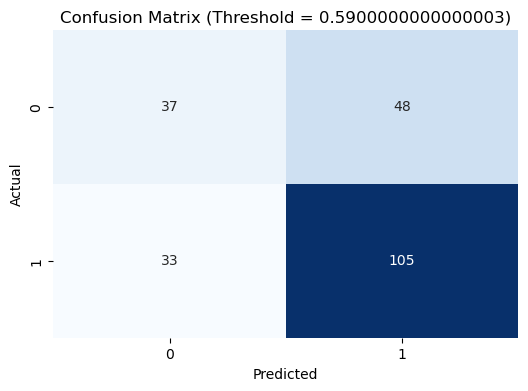

In [129]:
threshold = best_threshold
preds = (probs >= threshold).astype(int)

cm = confusion_matrix(y, preds)
print(f"F1 Score (threshold={threshold}): {f1_score(y, preds, average='macro'):.4f}")
print(f"Accuracy: {accuracy_score(y, preds)}")
print(f"Classification Report:")
print(classification_report(y, preds))

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (Threshold = {threshold})')
plt.show()

In [130]:
import joblib

with open('./model/1W/tabPFN_1W.pkl', 'wb') as f:
    joblib.dump(clf, f)

#### Tabnet

In [131]:
features_to_use['1w']

['underwriter_highest_short_rep',
 'underwriter_highest_mid_rep',
 'total_aset_cat',
 'papan_pencatatan',
 'ipo_raised_fund',
 'revenue',
 'leverage_ratio',
 'underwriter_avg_aset_cat']

In [132]:
categorical_cols_1w = []
numerical_cols_1w = []

for col in features_to_use['1w']:
    if is_categorical(df_custom, col):
        categorical_cols_1w.append(col)
    else:
        numerical_cols_1w.append(col)

print(f"Categorical Columns for 1w: {categorical_cols_1w}")
print(f"Numerical Columns for 1w: {numerical_cols_1w}")

Categorical Columns for 1w: ['underwriter_highest_short_rep', 'underwriter_highest_mid_rep', 'total_aset_cat', 'papan_pencatatan', 'underwriter_avg_aset_cat']
Numerical Columns for 1w: ['ipo_raised_fund', 'revenue', 'leverage_ratio']


In [133]:
df_tabnet = df_custom.copy()

X = df_tabnet[features_to_use['1w']].copy()
y = df_tabnet['1w'].astype(int).values

encoder = OrdinalEncoder()
X[categorical_cols_1w] = encoder.fit_transform(X[categorical_cols_1w])
X = X.values.astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [134]:
tabnet_clf = TabNetClassifier(
    n_d=16,
    n_a=16,
    n_steps=5,
    gamma=1.5,
    lambda_sparse=0.0001,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"mode": "min", "patience": 5, "factor": 0.5},
    scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
    seed=42,
    verbose=10,
)

tabnet_clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_test, y_test)],
    eval_name=["val"],
    eval_metric=["balanced_accuracy"],
    max_epochs=200,
    patience=20,
    batch_size=32
)

epoch 0  | loss: 1.35235 | val_balanced_accuracy: 0.54622 |  0:00:00s
epoch 10 | loss: 0.62927 | val_balanced_accuracy: 0.52416 |  0:00:01s
epoch 20 | loss: 0.58667 | val_balanced_accuracy: 0.54832 |  0:00:03s

Early stopping occurred at epoch 27 with best_epoch = 7 and best_val_balanced_accuracy = 0.59874


Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.41      0.47        17
           1       0.69      0.79      0.73        28

    accuracy                           0.64        45
   macro avg       0.61      0.60      0.60        45
weighted avg       0.63      0.64      0.63        45



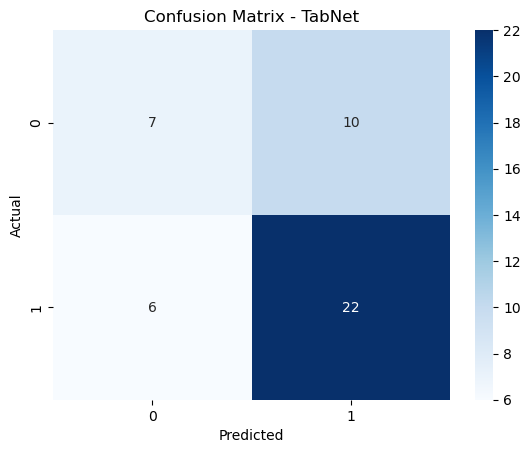

In [135]:
y_pred = tabnet_clf.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - TabNet')
plt.show()

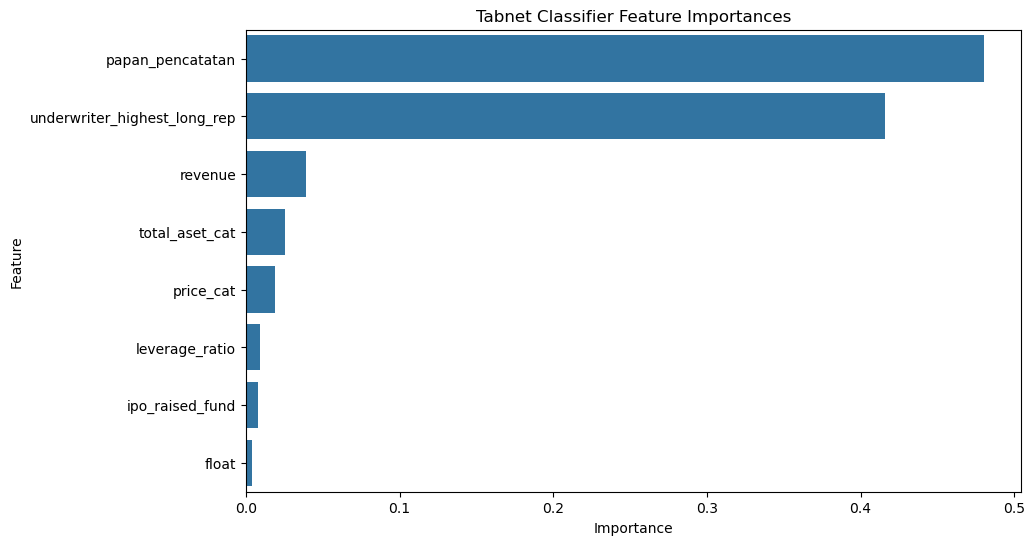

In [136]:
importances = tabnet_clf.feature_importances_
importances = pd.Series(importances)
importances.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=features_to_use['1y'])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Tabnet Classifier Feature Importances")
plt.show()

In [137]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler

X[:, -len(numerical_cols):] = StandardScaler().fit_transform(X[:, -len(numerical_cols):])

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_preds = []
y_true = []

for train_idx, test_idx in cv.split(X_resampled, y_resampled):
    X_tr, X_te = X_resampled[train_idx], X_resampled[test_idx]
    y_tr, y_te = y_resampled[train_idx], y_resampled[test_idx]

    model = TabNetClassifier(
        n_d=16,
        n_a=16,
        n_steps=5,
        gamma=1.5,
        lambda_sparse=0.0001,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=2e-2),
        scheduler_params={"mode": "min", "patience": 5, "factor": 0.5},
        scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
        seed=42,
        verbose=10,
    )

    model.fit(
        X_train=X_tr, y_train=y_tr,
        eval_set=[(X_te, y_te)],
        eval_name=["val"],
        eval_metric=["balanced_accuracy"],
        batch_size=48,
    )

    y_preds.extend(model.predict(X_te))
    y_true.extend(y_te)

print(classification_report(y_true, y_preds))

epoch 0  | loss: 1.29659 | val_balanced_accuracy: 0.42857 |  0:00:00s
epoch 10 | loss: 0.55276 | val_balanced_accuracy: 0.55357 |  0:00:01s

Early stopping occurred at epoch 14 with best_epoch = 4 and best_val_balanced_accuracy = 0.625
epoch 0  | loss: 1.1038  | val_balanced_accuracy: 0.39616 |  0:00:00s
epoch 10 | loss: 0.58534 | val_balanced_accuracy: 0.61905 |  0:00:01s

Early stopping occurred at epoch 15 with best_epoch = 5 and best_val_balanced_accuracy = 0.63095
epoch 0  | loss: 1.14737 | val_balanced_accuracy: 0.50529 |  0:00:00s
epoch 10 | loss: 0.57231 | val_balanced_accuracy: 0.72553 |  0:00:01s
epoch 20 | loss: 0.51921 | val_balanced_accuracy: 0.52447 |  0:00:02s

Early stopping occurred at epoch 20 with best_epoch = 10 and best_val_balanced_accuracy = 0.72553
epoch 0  | loss: 1.34599 | val_balanced_accuracy: 0.56283 |  0:00:00s
epoch 10 | loss: 0.61344 | val_balanced_accuracy: 0.63757 |  0:00:01s

Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_balance

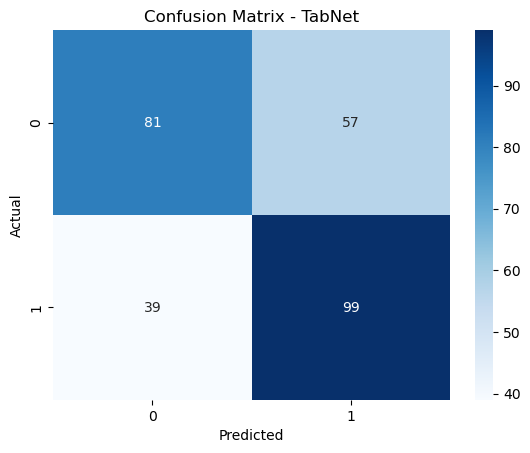

In [138]:
cm = confusion_matrix(y_true, y_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - TabNet')
plt.show()

In [139]:
import joblib

with open('./model/1W/tabnet_1W.pkl', 'wb') as f:
    joblib.dump(tabnet_clf, f)

#### LIME Explanation for TabPFN 1W

In [140]:
generate_lime_report(
    model=clf,
    X_train_df=pd.DataFrame(X_train, columns=features_to_use['1w']),
    X_test_df=pd.DataFrame(X_test, columns=features_to_use['1w']),
    sample_index=0,
    categorical_cols=categorical_cols_1w,
    encoder=encoder,
    class_names=['minus', 'plus'],
    save_to_png=True,
    filename_prefix="analisis_final",
    output_dir="./LIME/1W/tabPFN_1W_explanations"
)


Menyimpan file ke direktori: './LIME/1W/tabPFN_1W_explanations'


#### LIME Explanation for Tabnet 1W

In [141]:
generate_lime_report(
    model=clf,
    X_train_df=pd.DataFrame(X_train, columns=features_to_use['1w']),
    X_test_df=pd.DataFrame(X_test, columns=features_to_use['1w']),
    sample_index=0,
    categorical_cols=categorical_cols_1w,
    encoder=encoder,
    class_names=['minus', 'plus'],
    save_to_png=True,
    filename_prefix="analisis_final",
    output_dir="./LIME/1W/tabnet_1W_explanations"
)


Menyimpan file ke direktori: './LIME/1W/tabnet_1W_explanations'


### 1M %

In [142]:
df_custom['1m'].value_counts()

1m
1    118
0    103
2      2
Name: count, dtype: int64

In [143]:
X = df_custom[features_to_use['1m']].copy()
y = df_custom['1m'].copy()

X = X[y != 2]
y = y[y != 2]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=5)

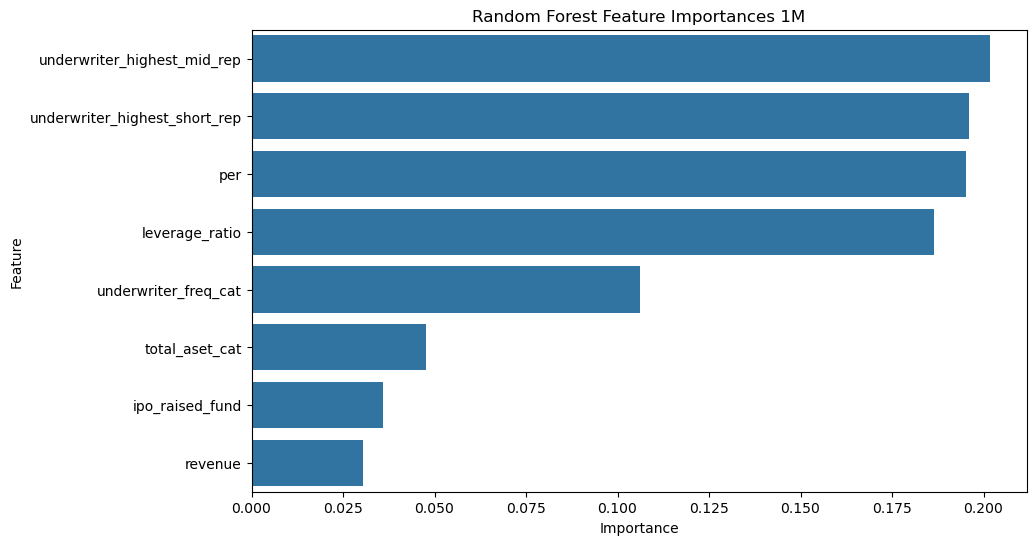

In [144]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)

rf.fit(X_train, y_train)

importances = rf.feature_importances_
importances = pd.Series(importances, index=X_train.columns)
importances.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=features_to_use['1m'])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Random Forest Feature Importances 1M")
plt.show()

#### TabPFN

In [145]:
clf = TabPFNClassifier(device="cuda" if torch.cuda.is_available() else "cpu")

clf.fit(X_train, y_train)

TabPFNClassifier(device='cpu')

In [146]:
y_pred = clf.predict(X_test)

In [147]:
thresholds = np.arange(0.3, 0.61, 0.01)
f1_scores = []

probs = cross_val_predict(
    clf,
    X, y,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    method='predict_proba'
)[:, 1]

for t in thresholds:
    preds = (probs >= t).astype(int)
    score = f1_score(y, preds, average='macro')
    f1_scores.append(score)

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Best Threshold: {best_threshold:.2f}")
print(f"Best F1 Macro Score: {best_f1:.4f}")

Best Threshold: 0.53
Best F1 Macro Score: 0.6559


Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.71      0.71        21
           1       0.75      0.75      0.75        24

    accuracy                           0.73        45
   macro avg       0.73      0.73      0.73        45
weighted avg       0.73      0.73      0.73        45



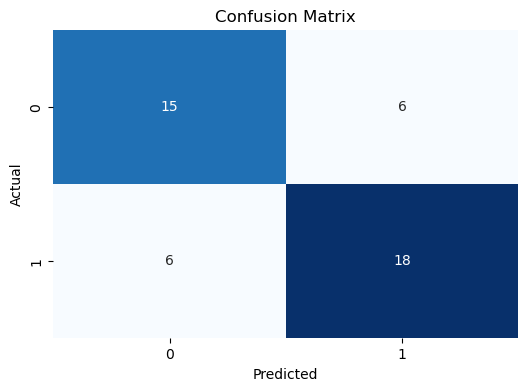

In [148]:
probs = clf.predict_proba(X_test)[:, 1]
y_pred = (probs > best_threshold).astype(int)

print("Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

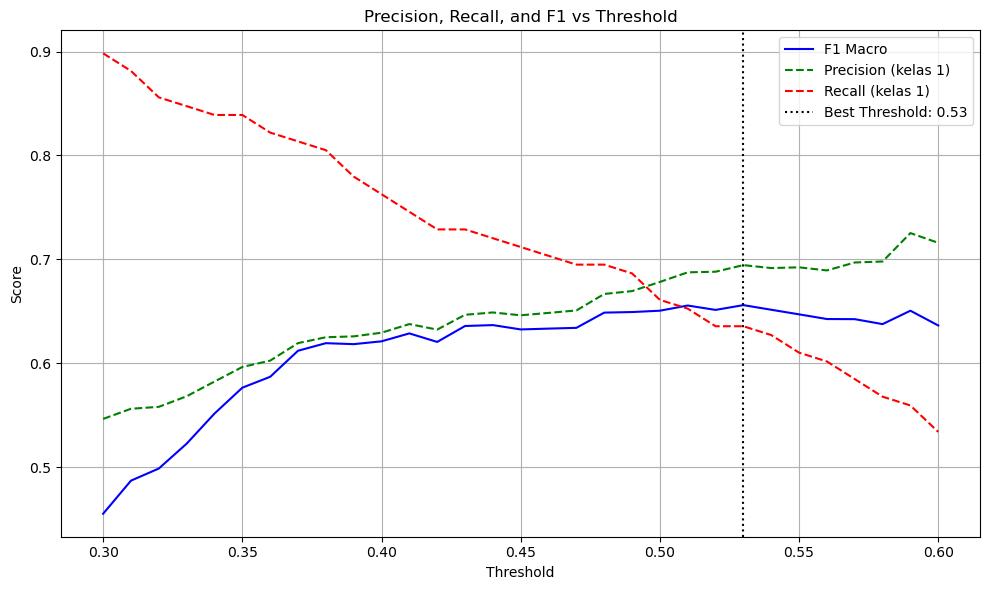

In [149]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
probs = cross_val_predict(
    clf,
    X, y,
    cv=cv,
    method='predict_proba'
)[:, 1]

f1_scores = []
precisions = []
recalls = []

for t in thresholds:
    preds = (probs >= t).astype(int)
    f1_scores.append(f1_score(y, preds, average='macro'))
    precisions.append(precision_score(y, preds))
    recalls.append(recall_score(y, preds))

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1 Macro', color='blue')
plt.plot(thresholds, precisions, label='Precision (kelas 1)', linestyle='--', color='green')
plt.plot(thresholds, recalls, label='Recall (kelas 1)', linestyle='--', color='red')
plt.axvline(best_threshold, linestyle=':', color='black', label=f'Best Threshold: {best_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 vs Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

F1 Score (threshold=0.5300000000000002): 0.6559
Accuracy: 0.6561085972850679
Classification Report:

              precision    recall  f1-score   support

           0       0.62      0.68      0.65       103
           1       0.69      0.64      0.66       118

    accuracy                           0.66       221
   macro avg       0.66      0.66      0.66       221
weighted avg       0.66      0.66      0.66       221



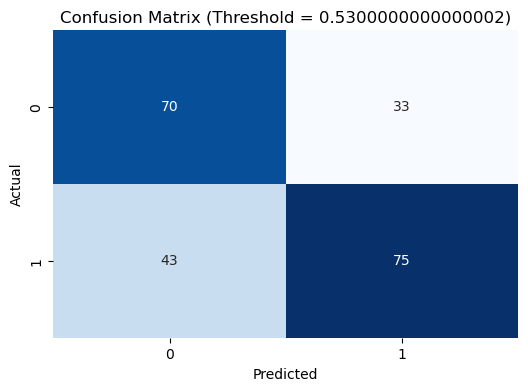

In [150]:
threshold = best_threshold
preds = (probs >= threshold).astype(int)

cm = confusion_matrix(y, preds)
print(f"F1 Score (threshold={threshold}): {f1_score(y, preds, average='macro'):.4f}")
print(f"Accuracy: {accuracy_score(y, preds)}")
print("Classification Report:\n")
print(classification_report(y, preds))

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (Threshold = {threshold})')
plt.show()

In [151]:
import joblib

with open('./model/1M/tabPFN_1M.pkl', 'wb') as f:
    joblib.dump(clf, f)

#### Tabnet

In [152]:
features_to_use['1m']

['underwriter_highest_mid_rep',
 'underwriter_highest_short_rep',
 'per',
 'leverage_ratio',
 'underwriter_freq_cat',
 'total_aset_cat',
 'ipo_raised_fund',
 'revenue']

In [153]:
categorical_cols_1m = []
numerical_cols_1m = []

for col in features_to_use['1m']:
    if is_categorical(df_custom, col):
        categorical_cols_1m.append(col)
    else:
        numerical_cols_1m.append(col)

print(f"Categorical Columns for 1m: {categorical_cols_1m}")
print(f"Numerical Columns for 1m: {numerical_cols_1m}")

Categorical Columns for 1m: ['underwriter_highest_mid_rep', 'underwriter_highest_short_rep', 'underwriter_freq_cat', 'total_aset_cat']
Numerical Columns for 1m: ['per', 'leverage_ratio', 'ipo_raised_fund', 'revenue']


In [154]:
df_custom['1m'].value_counts()

1m
1    118
0    103
2      2
Name: count, dtype: int64

In [155]:
df_tabnet = df_custom[df_custom['1m'] != 2].copy()

X = df_tabnet[features_to_use['1m']].copy()
y = df_tabnet['1m'].astype(int).values

encoder = OrdinalEncoder()
X[categorical_cols_1m] = encoder.fit_transform(X[categorical_cols_1m])
X = X.values.astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [156]:
tabnet_clf = TabNetClassifier(
    n_d=16,
    n_a=16,
    n_steps=5,
    gamma=1.5,
    lambda_sparse=0.0001,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"mode": "min", "patience": 5, "factor": 0.5},
    scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
    seed=42,
    verbose=10,
)

tabnet_clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_test, y_test)],
    eval_name=["val"],
    eval_metric=["balanced_accuracy"],
    max_epochs=200,
    patience=20,
    batch_size=16
)

epoch 0  | loss: 1.38726 | val_balanced_accuracy: 0.57143 |  0:00:00s
epoch 10 | loss: 0.70576 | val_balanced_accuracy: 0.49107 |  0:00:03s
epoch 20 | loss: 0.5528  | val_balanced_accuracy: 0.63095 |  0:00:06s

Early stopping occurred at epoch 29 with best_epoch = 9 and best_val_balanced_accuracy = 0.65774


Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.86      0.69        21
           1       0.79      0.46      0.58        24

    accuracy                           0.64        45
   macro avg       0.68      0.66      0.64        45
weighted avg       0.69      0.64      0.63        45



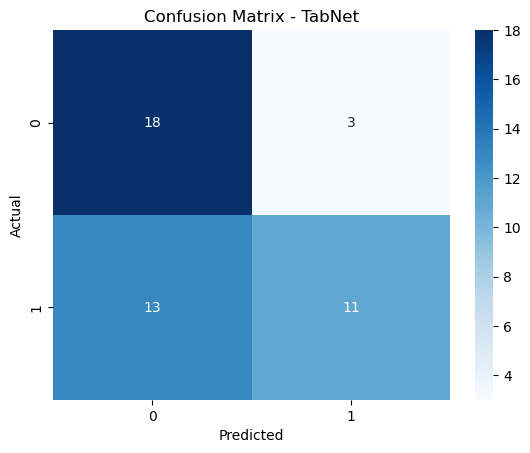

In [157]:
y_pred = tabnet_clf.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - TabNet')
plt.show()

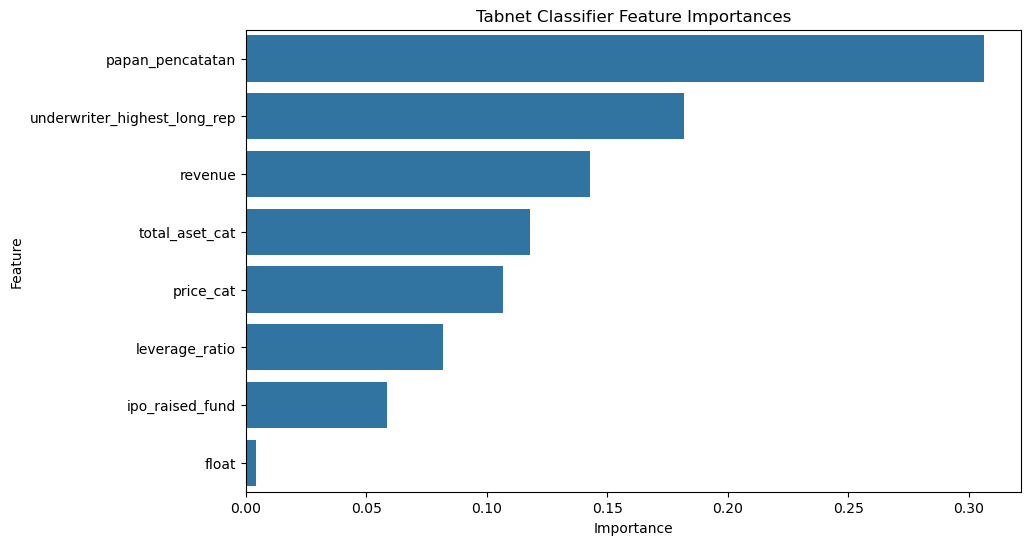

In [158]:
importances = tabnet_clf.feature_importances_
importances = pd.Series(importances)
importances.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=features_to_use['1y'])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Tabnet Classifier Feature Importances")
plt.show()

In [159]:
X[:, -len(numerical_cols):] = StandardScaler().fit_transform(X[:, -len(numerical_cols):])

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_preds = []
y_true = []

for train_idx, test_idx in cv.split(X_resampled, y_resampled):
    X_tr, X_te = X_resampled[train_idx], X_resampled[test_idx]
    y_tr, y_te = y_resampled[train_idx], y_resampled[test_idx]

    model = TabNetClassifier(
        n_d=16,
        n_a=16,
        n_steps=5,
        gamma=1.5,
        lambda_sparse=0.0001,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=2e-2),
        scheduler_params={"mode": "min", "patience": 5, "factor": 0.5},
        scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
        seed=42,
        verbose=10,
    )

    model.fit(
        X_train=X_tr, y_train=y_tr,
        eval_set=[(X_te, y_te)],
        eval_name=["val"],
        eval_metric=["balanced_accuracy"],
        batch_size=48,
    )

    y_preds.extend(model.predict(X_te))
    y_true.extend(y_te)

print(classification_report(y_true, y_preds))

epoch 0  | loss: 1.34305 | val_balanced_accuracy: 0.5625  |  0:00:00s
epoch 10 | loss: 0.60557 | val_balanced_accuracy: 0.58333 |  0:00:00s
epoch 20 | loss: 0.56528 | val_balanced_accuracy: 0.70833 |  0:00:01s
epoch 30 | loss: 0.51262 | val_balanced_accuracy: 0.66667 |  0:00:02s

Early stopping occurred at epoch 30 with best_epoch = 20 and best_val_balanced_accuracy = 0.70833
epoch 0  | loss: 1.41463 | val_balanced_accuracy: 0.55707 |  0:00:00s
epoch 10 | loss: 0.58487 | val_balanced_accuracy: 0.5308  |  0:00:01s

Early stopping occurred at epoch 15 with best_epoch = 5 and best_val_balanced_accuracy = 0.62138
epoch 0  | loss: 1.11263 | val_balanced_accuracy: 0.44565 |  0:00:00s
epoch 10 | loss: 0.61969 | val_balanced_accuracy: 0.52536 |  0:00:01s
epoch 20 | loss: 0.52552 | val_balanced_accuracy: 0.47192 |  0:00:02s

Early stopping occurred at epoch 27 with best_epoch = 17 and best_val_balanced_accuracy = 0.66123
epoch 0  | loss: 1.27601 | val_balanced_accuracy: 0.47464 |  0:00:00s
epoc

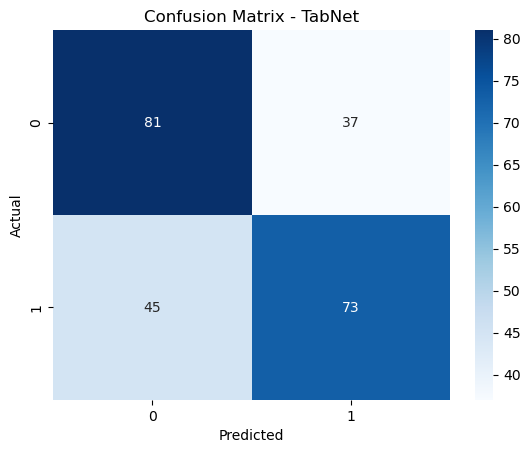

In [160]:
cm = confusion_matrix(y_true, y_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - TabNet')
plt.show()

In [161]:
import joblib

with open('./model/1M/tabnet_1M.pkl', 'wb') as f:
    joblib.dump(tabnet_clf, f)

#### LIME Explanation for TabPFN 1M

In [162]:
generate_lime_report(
    model=clf,
    X_train_df=pd.DataFrame(X_train, columns=features_to_use['1m']),
    X_test_df=pd.DataFrame(X_test, columns=features_to_use['1m']),
    sample_index=0,
    categorical_cols=categorical_cols_1m,
    encoder=encoder,
    class_names=['minus', 'plus'],
    save_to_png=True,
    filename_prefix="analisis_final",
    output_dir="./LIME/1M/tabPFN_1M_explanations"
)


Menyimpan file ke direktori: './LIME/1M/tabPFN_1M_explanations'


#### LIME Explanation for Tabnet 1M

In [163]:
generate_lime_report(
    model=tabnet_clf,
    X_train_df=pd.DataFrame(X_train, columns=features_to_use['1m']),
    X_test_df=pd.DataFrame(X_test, columns=features_to_use['1m']),
    sample_index=0,
    categorical_cols=categorical_cols_1m,
    encoder=encoder,
    class_names=['minus', 'plus'],
    save_to_png=True,
    filename_prefix="analisis_final",
    output_dir="./LIME/1M/tabnet_1M_explanations"
)


Menyimpan file ke direktori: './LIME/1M/tabnet_1M_explanations'


### 6M %

In [164]:
df_custom['6m'].value_counts()

6m
0    110
2     95
1     18
Name: count, dtype: int64

In [165]:
X = df_custom[features_to_use['6m']].copy()
y = df_custom['6m'].copy()

X = X[y != 1]
y = y[y != 1]

y = y.replace({2: 1})

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=5)

In [166]:
y.value_counts()

6m
0    110
1     95
Name: count, dtype: int64

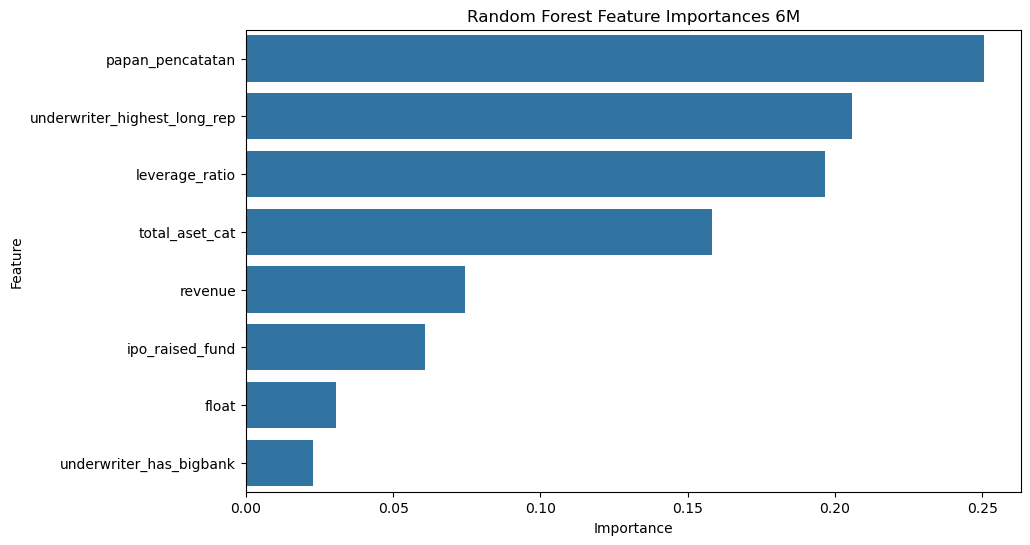

In [167]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)

rf.fit(X_train, y_train)

importances = rf.feature_importances_
importances = pd.Series(importances, index=X_train.columns)
importances.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=features_to_use['6m'])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Random Forest Feature Importances 6M")
plt.show()

#### TabPFN

In [168]:
clf = TabPFNClassifier(device="cuda" if torch.cuda.is_available() else "cpu")

clf.fit(X_train, y_train)

TabPFNClassifier(device='cpu')

In [169]:
y_pred = clf.predict(X_test)

In [170]:
thresholds = np.arange(0.3, 0.61, 0.01)
f1_scores = []

probs = cross_val_predict(
    clf,
    X, y,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    method='predict_proba'
)[:, 1]

for t in thresholds:
    preds = (probs >= t).astype(int)
    score = f1_score(y, preds, average='macro')
    f1_scores.append(score)

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Best Threshold: {best_threshold:.2f}")
print(f"Best F1 Macro Score: {best_f1:.4f}")

Best Threshold: 0.48
Best F1 Macro Score: 0.6240


Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.68      0.65        22
           1       0.59      0.53      0.56        19

    accuracy                           0.61        41
   macro avg       0.61      0.60      0.60        41
weighted avg       0.61      0.61      0.61        41



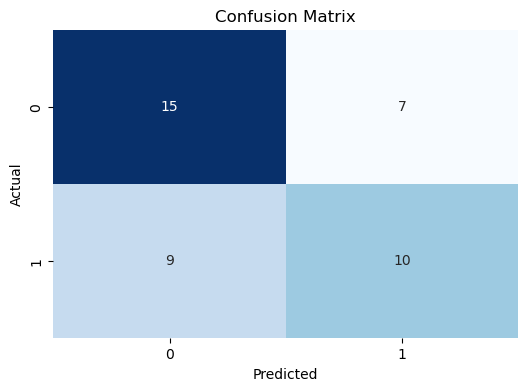

In [171]:
probs = clf.predict_proba(X_test)[:, 1]
y_pred = (probs > best_threshold).astype(int)

print("Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

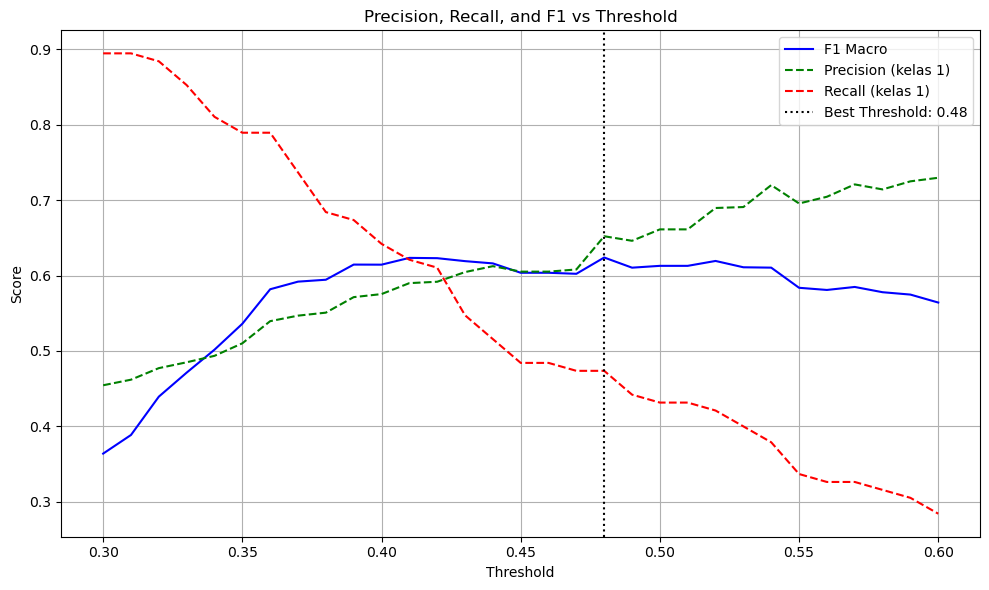

In [172]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
probs = cross_val_predict(
    clf,
    X, y,
    cv=cv,
    method='predict_proba'
)[:, 1]

f1_scores = []
precisions = []
recalls = []

for t in thresholds:
    preds = (probs >= t).astype(int)
    f1_scores.append(f1_score(y, preds, average='macro'))
    precisions.append(precision_score(y, preds))
    recalls.append(recall_score(y, preds))

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1 Macro', color='blue')
plt.plot(thresholds, precisions, label='Precision (kelas 1)', linestyle='--', color='green')
plt.plot(thresholds, recalls, label='Recall (kelas 1)', linestyle='--', color='red')
plt.axvline(best_threshold, linestyle=':', color='black', label=f'Best Threshold: {best_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 vs Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

F1 Score (threshold=0.48000000000000015): 0.6240
Accuracy: 0.6390243902439025
Classification Report:

              precision    recall  f1-score   support

           0       0.63      0.78      0.70       110
           1       0.65      0.47      0.55        95

    accuracy                           0.64       205
   macro avg       0.64      0.63      0.62       205
weighted avg       0.64      0.64      0.63       205



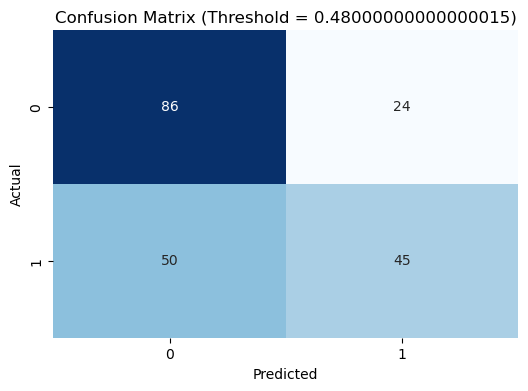

In [173]:
threshold = best_threshold
preds = (probs >= threshold).astype(int)

cm = confusion_matrix(y, preds)
print(f"F1 Score (threshold={threshold}): {f1_score(y, preds, average='macro'):.4f}")
print(f"Accuracy: {accuracy_score(y, preds)}")
print("Classification Report:\n")
print(classification_report(y, preds))

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (Threshold = {threshold})')
plt.show()

In [174]:
import joblib

with open('./model/6M/tabPFN_6M.pkl', 'wb') as f:
    joblib.dump(clf, f)

#### Tabnet

In [175]:
features_to_use['6m']

['papan_pencatatan',
 'underwriter_highest_long_rep',
 'leverage_ratio',
 'total_aset_cat',
 'revenue',
 'ipo_raised_fund',
 'float',
 'underwriter_has_bigbank']

In [176]:
categorical_cols_6m = []
numerical_cols_6m = []

for col in features_to_use['6m']:
    if is_categorical(df_custom, col):
        categorical_cols_6m.append(col)
    else:
        numerical_cols_6m.append(col)

print(f"Categorical Columns for 6m: {categorical_cols_6m}")
print(f"Numerical Columns for 6m: {numerical_cols_6m}")

Categorical Columns for 6m: ['papan_pencatatan', 'underwriter_highest_long_rep', 'total_aset_cat', 'underwriter_has_bigbank']
Numerical Columns for 6m: ['leverage_ratio', 'revenue', 'ipo_raised_fund', 'float']


In [177]:
df_custom['6m'].value_counts()

6m
0    110
2     95
1     18
Name: count, dtype: int64

In [178]:
df_tabnet = df_custom[df_custom['6m'] != 1].copy()

X = df_tabnet[features_to_use['6m']].copy()
y = df_tabnet['6m'].astype(int).values

y[y == 2] = 1

encoder = OrdinalEncoder()
X[categorical_cols_6m] = encoder.fit_transform(X[categorical_cols_6m])
X = X.values.astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [179]:
tabnet_clf = TabNetClassifier(
    n_d=16,
    n_a=16,
    n_steps=5,
    gamma=1.5,
    lambda_sparse=0.0001,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"mode": "min", "patience": 5, "factor": 0.5},
    scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
    seed=42,
    verbose=10,
)

tabnet_clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_test, y_test)],
    eval_name=["val"],
    eval_metric=["balanced_accuracy"],
    max_epochs=200,
    patience=20,
    batch_size=32
)

epoch 0  | loss: 1.14616 | val_balanced_accuracy: 0.57656 |  0:00:00s
epoch 10 | loss: 0.63426 | val_balanced_accuracy: 0.5     |  0:00:01s
epoch 20 | loss: 0.52756 | val_balanced_accuracy: 0.47967 |  0:00:03s

Early stopping occurred at epoch 28 with best_epoch = 8 and best_val_balanced_accuracy = 0.58612


Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.91      0.71        22
           1       0.71      0.26      0.38        19

    accuracy                           0.61        41
   macro avg       0.65      0.59      0.55        41
weighted avg       0.65      0.61      0.56        41



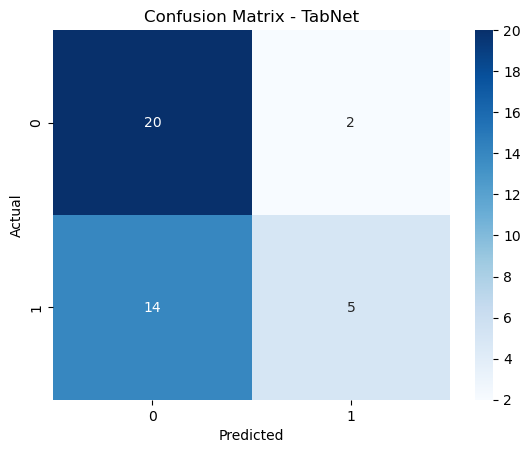

In [180]:
y_pred = tabnet_clf.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - TabNet')
plt.show()

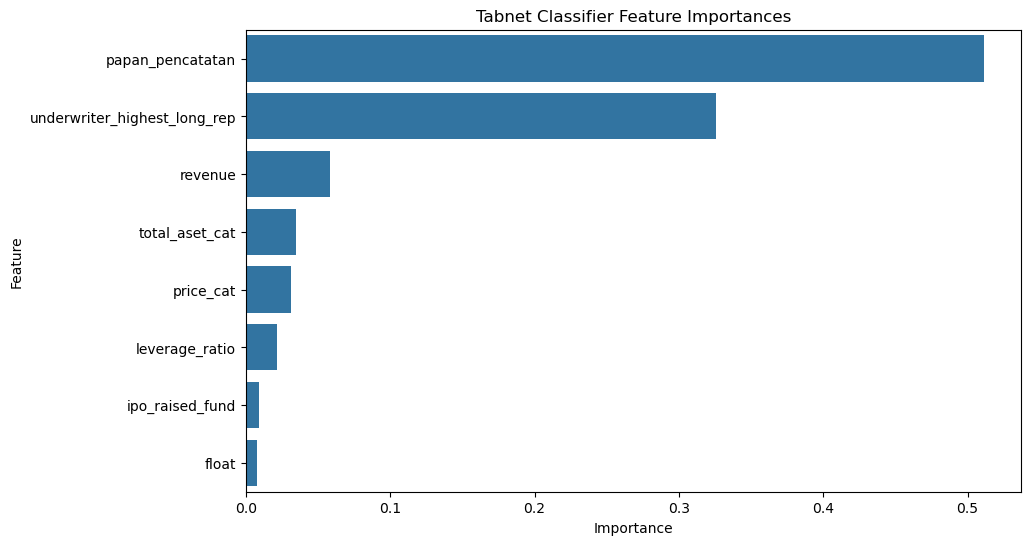

In [181]:
importances = tabnet_clf.feature_importances_
importances = pd.Series(importances)
importances.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=features_to_use['1y'])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Tabnet Classifier Feature Importances")
plt.show()

In [182]:
X[:, -len(numerical_cols):] = StandardScaler().fit_transform(X[:, -len(numerical_cols):])

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_preds = []
y_true = []

for train_idx, test_idx in cv.split(X_resampled, y_resampled):
    X_tr, X_te = X_resampled[train_idx], X_resampled[test_idx]
    y_tr, y_te = y_resampled[train_idx], y_resampled[test_idx]

    model = TabNetClassifier(
        n_d=16,
        n_a=16,
        n_steps=5,
        gamma=1.5,
        lambda_sparse=0.0001,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=2e-2),
        scheduler_params={"mode": "min", "patience": 5, "factor": 0.5},
        scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
        seed=42,
        verbose=10,
    )

    model.fit(
        X_train=X_tr, y_train=y_tr,
        eval_set=[(X_te, y_te)],
        eval_name=["val"],
        eval_metric=["balanced_accuracy"],
        batch_size=48,
    )

    y_preds.extend(model.predict(X_te))
    y_true.extend(y_te)

print(classification_report(y_true, y_preds))

epoch 0  | loss: 1.20362 | val_balanced_accuracy: 0.5     |  0:00:00s
epoch 10 | loss: 0.56206 | val_balanced_accuracy: 0.54545 |  0:00:01s

Early stopping occurred at epoch 14 with best_epoch = 4 and best_val_balanced_accuracy = 0.59091
epoch 0  | loss: 1.638   | val_balanced_accuracy: 0.47727 |  0:00:00s
epoch 10 | loss: 0.6256  | val_balanced_accuracy: 0.56818 |  0:00:01s

Early stopping occurred at epoch 17 with best_epoch = 7 and best_val_balanced_accuracy = 0.70455
epoch 0  | loss: 1.52168 | val_balanced_accuracy: 0.56818 |  0:00:00s
epoch 10 | loss: 0.71365 | val_balanced_accuracy: 0.59091 |  0:00:00s

Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_balanced_accuracy = 0.63636
epoch 0  | loss: 1.57448 | val_balanced_accuracy: 0.65909 |  0:00:00s
epoch 10 | loss: 0.71101 | val_balanced_accuracy: 0.72727 |  0:00:00s

Early stopping occurred at epoch 17 with best_epoch = 7 and best_val_balanced_accuracy = 0.72727
epoch 0  | loss: 1.66776 | val_balanced_accuracy

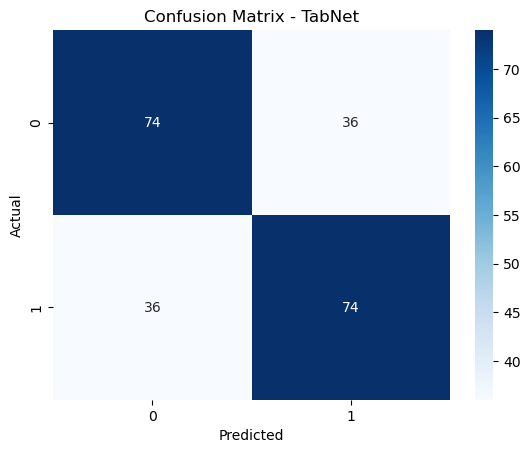

In [183]:
cm = confusion_matrix(y_true, y_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - TabNet')
plt.show()

In [184]:
import joblib

with open('./model/6M/tabnet_6M.pkl', 'wb') as f:
    joblib.dump(tabnet_clf, f)

#### LIME Explanation for TabPFN 6M

In [185]:
generate_lime_report(
    model=clf,
    X_train_df=pd.DataFrame(X_train, columns=features_to_use['6m']),
    X_test_df=pd.DataFrame(X_test, columns=features_to_use['6m']),
    sample_index=0,
    categorical_cols=categorical_cols_6m,
    encoder=encoder,
    class_names=['plus', 'minus'],
    save_to_png=True,
    filename_prefix="analisis_final",
    output_dir="./LIME/6M/tabPFN_6M_explanations"
)


Menyimpan file ke direktori: './LIME/6M/tabPFN_6M_explanations'


#### LIME Explanation for Tabnet 6M

In [186]:
generate_lime_report(
    model=clf,
    X_train_df=pd.DataFrame(X_train, columns=features_to_use['6m']),
    X_test_df=pd.DataFrame(X_test, columns=features_to_use['6m']),
    sample_index=0,
    categorical_cols=categorical_cols_6m,
    encoder=encoder,
    class_names=['plus', 'minus'],
    save_to_png=True,
    filename_prefix="analisis_final",
    output_dir="./LIME/6M/tabnet_6M_explanations"
)


Menyimpan file ke direktori: './LIME/6M/tabnet_6M_explanations'


## Features that are used for each labels

In [187]:
features_to_use

{'1d': ['underwriter_highest_short_rep',
  'ownership',
  'underwriter_has_bigbank',
  'underwriter_highest_mid_rep',
  'float',
  'lead_underwriter',
  'price_cat'],
 '1w': ['underwriter_highest_short_rep',
  'underwriter_highest_mid_rep',
  'total_aset_cat',
  'papan_pencatatan',
  'ipo_raised_fund',
  'revenue',
  'leverage_ratio',
  'underwriter_avg_aset_cat'],
 '1m': ['underwriter_highest_mid_rep',
  'underwriter_highest_short_rep',
  'per',
  'leverage_ratio',
  'underwriter_freq_cat',
  'total_aset_cat',
  'ipo_raised_fund',
  'revenue'],
 '6m': ['papan_pencatatan',
  'underwriter_highest_long_rep',
  'leverage_ratio',
  'total_aset_cat',
  'revenue',
  'ipo_raised_fund',
  'float',
  'underwriter_has_bigbank'],
 '1y': ['papan_pencatatan',
  'underwriter_highest_long_rep',
  'revenue',
  'total_aset_cat',
  'price_cat',
  'leverage_ratio',
  'ipo_raised_fund',
  'float']}